# 21.05.22

## Подключаем библиотеки

In [2]:
!pip install --upgrade scipy

Нужно перезапустить среду, если обновление произошло

In [3]:
import os
from urllib.request import urlretrieve
import scipy
import scipy.io as sio

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import rcParams

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, auc, f1_score

In [4]:
!pip install tsfresh

In [5]:
from tsfresh.feature_extraction.settings import MinimalFCParameters, EfficientFCParameters, ComprehensiveFCParameters
from tsfresh import extract_features, select_features
import tsfresh

import sklearn
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as Rand_Forest
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import SGDClassifier as Linear
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import random

In [6]:
pip install statsmodels==0.12.1

Note: you may need to restart the kernel to use updated packages.


In [7]:
Dataset_names = ['20140526_277um',
                 '20140527_421um',
                 '20140528_565um',
                 'BWRat17_121712',
                 'BWRat17_121912',
                 'BWRat18_020513',
                 'BWRat19_032413',
                 'BWRat19_032513',
                 'BWRat20_101013',
                 'BWRat20_101513',
                 'BWRat21_121113',
                 'BWRat21_121613',
                 'Bogey_012615',
                 'Dino_061914_ACC',
                 'Dino_061914_mPFC',
                 'Dino_062014_ACC',
                 'Dino_062014_mPFC',
                 'Dino_072114_mPFC',
                 'Dino_072314_mPFC',
                 'Dino_072414_mPFC',
                 'Rizzo_022615',
                 'Rizzo_022715',
                 'Splinter_020515',
                 'Splinter_020915',
                 'Templeton_032415']
Dataset_size = [0] * len(Dataset_names)

## Подготовим данные для работы

### Скачиваем файлы

In [8]:
os.makedirs("Data_mat",exist_ok=True)
for i in range(len(Dataset_names)):
    data_url = "https://raw.githubusercontent.com/KAD1029/Neural_Activity/master/All_Mat_Files/{}/{}".format(Dataset_names[i], Dataset_names[i])
    data_path = "Data_mat/{}".format(Dataset_names[i])
    urlretrieve(data_url + '_CellIDs.mat', data_path + '_CellIDs.mat')
    urlretrieve(data_url + '_SStable.mat', data_path + '_SStable.mat')
os.makedirs("Data_csv",exist_ok=True)
os.makedirs("Types_csv", exist_ok=True)

In [9]:
for i in range(len(Dataset_names)):
    Mat_file = sio.loadmat(f'Data_mat/{Dataset_names[i]}_SStable.mat')
    ar = Mat_file['S_CellFormat'][0]
    Dataset_size[i] = len(ar)
    for k in range(Dataset_size[i]):
        np.savetxt(f"Data_csv/Neuron_data_{i}_{k}.csv", ar[k], delimiter="\n")

In [10]:
for i in range(len(Dataset_names)):
    Mat_file = sio.loadmat(f'Data_mat/{Dataset_names[i]}_CellIDs.mat')
    ar = Mat_file['CellIDs'][0][0]
    neuron_types = []
    for k in range(1, Dataset_size[i] + 1):
        if k in ar[4] :
            neuron_types.append(1)
        else:
            neuron_types.append(-1)
    np.savetxt(f"Types_csv/Neuron_types_{i}.csv", neuron_types, delimiter="\n")

In [11]:
Neuron_data = []
for i in range(len(Dataset_names)):
    for k in range(Dataset_size[i]):
        f = open(f"Data_csv/Neuron_data_{i}_{k}.csv")
        tmp = list(map(float, f.read().split()))
        Neuron_data.append(tmp)

In [12]:
Neuron_types = []
for i in range(len(Dataset_names)):
    f = open(f"Types_csv/Neuron_types_{i}.csv")
    tmp = list(map(float, f.read().split()))

    Neuron_types += tmp

In [13]:
Inhibitory_ts_data = []
Excitatory_ts_data = []
Inhibitory_neuron_type_size = pd.Series([0] * len(Dataset_names))
Excitatory_neuron_type_size = pd.Series([0] * len(Dataset_names))

current_type = 0
current_size = 0

Inhibitory_ts_data.append([])
Excitatory_ts_data.append([])

for i in range(len(Neuron_types)) :
    if current_size >= Dataset_size[current_type] :
        current_type += 1
        current_size = 0
        Inhibitory_ts_data.append([])
        Excitatory_ts_data.append([]) 
    if Neuron_types[i] == -1 :
        Inhibitory_ts_data[current_type].append(Neuron_data[i])
        Inhibitory_neuron_type_size[current_type] += 1
    else :
        Excitatory_ts_data[current_type].append(Neuron_data[i])
        Excitatory_neuron_type_size[current_type] += 1
    current_size += 1

## Приводим к частотному виду и извлекаем минимальный набор признаков

### a = 0.8

In [ ]:
Inhibitory_feature_freq_minimal = []
for index in range(len(Inhibitory_ts_data)) :
  Inhibitory_feature_freq_minimal.append(pd.DataFrame())
  for cur_index in range(len(Inhibitory_ts_data[index])) :
    print(index, cur_index)
    Inhibitory_freq = [0]
    h = 0.1
    a = 0.8
    b = 0.001
    current_spike = 0
    n_steps = int((Inhibitory_ts_data[index][cur_index][-1] - Inhibitory_ts_data[index][cur_index][0]) / h)
    t = np.linspace(Inhibitory_ts_data[index][cur_index][0], Inhibitory_ts_data[index][cur_index][-1], n_steps)

    for i in range(n_steps) :
      if abs(t[i] - Inhibitory_ts_data[index][cur_index][current_spike]) < h :
        S = 1
        while(current_spike < len(Inhibitory_ts_data[index][cur_index]) and
              abs(t[i] - Inhibitory_ts_data[index][cur_index][current_spike]) < h) :
          current_spike += 1
      else :
        S = 0
      Inhibitory_freq.append(Inhibitory_freq[-1] + h * (-a * Inhibitory_freq[i] + b * S))
          
    Inhibitory_format_freq = pd.DataFrame()
    Inhibitory_format_freq[0] = pd.Series(Inhibitory_freq[1:])
    Inhibitory_format_freq[1] = pd.Series([cur_index] * len(Inhibitory_freq[1:]))

    Inhibitory_feature_freq_minimal[index] = pd.concat([Inhibitory_feature_freq_minimal[index],
                                                extract_features(Inhibitory_format_freq, column_id=1, default_fc_parameters=MinimalFCParameters(), n_jobs = 10)])


In [ ]:
Excitatory_feature_freq_minimal = []
for index in range(len(Excitatory_ts_data)) :
  Excitatory_feature_freq_minimal.append(pd.DataFrame())
  for cur_index in range(len(Excitatory_ts_data[index])) :
    print(index, cur_index)
    Excitatory_freq = [0]
    h = 0.1
    a = 0.8
    b = 0.001
    current_spike = 0
    n_steps = int((Excitatory_ts_data[index][cur_index][-1] - Excitatory_ts_data[index][cur_index][0]) / h)
    t = np.linspace(Excitatory_ts_data[index][cur_index][0], Excitatory_ts_data[index][cur_index][-1], n_steps)

    for i in range(n_steps) :
      if abs(t[i] - Excitatory_ts_data[index][cur_index][current_spike]) < h :
        S = 1
        while(current_spike < len(Excitatory_ts_data[index][cur_index]) and
              abs(t[i] - Excitatory_ts_data[index][cur_index][current_spike]) < h) :
          current_spike += 1
      else :
        S = 0
      Excitatory_freq.append(Excitatory_freq[-1] + h * (-a * Excitatory_freq[i] + b * S))
          
    Excitatory_format_freq = pd.DataFrame()
    Excitatory_format_freq[0] = pd.Series(Excitatory_freq[1:])
    Excitatory_format_freq[1] = pd.Series([cur_index] * len(Excitatory_freq[1:]))

    Excitatory_feature_freq_minimal[index] = pd.concat([Excitatory_feature_freq_minimal[index],
                                                extract_features(Excitatory_format_freq, column_id=1, default_fc_parameters=MinimalFCParameters(), n_jobs = 10)])


In [ ]:
Inhibitory_feature_freq_minimal_all = pd.DataFrame()
for i in range(len(Inhibitory_feature_freq_minimal)) :
  Inhibitory_feature_freq_minimal_all = pd.concat([Inhibitory_feature_freq_minimal_all, Inhibitory_feature_freq_minimal[i]])

In [ ]:
Excitatory_feature_freq_minimal_all = pd.DataFrame()
for i in range(len(Excitatory_feature_freq_minimal)) :
  Excitatory_feature_freq_minimal_all = pd.concat([Excitatory_feature_freq_minimal_all, Excitatory_feature_freq_minimal[i]])

### a = 0.1

In [ ]:
Inhibitory_feature_freq_minimal_01 = []
for index in range(len(Inhibitory_ts_data)) :
  Inhibitory_feature_freq_minimal_01.append(pd.DataFrame())
  for cur_index in range(len(Inhibitory_ts_data[index])) :
    print(index, cur_index)
    Inhibitory_freq = [0]
    h = 0.1
    a = 0.1
    b = 0.001
    current_spike = 0
    n_steps = int((Inhibitory_ts_data[index][cur_index][-1] - Inhibitory_ts_data[index][cur_index][0]) / h)
    t = np.linspace(Inhibitory_ts_data[index][cur_index][0], Inhibitory_ts_data[index][cur_index][-1], n_steps)

    for i in range(n_steps) :
      if abs(t[i] - Inhibitory_ts_data[index][cur_index][current_spike]) < h :
        S = 1
        while(current_spike < len(Inhibitory_ts_data[index][cur_index]) and
              abs(t[i] - Inhibitory_ts_data[index][cur_index][current_spike]) < h) :
          current_spike += 1
      else :
        S = 0
      Inhibitory_freq.append(Inhibitory_freq[-1] + h * (-a * Inhibitory_freq[i] + b * S))
          
    Inhibitory_format_freq = pd.DataFrame()
    Inhibitory_format_freq[0] = pd.Series(Inhibitory_freq[1:])
    Inhibitory_format_freq[1] = pd.Series([cur_index] * len(Inhibitory_freq[1:]))

    Inhibitory_feature_freq_minimal_01[index] = pd.concat([Inhibitory_feature_freq_minimal_01[index],
                                                extract_features(Inhibitory_format_freq, column_id=1, default_fc_parameters=MinimalFCParameters(), n_jobs = 10)])


In [ ]:
Excitatory_feature_freq_minimal_01 = []
for index in range(len(Excitatory_ts_data)) :
  Excitatory_feature_freq_minimal_01.append(pd.DataFrame())
  for cur_index in range(len(Excitatory_ts_data[index])) :
    print(index, cur_index)
    Excitatory_freq = [0]
    h = 0.1
    a = 0.1
    b = 0.001
    current_spike = 0
    n_steps = int((Excitatory_ts_data[index][cur_index][-1] - Excitatory_ts_data[index][cur_index][0]) / h)
    t = np.linspace(Excitatory_ts_data[index][cur_index][0], Excitatory_ts_data[index][cur_index][-1], n_steps)

    for i in range(n_steps) :
      if abs(t[i] - Excitatory_ts_data[index][cur_index][current_spike]) < h :
        S = 1
        while(current_spike < len(Excitatory_ts_data[index][cur_index]) and
              abs(t[i] - Excitatory_ts_data[index][cur_index][current_spike]) < h) :
          current_spike += 1
      else :
        S = 0
      Excitatory_freq.append(Excitatory_freq[-1] + h * (-a * Excitatory_freq[i] + b * S))
          
    Excitatory_format_freq = pd.DataFrame()
    Excitatory_format_freq[0] = pd.Series(Excitatory_freq[1:])
    Excitatory_format_freq[1] = pd.Series([cur_index] * len(Excitatory_freq[1:]))

    Excitatory_feature_freq_minimal_01[index] = pd.concat([Excitatory_feature_freq_minimal_01[index],
                                                extract_features(Excitatory_format_freq, column_id=1, default_fc_parameters=MinimalFCParameters(), n_jobs = 10)])


In [ ]:
Inhibitory_feature_freq_minimal_01_all = pd.DataFrame()
for i in range(len(Inhibitory_feature_freq_minimal_01)) :
  Inhibitory_feature_freq_minimal_01_all = pd.concat([Inhibitory_feature_freq_minimal_01_all, Inhibitory_feature_freq_minimal_01[i]])

In [ ]:
Excitatory_feature_freq_minimal_01_all = pd.DataFrame()
for i in range(len(Excitatory_feature_freq_minimal_01)) :
  Excitatory_feature_freq_minimal_01_all = pd.concat([Excitatory_feature_freq_minimal_01_all, Excitatory_feature_freq_minimal_01[i]])

### Скачаем данные

In [14]:
Inhibitory_feature_freq_minimal_all = pd.read_csv('https://raw.githubusercontent.com/KAD1029/Neural_Activity/master/Inhibitory_feature_freq_minimal_all.csv')
Excitatory_feature_freq_minimal_all = pd.read_csv('https://raw.githubusercontent.com/KAD1029/Neural_Activity/master/Excitatory_feature_freq_minimal_all.csv')

In [15]:
tsfresh.utilities.dataframe_functions.impute(Inhibitory_feature_freq_minimal_all)
tsfresh.utilities.dataframe_functions.impute(Excitatory_feature_freq_minimal_all)

,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__root_mean_square,0__maximum,0__absolute_maximum,0__minimum
0,6.268849,0.000026,0.000046,135646.0,0.000053,2.829986e-09,0.000070,0.000490,0.000490,4.215822e-16
1,5.438633,0.000008,0.000040,135451.0,0.000064,4.074624e-09,0.000075,0.000660,0.000660,5.355918e-79
2,8.390926,0.000003,0.000062,135662.0,0.000113,1.270326e-08,0.000129,0.001118,0.001118,2.434632e-62
3,9.057598,0.000042,0.000067,135632.0,0.000075,5.660114e-09,0.000101,0.000610,0.000610,4.749600e-23
4,11.618192,0.000064,0.000086,135569.0,0.000085,7.163055e-09,0.000120,0.000728,0.000728,1.249437e-14
...,...,...,...,...,...,...,...,...,...,...
875,5.483791,0.000001,0.000029,190215.0,0.000066,4.349210e-09,0.000072,0.000940,0.000940,2.269872e-46
876,8.262879,0.000016,0.000043,190557.0,0.000061,3.684925e-09,0.000075,0.000642,0.000642,6.963151e-34
877,12.068642,0.000026,0.000063,190549.0,0.000090,8.186773e-09,0.000110,0.000916,0.000916,1.142809e-44
878,9.246250,0.000026,0.000049,190551.0,0.000059,3.460020e-09,0.000076,0.000548,0.000548,2.318077e-21


In [16]:
Inhibitory_feature_freq_minimal = []
cur_index = 0
for i in range(len(Inhibitory_neuron_type_size)) :
  Inhibitory_feature_freq_minimal.append(Inhibitory_feature_freq_minimal_all.iloc[cur_index : cur_index + Inhibitory_neuron_type_size[i]])
  cur_index += Inhibitory_neuron_type_size[i]

In [17]:
Excitatory_feature_freq_minimal = []
cur_index = 0
for i in range(len(Excitatory_neuron_type_size)) :
  Excitatory_feature_freq_minimal.append(Excitatory_feature_freq_minimal_all.iloc[cur_index : cur_index + Excitatory_neuron_type_size[i]])
  cur_index += Excitatory_neuron_type_size[i]

In [18]:
Inhibitory_feature_freq_minimal_01_all = pd.read_csv('https://raw.githubusercontent.com/KAD1029/Neural_Activity/master/Feature_data/Inhibitory_feature_freq_minimal_01_all.csv')
Excitatory_feature_freq_minimal_01_all = pd.read_csv('https://raw.githubusercontent.com/KAD1029/Neural_Activity/master/Feature_data/Excitatory_feature_freq_minimal_01_all.csv')

In [19]:
tsfresh.utilities.dataframe_functions.impute(Inhibitory_feature_freq_minimal_01_all)
tsfresh.utilities.dataframe_functions.impute(Excitatory_feature_freq_minimal_01_all)

,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__root_mean_square,0__maximum,0__minimum
0,50.131679,0.000348,0.000370,135646.0,0.000189,3.583365e-08,0.000415,0.001376,1.405453e-05
1,43.475219,0.000251,0.000321,135451.0,0.000285,8.106124e-08,0.000429,0.001899,1.118220e-13
2,67.115491,0.000124,0.000495,135662.0,0.000705,4.974257e-07,0.000861,0.004223,1.152155e-11
3,72.449509,0.000494,0.000534,135632.0,0.000358,1.285119e-07,0.000643,0.002235,1.165406e-06
4,92.849576,0.000620,0.000685,135569.0,0.000383,1.465050e-07,0.000785,0.002931,2.001863e-05
...,...,...,...,...,...,...,...,...,...
875,43.814822,0.000152,0.000230,190215.0,0.000276,7.611313e-08,0.000359,0.003652,9.560647e-10
876,65.994388,0.000291,0.000346,190557.0,0.000243,5.890920e-08,0.000423,0.001993,7.947103e-08
877,96.481291,0.000369,0.000506,190549.0,0.000515,2.652593e-07,0.000722,0.004275,1.962493e-09
878,73.882149,0.000340,0.000388,190551.0,0.000230,5.286372e-08,0.000451,0.001930,4.118049e-06


In [20]:
Inhibitory_feature_freq_minimal_01 = []
cur_index = 0
for i in range(len(Inhibitory_neuron_type_size)) :
  Inhibitory_feature_freq_minimal_01.append(Inhibitory_feature_freq_minimal_01_all.iloc[cur_index : cur_index + Inhibitory_neuron_type_size[i]])
  cur_index += Inhibitory_neuron_type_size[i]

In [21]:
Excitatory_feature_freq_minimal_01 = []
cur_index = 0
for i in range(len(Excitatory_neuron_type_size)) :
  Excitatory_feature_freq_minimal_01.append(Excitatory_feature_freq_minimal_01_all.iloc[cur_index : cur_index + Excitatory_neuron_type_size[i]])
  cur_index += Excitatory_neuron_type_size[i]

## Приводим к частотному виду и извлекаем все признаки



In [ ]:
params = []
bad_params = [32, 46, 58, 63, 74]
for elem in ComprehensiveFCParameters() :
    params.append(elem)

settings = ComprehensiveFCParameters()

for bad_param in bad_params :
    del settings[params[bad_param]]

### a = 0.8

In [ ]:
Inhibitory_feature_freq = []
for index in range(len(Inhibitory_ts_data)) :
  Inhibitory_feature_freq.append(pd.DataFrame())
  for cur_index in range(len(Inhibitory_ts_data[index])) :
    print(index, cur_index)
    Inhibitory_freq = [0]
    h = 0.1
    a = 0.8
    b = 0.001
    current_spike = 0
    n_steps = int((Inhibitory_ts_data[index][cur_index][-1] - Inhibitory_ts_data[index][cur_index][0]) / h)
    t = np.linspace(Inhibitory_ts_data[index][cur_index][0], Inhibitory_ts_data[index][cur_index][-1], n_steps)

    for i in range(n_steps) :
      if abs(t[i] - Inhibitory_ts_data[index][cur_index][current_spike]) < h :
        S = 1
        while(current_spike < len(Inhibitory_ts_data[index][cur_index]) and
              abs(t[i] - Inhibitory_ts_data[index][cur_index][current_spike]) < h) :
          current_spike += 1
      else :
        S = 0
      Inhibitory_freq.append(Inhibitory_freq[-1] + h * (-a * Inhibitory_freq[i] + b * S))
          
    Inhibitory_format_freq = pd.DataFrame()
    Inhibitory_format_freq[0] = pd.Series(Inhibitory_freq[1:])
    Inhibitory_format_freq[1] = pd.Series([cur_index] * len(Inhibitory_freq[1:]))

    Inhibitory_feature_freq[index] = pd.concat([Inhibitory_feature_freq[index],
                                                extract_features(Inhibitory_format_freq, column_id=1, default_fc_parameters=settings, n_jobs = 10)])


In [ ]:
Excitatory_feature_freq = []
for index in range(len(Excitatory_ts_data)) :
  Excitatory_feature_freq.append(pd.DataFrame())
  for cur_index in range(len(Excitatory_ts_data[index])) :
    print(index, cur_index)
    Excitatory_freq = [0]
    h = 0.1
    a = 0.8
    b = 0.001
    current_spike = 0
    n_steps = int((Excitatory_ts_data[index][cur_index][-1] - Excitatory_ts_data[index][cur_index][0]) / h)
    t = np.linspace(Excitatory_ts_data[index][cur_index][0], Excitatory_ts_data[index][cur_index][-1], n_steps)

    for i in range(n_steps) :
      if abs(t[i] - Excitatory_ts_data[index][cur_index][current_spike]) < h :
        S = 1
        while(current_spike < len(Excitatory_ts_data[index][cur_index]) and
              abs(t[i] - Excitatory_ts_data[index][cur_index][current_spike]) < h) :
          current_spike += 1
      else :
        S = 0
      Excitatory_freq.append(Excitatory_freq[-1] + h * (-a * Excitatory_freq[i] + b * S))
          
    Excitatory_format_freq = pd.DataFrame()
    Excitatory_format_freq[0] = pd.Series(Excitatory_freq[1:])
    Excitatory_format_freq[1] = pd.Series([cur_index] * len(Excitatory_freq[1:]))

    Excitatory_feature_freq[index] = pd.concat([Excitatory_feature_freq[index],
                                                extract_features(Excitatory_format_freq, column_id=1, default_fc_parameters=settings, n_jobs = 10)])


In [ ]:
Inhibitory_feature_freq_all = pd.DataFrame()
for i in range(len(Inhibitory_feature_freq)) :
  Inhibitory_feature_freq_all = pd.concat([Inhibitory_feature_freq_all, Inhibitory_feature_freq[i]])

In [ ]:
Excitatory_feature_freq_all = pd.DataFrame()
for i in range(len(Excitatory_feature_freq)) :
  Excitatory_feature_freq_all = pd.concat([Excitatory_feature_freq_all, Excitatory_feature_freq[i]])

In [238]:
Excitatory_feature_freq[0]

,0__variance_larger_than_standard_deviation,0__has_duplicate_max,0__has_duplicate_min,0__has_duplicate,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__mean_second_derivative_central,0__median,...,0__fourier_entropy__bins_3,0__fourier_entropy__bins_5,0__fourier_entropy__bins_10,0__fourier_entropy__bins_100,0__permutation_entropy__dimension_3__tau_1,0__permutation_entropy__dimension_4__tau_1,0__permutation_entropy__dimension_5__tau_1,0__permutation_entropy__dimension_6__tau_1,0__permutation_entropy__dimension_7__tau_1,0__query_similarity_count__query_None__threshold_0.0
0,0.0,0.0,0.0,0.0,6.268849,0.000674,0.000007,5.691425e-13,3.980762e-10,2.645039e-05,...,0.190068,0.284235,0.467504,1.317845,0.316065,0.474179,0.634399,0.799203,0.972536,0.0
1,0.0,0.0,0.0,1.0,5.438633,0.000770,0.000006,1.394105e-10,3.926127e-10,7.975764e-06,...,0.159721,0.249958,0.408178,1.176940,0.277711,0.414730,0.558349,0.708665,0.865763,0.0
2,0.0,0.0,0.0,1.0,8.390926,0.002242,0.000008,2.720342e-10,3.862263e-10,3.287008e-06,...,0.159721,0.269433,0.384839,0.952072,0.387513,0.593156,0.810088,1.033122,1.254851,0.0
3,0.0,0.0,0.0,1.0,9.057598,0.001373,0.000010,9.862662e-13,3.980991e-10,4.189027e-05,...,0.190068,0.280179,0.456757,1.286825,0.413036,0.620933,0.840704,1.079822,1.332617,0.0
4,0.0,0.0,0.0,0.0,11.618192,0.001967,0.000012,4.223004e-10,3.799660e-10,6.411053e-05,...,0.155665,0.249958,0.422803,1.198621,0.497307,0.753629,1.028800,1.327350,1.645291,0.0
5,0.0,0.0,0.0,0.0,14.185152,0.003135,0.000014,7.677488e-10,3.646469e-10,7.342056e-05,...,0.159721,0.249958,0.408178,1.039582,0.562529,0.855025,1.170562,1.508408,1.859433,0.0
6,0.0,0.0,0.0,0.0,34.628268,0.014340,0.000028,1.974510e-09,3.120584e-10,2.193186e-04,...,0.159721,0.249958,0.359290,0.923009,1.049687,1.669714,2.310972,2.975342,3.625228,0.0
7,0.0,0.0,0.0,1.0,19.025258,0.005574,0.000018,7.000208e-10,3.676327e-10,9.608386e-05,...,0.159721,0.235155,0.370036,0.955591,0.692463,1.069280,1.474229,1.898639,2.326459,0.0
8,0.0,0.0,0.0,0.0,25.048102,0.006812,0.000024,4.795178e-10,3.770615e-10,1.614400e-04,...,0.155665,0.280179,0.404122,1.096477,0.835054,1.308011,1.845687,2.424674,3.014241,0.0
9,0.0,0.0,0.0,0.0,50.114625,0.023837,0.000038,2.707367e-09,2.802036e-10,3.497261e-04,...,0.159721,0.204871,0.363346,0.941325,1.340168,2.211377,3.086734,3.985650,4.842479,0.0


### a = 0.1

In [ ]:
Inhibitory_feature_freq_01 = []
for index in range(len(Inhibitory_ts_data)) :
  Inhibitory_feature_freq_01.append(pd.DataFrame())
  for cur_index in range(len(Inhibitory_ts_data[index])) :
    print(index, cur_index)
    Inhibitory_freq = [0]
    h = 0.1
    a = 0.8
    b = 0.001
    current_spike = 0
    n_steps = int((Inhibitory_ts_data[index][cur_index][-1] - Inhibitory_ts_data[index][cur_index][0]) / h)
    t = np.linspace(Inhibitory_ts_data[index][cur_index][0], Inhibitory_ts_data[index][cur_index][-1], n_steps)

    for i in range(n_steps) :
      if abs(t[i] - Inhibitory_ts_data[index][cur_index][current_spike]) < h :
        S = 1
        while(current_spike < len(Inhibitory_ts_data[index][cur_index]) and
              abs(t[i] - Inhibitory_ts_data[index][cur_index][current_spike]) < h) :
          current_spike += 1
      else :
        S = 0
      Inhibitory_freq.append(Inhibitory_freq[-1] + h * (-a * Inhibitory_freq[i] + b * S))
          
    Inhibitory_format_freq = pd.DataFrame()
    Inhibitory_format_freq[0] = pd.Series(Inhibitory_freq[1:])
    Inhibitory_format_freq[1] = pd.Series([cur_index] * len(Inhibitory_freq[1:]))

    Inhibitory_feature_freq_01[index] = pd.concat([Inhibitory_feature_freq_01[index],
                                                extract_features(Inhibitory_format_freq, column_id=1, default_fc_parameters=settings, n_jobs = 10)])


In [ ]:
Excitatory_feature_freq_01 = []
for index in range(len(Excitatory_ts_data)) :
  Excitatory_feature_freq_01.append(pd.DataFrame())
  for cur_index in range(len(Excitatory_ts_data[index])) :
    print(index, cur_index)
    Excitatory_freq = [0]
    h = 0.1
    a = 0.8
    b = 0.001
    current_spike = 0
    n_steps = int((Excitatory_ts_data[index][cur_index][-1] - Excitatory_ts_data[index][cur_index][0]) / h)
    t = np.linspace(Excitatory_ts_data[index][cur_index][0], Excitatory_ts_data[index][cur_index][-1], n_steps)

    for i in range(n_steps) :
      if abs(t[i] - Excitatory_ts_data[index][cur_index][current_spike]) < h :
        S = 1
        while(current_spike < len(Excitatory_ts_data[index][cur_index]) and
              abs(t[i] - Excitatory_ts_data[index][cur_index][current_spike]) < h) :
          current_spike += 1
      else :
        S = 0
      Excitatory_freq.append(Excitatory_freq[-1] + h * (-a * Excitatory_freq[i] + b * S))
          
    Excitatory_format_freq = pd.DataFrame()
    Excitatory_format_freq[0] = pd.Series(Excitatory_freq[1:])
    Excitatory_format_freq[1] = pd.Series([cur_index] * len(Excitatory_freq[1:]))

    Excitatory_feature_freq_01[index] = pd.concat([Excitatory_feature_freq_01[index],
                                                extract_features(Excitatory_format_freq, column_id=1, default_fc_parameters=settings, n_jobs = 10)])


In [ ]:
Inhibitory_feature_freq_01_all = pd.DataFrame()
for i in range(len(Inhibitory_feature_freq_01)) :
  Inhibitory_feature_freq_01_all = pd.concat([Inhibitory_feature_freq_01_all, Inhibitory_feature_freq_01[i]])

In [ ]:
Excitatory_feature_freq_all_01 = pd.DataFrame()
for i in range(len(Excitatory_feature_freq_01)) :
  Excitatory_feature_freq_01_all = pd.concat([Excitatory_feature_freq_01_all, Excitatory_feature_freq_01[i]])

### Скачаем данные

In [22]:
Inhibitory_feature_freq_all = pd.read_csv('https://raw.githubusercontent.com/KAD1029/Neural_Activity/master/Feature_data/Inhibitory_feature_freq_all.csv')
Excitatory_feature_freq_all = pd.read_csv('https://raw.githubusercontent.com/KAD1029/Neural_Activity/master/Feature_data/Excitatory_feature_freq_all.csv')

In [23]:
tsfresh.utilities.dataframe_functions.impute(Inhibitory_feature_freq_all)
tsfresh.utilities.dataframe_functions.impute(Excitatory_feature_freq_all)

/opt/anaconda3/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(


,0__variance_larger_than_standard_deviation,0__has_duplicate_max,0__has_duplicate_min,0__has_duplicate,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__mean_second_derivative_central,0__median,...,0__fourier_entropy__bins_3,0__fourier_entropy__bins_5,0__fourier_entropy__bins_10,0__fourier_entropy__bins_100,0__permutation_entropy__dimension_3__tau_1,0__permutation_entropy__dimension_4__tau_1,0__permutation_entropy__dimension_5__tau_1,0__permutation_entropy__dimension_6__tau_1,0__permutation_entropy__dimension_7__tau_1,0__query_similarity_count__query_None__threshold_0.0
0,0.0,0.0,0.0,0.0,6.268849,0.000674,0.000007,5.691425e-13,3.980762e-10,0.000026,...,0.190068,0.284235,0.467504,1.317845,0.316065,0.474179,0.634399,0.799203,0.972536,0.0
1,0.0,0.0,0.0,1.0,5.438633,0.000770,0.000006,1.394105e-10,3.926127e-10,0.000008,...,0.159721,0.249958,0.408178,1.176940,0.277711,0.414730,0.558349,0.708665,0.865763,0.0
2,0.0,0.0,0.0,1.0,8.390926,0.002242,0.000008,2.720342e-10,3.862263e-10,0.000003,...,0.159721,0.269433,0.384839,0.952072,0.387513,0.593156,0.810088,1.033122,1.254851,0.0
3,0.0,0.0,0.0,1.0,9.057598,0.001373,0.000010,9.862662e-13,3.980991e-10,0.000042,...,0.190068,0.280179,0.456757,1.286825,0.413036,0.620933,0.840704,1.079822,1.332617,0.0
4,0.0,0.0,0.0,0.0,11.618192,0.001967,0.000012,4.223004e-10,3.799660e-10,0.000064,...,0.155665,0.249958,0.422803,1.198621,0.497307,0.753629,1.028800,1.327350,1.645291,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,0.0,0.0,0.0,1.0,5.483791,0.000985,0.000004,2.884287e-09,1.584878e-10,0.000001,...,0.159721,0.235155,0.359290,0.952072,0.210172,0.312208,0.416816,0.523440,0.632847,0.0
876,0.0,0.0,0.0,1.0,8.262879,0.001060,0.000006,4.432906e-10,2.641091e-10,0.000016,...,0.190068,0.249958,0.422803,1.161519,0.298212,0.447176,0.601619,0.762520,0.932359,0.0
877,0.0,0.0,0.0,1.0,12.068642,0.002324,0.000009,9.471867e-11,2.792764e-10,0.000026,...,0.159721,0.249958,0.386685,1.099111,0.398201,0.605511,0.827066,1.060107,1.298522,0.0
878,0.0,0.0,0.0,1.0,9.246250,0.001108,0.000007,6.161345e-10,2.566031e-10,0.000026,...,0.190068,0.280179,0.442198,1.265441,0.326896,0.490364,0.658045,0.833862,1.019766,0.0


In [24]:
Inhibitory_feature_freq = []
cur_index = 0
for i in range(len(Inhibitory_neuron_type_size)) :
  Inhibitory_feature_freq.append(Inhibitory_feature_freq_all.iloc[cur_index : cur_index + Inhibitory_neuron_type_size[i]])
  cur_index += Inhibitory_neuron_type_size[i]

In [25]:
Excitatory_feature_freq = []
cur_index = 0
for i in range(len(Excitatory_neuron_type_size)) :
  Excitatory_feature_freq.append(Excitatory_feature_freq_all.iloc[cur_index : cur_index + Excitatory_neuron_type_size[i]])
  cur_index += Excitatory_neuron_type_size[i]

In [26]:
Inhibitory_feature_freq_01_all = pd.read_csv('https://raw.githubusercontent.com/KAD1029/Neural_Activity/master/Feature_data/Inhibitory_feature_freq_01_all.csv')
Excitatory_feature_freq_01_all = pd.read_csv('https://raw.githubusercontent.com/KAD1029/Neural_Activity/master/Feature_data/Excitatory_feature_freq_01_all.csv')

In [27]:
tsfresh.utilities.dataframe_functions.impute(Inhibitory_feature_freq_01_all)
tsfresh.utilities.dataframe_functions.impute(Excitatory_feature_freq_01_all)

/opt/anaconda3/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(


,0__variance_larger_than_standard_deviation,0__has_duplicate_max,0__has_duplicate_min,0__has_duplicate,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__mean_second_derivative_central,0__median,...,0__fourier_entropy__bins_3,0__fourier_entropy__bins_5,0__fourier_entropy__bins_10,0__fourier_entropy__bins_100,0__permutation_entropy__dimension_3__tau_1,0__permutation_entropy__dimension_4__tau_1,0__permutation_entropy__dimension_5__tau_1,0__permutation_entropy__dimension_6__tau_1,0__permutation_entropy__dimension_7__tau_1,0__query_similarity_count__query_None__threshold_0.0
0,0.0,0.0,0.0,0.0,6.268849,0.000674,0.000007,5.691425e-13,3.980762e-10,0.000026,...,0.190068,0.284235,0.467504,1.317845,0.316065,0.474179,0.634399,0.799203,0.972536,0.0
1,0.0,0.0,0.0,1.0,5.438633,0.000770,0.000006,1.394105e-10,3.926127e-10,0.000008,...,0.159721,0.249958,0.408178,1.176940,0.277711,0.414730,0.558349,0.708665,0.865763,0.0
2,0.0,0.0,0.0,1.0,8.390926,0.002242,0.000008,2.720342e-10,3.862263e-10,0.000003,...,0.159721,0.269433,0.384839,0.952072,0.387513,0.593156,0.810088,1.033122,1.254851,0.0
3,0.0,0.0,0.0,1.0,9.057598,0.001373,0.000010,9.862662e-13,3.980991e-10,0.000042,...,0.190068,0.280179,0.456757,1.286825,0.413036,0.620933,0.840704,1.079822,1.332617,0.0
4,0.0,0.0,0.0,0.0,11.618192,0.001967,0.000012,4.223004e-10,3.799660e-10,0.000064,...,0.155665,0.249958,0.422803,1.198621,0.497307,0.753629,1.028800,1.327350,1.645291,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,0.0,0.0,0.0,1.0,5.483791,0.000985,0.000004,2.884287e-09,1.584878e-10,0.000001,...,0.159721,0.235155,0.359290,0.952072,0.210172,0.312208,0.416816,0.523440,0.632847,0.0
876,0.0,0.0,0.0,1.0,8.262879,0.001060,0.000006,4.432906e-10,2.641091e-10,0.000016,...,0.190068,0.249958,0.422803,1.161519,0.298212,0.447176,0.601619,0.762520,0.932359,0.0
877,0.0,0.0,0.0,1.0,12.068642,0.002324,0.000009,9.471867e-11,2.792764e-10,0.000026,...,0.159721,0.249958,0.386685,1.099111,0.398201,0.605511,0.827066,1.060107,1.298522,0.0
878,0.0,0.0,0.0,1.0,9.246250,0.001108,0.000007,6.161345e-10,2.566031e-10,0.000026,...,0.190068,0.280179,0.442198,1.265441,0.326896,0.490364,0.658045,0.833862,1.019766,0.0


In [28]:
Inhibitory_feature_freq_01 = []
cur_index = 0
for i in range(len(Inhibitory_neuron_type_size)) :
  Inhibitory_feature_freq_01.append(Inhibitory_feature_freq_01_all.iloc[cur_index : cur_index + Inhibitory_neuron_type_size[i]])
  cur_index += Inhibitory_neuron_type_size[i]

In [29]:
Excitatory_feature_freq_01 = []
cur_index = 0
for i in range(len(Excitatory_neuron_type_size)) :
  Excitatory_feature_freq_01.append(Excitatory_feature_freq_01_all.iloc[cur_index : cur_index + Excitatory_neuron_type_size[i]])
  cur_index += Excitatory_neuron_type_size[i]

## Приводим к ISI и извлекаем минимальный набор признаков

### Приводим к ISI

In [30]:
Inhibitory_ISI_data = []
n_animals = len(Inhibitory_ts_data)
for animal in range(n_animals) :
  Inhibitory_ISI_data.append([])
  I_ts_size = len(Inhibitory_ts_data[animal])
  for i in range(I_ts_size) :
      Inhibitory_ISI_data[animal].append([])
      for spike in range(len(Inhibitory_ts_data[animal][i]) - 1) :
          Inhibitory_ISI_data[animal][i].append(Inhibitory_ts_data[animal][i][spike + 1] - Inhibitory_ts_data[animal][i][spike])

In [31]:
Excitatory_ISI_data = []
n_animals = len(Excitatory_ts_data)
for animal in range(n_animals) :
  Excitatory_ISI_data.append([])
  I_ts_size = len(Excitatory_ts_data[animal])
  for i in range(I_ts_size) :
      Excitatory_ISI_data[animal].append([])
      for spike in range(len(Excitatory_ts_data[animal][i]) - 1) :
          Excitatory_ISI_data[animal][i].append(Excitatory_ts_data[animal][i][spike + 1] - Excitatory_ts_data[animal][i][spike])

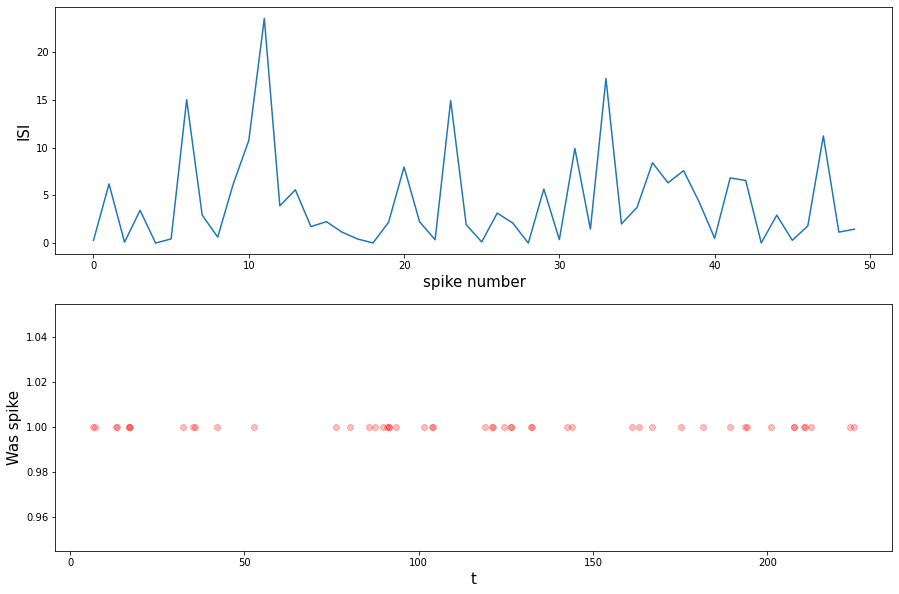

In [234]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot([i for i in range(50)], Inhibitory_ISI_data[0][0][0:50])
ax1.set_ylabel('ISI', fontsize = 15)
ax1.set_xlabel('spike number', fontsize = 15)

ax2.plot(Inhibitory_ts_data[0][0][0:50], [1] * len(Inhibitory_ts_data[0][0][0:50]), 'ro', alpha = 0.25)
ax2.set_ylabel('Was spike', fontsize = 15)
ax2.set_xlabel('t', fontsize = 15)
plt.show()

### Извлекаем признаки

In [33]:
Inhibitory_format_data_ISI = []
for animal in range(len(Inhibitory_ISI_data)) :
  Inhibitory_format_data_ISI.append([])
  tmp1 = []
  tmp2 = []
  ISI_size_I = len(Inhibitory_ISI_data[animal])
  for i in range(ISI_size_I):
      tmp1 += Inhibitory_ISI_data[animal][i]
      tmp2 += [i] * len(Inhibitory_ISI_data[animal][i])

  Inhibitory_format_data_ISI[animal] = pd.DataFrame()
  Inhibitory_format_data_ISI[animal][0] = pd.Series(tmp1)
  Inhibitory_format_data_ISI[animal][1] = pd.Series(tmp2)

<ipython-input-33-a9f98ed19bdd>:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Inhibitory_format_data_ISI[animal][0] = pd.Series(tmp1)
<ipython-input-33-a9f98ed19bdd>:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Inhibitory_format_data_ISI[animal][1] = pd.Series(tmp2)


In [34]:
Excitatory_format_data_ISI = []
for animal in range(len(Excitatory_ISI_data)) :
  Excitatory_format_data_ISI.append([])
  tmp1 = []
  tmp2 = []
  ISI_size_E = len(Excitatory_ISI_data[animal])
  for i in range(ISI_size_E):
      tmp1 += Excitatory_ISI_data[animal][i]
      tmp2 += [i] * len(Excitatory_ISI_data[animal][i])

  Excitatory_format_data_ISI[animal] = pd.DataFrame()
  Excitatory_format_data_ISI[animal][0] = pd.Series(tmp1)
  Excitatory_format_data_ISI[animal][1] = pd.Series(tmp2)

#### Извлекаем минимальный набор признаков

In [35]:
Inhibitory_feature_ISI_minimal = []
Excitatory_feature_ISI_minimal = []
n_animals = len(Inhibitory_format_data_ISI)
for animal in range(n_animals) :
  print(f'animal №{animal + 1}/{n_animals}')

  if (Inhibitory_neuron_type_size[animal] == 0) :
    print("No inhibitory nuerons")
    Inhibitory_feature_ISI_minimal.append([0])
  else :
    Inhibitory_feature_ISI_minimal.append(extract_features(Inhibitory_format_data_ISI[animal], column_id=1, default_fc_parameters=MinimalFCParameters(), n_jobs = 10))
    tsfresh.utilities.dataframe_functions.impute(Inhibitory_feature_ISI_minimal[animal])

  if (Excitatory_neuron_type_size[animal] == 0) :
    print("No excitatory nuerons")
    Excitatory_feature_ISI_minimal.append([0])
  else :
    Excitatory_feature_ISI_minimal.append(extract_features(Excitatory_format_data_ISI[animal], column_id=1, default_fc_parameters=MinimalFCParameters(), n_jobs = 10))
    tsfresh.utilities.dataframe_functions.impute(Excitatory_feature_ISI_minimal[animal])

animal №1/25


Feature Extraction: 100%|██████████| 26/26 [00:03<00:00,  6.72it/s]

animal №2/25



Feature Extraction: 100%|██████████| 24/24 [00:04<00:00,  5.91it/s]

animal №3/25



Feature Extraction: 100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

animal №4/25



Feature Extraction: 100%|██████████| 43/43 [00:04<00:00,  9.85it/s]

animal №5/25



Feature Extraction: 100%|██████████| 34/34 [00:04<00:00,  8.05it/s]

animal №6/25



Feature Extraction: 100%|██████████| 34/34 [00:04<00:00,  7.64it/s]

animal №7/25



Feature Extraction: 100%|██████████| 37/37 [00:04<00:00,  8.26it/s]

animal №8/25



Feature Extraction: 100%|██████████| 26/26 [00:04<00:00,  5.93it/s]

animal №9/25



Feature Extraction: 100%|██████████| 17/17 [00:04<00:00,  3.90it/s]

animal №10/25



Feature Extraction: 100%|██████████| 30/30 [00:04<00:00,  7.03it/s]


animal №11/25


Feature Extraction: 100%|██████████| 28/28 [00:04<00:00,  6.73it/s]

animal №12/25



Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]

animal №13/25



Feature Extraction: 100%|██████████| 33/33 [00:04<00:00,  8.24it/s]

animal №14/25



Feature Extraction: 100%|██████████| 46/46 [00:04<00:00, 10.90it/s]

animal №15/25



Feature Extraction: 100%|██████████| 28/28 [00:04<00:00,  6.60it/s]

animal №16/25



Feature Extraction: 100%|██████████| 23/23 [00:04<00:00,  5.60it/s]

animal №17/25



Feature Extraction: 100%|██████████| 32/32 [00:04<00:00,  8.00it/s]

animal №18/25
No inhibitory nuerons



Feature Extraction: 100%|██████████| 18/18 [00:04<00:00,  4.36it/s]

animal №19/25
No inhibitory nuerons



Feature Extraction: 100%|██████████| 16/16 [00:04<00:00,  3.86it/s]

animal №20/25



Feature Extraction: 100%|██████████| 40/40 [00:04<00:00,  9.37it/s]

animal №21/25



Feature Extraction: 100%|██████████| 25/25 [00:04<00:00,  5.89it/s]


animal №22/25


Feature Extraction: 100%|██████████| 45/45 [00:04<00:00, 10.30it/s]


animal №23/25


Feature Extraction: 100%|██████████| 25/25 [00:04<00:00,  5.68it/s]

animal №24/25



Feature Extraction: 100%|██████████| 42/42 [00:04<00:00,  8.62it/s]


animal №25/25
No inhibitory nuerons


Feature Extraction: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


#### Извлекаем все признаки

In [ ]:
params = []
bad_params = [32, 46, 58, 63, 74]
for elem in ComprehensiveFCParameters() :
    params.append(elem)

settings = ComprehensiveFCParameters()

for bad_param in bad_params :
    del settings[params[bad_param]]

In [ ]:
Inhibitory_feature_data_ISI = []
Excitatory_feature_data_ISI = []
n_animals = len(Inhibitory_format_data_ISI)
for animal in range(n_animals) :
  print(f'animal №{animal + 1}/{n_animals}')

  if (Inhibitory_neuron_type_size[animal] == 0) :
    print("No inhibitory nuerons")
    Inhibitory_feature_data_ISI.append([0])
  else :
    Inhibitory_feature_data_ISI.append(extract_features(Inhibitory_format_data_ISI[animal], column_id=1, default_fc_parameters=settings, n_jobs = 10))

  if (Excitatory_neuron_type_size[animal] == 0) :
    print("No excitatory nuerons")
    Excitatory_feature_data_ISI.append([0])
  else :
    Excitatory_feature_data_ISI.append(extract_features(Excitatory_format_data_ISI[animal], column_id=1, default_fc_parameters=settings, n_jobs = 10))

In [ ]:
Inhibitory_feature_ISI_all = pd.DataFrame()
for i in range(len(Inhibitory_feature_data_ISI)) :
  if Inhibitory_neuron_type_size[i] :
    Inhibitory_feature_ISI_all = pd.concat([Inhibitory_feature_ISI_all, Inhibitory_feature_data_ISI[i]])

In [ ]:
Excitatory_feature_ISI_all = pd.DataFrame()
for i in range(len(Excitatory_feature_data_ISI)) :
  if Excitatory_neuron_type_size[i] :
    Excitatory_feature_ISI_all = pd.concat([Excitatory_feature_ISI_all, Excitatory_feature_data_ISI[i]])

### Скачаем данные

In [36]:
Inhibitory_feature_ISI_all = pd.read_csv('https://raw.githubusercontent.com/KAD1029/Neural_Activity/master/Feature_data/Inhibitory_feature_ISI_all.csv')
Excitatory_feature_ISI_all = pd.read_csv('https://raw.githubusercontent.com/KAD1029/Neural_Activity/master/Feature_data/Excitatory_feature_ISI_all.csv')

In [37]:
tsfresh.utilities.dataframe_functions.impute(Inhibitory_feature_ISI_all)
tsfresh.utilities.dataframe_functions.impute(Excitatory_feature_ISI_all)

/opt/anaconda3/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(


,0__variance_larger_than_standard_deviation,0__has_duplicate_max,0__has_duplicate_min,0__has_duplicate,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__mean_second_derivative_central,0__median,...,0__fourier_entropy__bins_5,0__fourier_entropy__bins_10,0__fourier_entropy__bins_100,0__permutation_entropy__dimension_3__tau_1,0__permutation_entropy__dimension_4__tau_1,0__permutation_entropy__dimension_5__tau_1,0__permutation_entropy__dimension_6__tau_1,0__permutation_entropy__dimension_7__tau_1,0__query_similarity_count__query_None__threshold_0.0,0__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,1.0,13564.62960,87476.598359,2.745352,0.000164,0.000852,1.564300,...,0.892641,1.390759,3.476307,1.791174,3.174893,4.774641,6.509188,7.965281,0.0,27.869393
1,1.0,0.0,0.0,1.0,13545.19275,295615.315764,3.332609,0.000420,-0.000131,0.596400,...,1.227218,1.840590,3.775474,1.790951,3.173654,4.771157,6.497900,7.982304,0.0,129.248907
2,1.0,0.0,0.0,1.0,13566.21875,293133.962834,1.563018,-0.000008,-0.000223,0.162800,...,1.191901,1.858893,3.809672,1.791093,3.175718,4.780620,6.539782,8.220416,0.0,97.062457
3,1.0,0.0,0.0,1.0,13563.27450,91139.748956,1.763975,0.000661,0.000423,0.551800,...,1.239331,1.856147,3.837007,1.790909,3.174473,4.775222,6.531718,8.193731,0.0,41.659821
4,1.0,0.0,0.0,1.0,13556.99485,55726.107016,1.432113,0.000002,-0.000242,0.597350,...,0.829858,1.170112,3.041683,1.791059,3.175716,4.779064,6.538825,8.240178,0.0,23.408093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,1.0,0.0,0.0,1.0,19021.55370,378074.986118,4.230236,-0.000510,-0.001131,0.126175,...,1.070514,1.667539,3.597951,1.790827,3.173631,4.773637,6.516287,8.070629,0.0,92.074757
876,1.0,0.0,0.0,1.0,19055.71680,171037.053887,2.936106,0.000138,-0.000194,0.899450,...,0.507764,1.081788,2.983746,1.791004,3.173435,4.771757,6.515090,8.120436,0.0,46.885779
877,1.0,0.0,0.0,1.0,19054.99705,219791.021587,1.832868,0.000243,-0.000140,0.451725,...,0.170467,0.307703,2.188259,1.791103,3.175085,4.777721,6.540750,8.279755,0.0,80.857714
878,1.0,0.0,0.0,1.0,19055.15620,129005.877636,2.558208,0.000008,-0.000418,1.084400,...,0.830600,1.229848,3.265159,1.791019,3.175419,4.779045,6.534889,8.180381,0.0,33.328943


In [38]:
Inhibitory_feature_ISI = []
cur_index = 0
for i in range(len(Inhibitory_neuron_type_size)) :
  Inhibitory_feature_ISI.append(Inhibitory_feature_ISI_all.iloc[cur_index : cur_index + Inhibitory_neuron_type_size[i]])
  cur_index += Inhibitory_neuron_type_size[i]

In [39]:
Excitatory_feature_ISI = []
cur_index = 0
for i in range(len(Excitatory_neuron_type_size)) :
  Excitatory_feature_ISI.append(Excitatory_feature_ISI_all.iloc[cur_index : cur_index + Excitatory_neuron_type_size[i]])
  cur_index += Excitatory_neuron_type_size[i]

## Эксперименты для частотных данных, a = 0.8, минимальный набор признаков

### Разбиваем данные на тестовую и обучающую выборки

In [ ]:
test_part = 0.25
Inhibitory_test_type_size = (Inhibitory_neuron_type_size * test_part).astype(int)

Excitatory_test_type_size = (Excitatory_neuron_type_size * test_part).astype(int)

In [ ]:
Inhibitory_feature_freq_minimal_test = pd.DataFrame()
Inhibitory_feature_freq_minimal_train = pd.DataFrame()

for i in range(len(Inhibitory_feature_freq_minimal)) :
  test_numbers = random.sample([i for i in range(len(Inhibitory_feature_freq_minimal[i]))], Inhibitory_test_type_size[i])
  for k in range(len(Inhibitory_feature_freq_minimal[i])) :
    if k in test_numbers :
      Inhibitory_feature_freq_minimal_test = pd.concat([Inhibitory_feature_freq_minimal_test,
                                                        pd.DataFrame([Inhibitory_feature_freq_minimal[i].iloc[k]])])
    else :
      Inhibitory_feature_freq_minimal_train = pd.concat([Inhibitory_feature_freq_minimal_train,
                                                         pd.DataFrame([Inhibitory_feature_freq_minimal[i].iloc[k]])])

In [ ]:
Excitatory_feature_freq_minimal_test = pd.DataFrame()
Excitatory_feature_freq_minimal_train = pd.DataFrame()

for i in range(len(Excitatory_feature_freq_minimal)) :
  test_numbers = random.sample([i for i in range(len(Excitatory_feature_freq_minimal[i]))], Excitatory_test_type_size[i])
  for k in range(len(Excitatory_feature_freq_minimal[i])) :
    if k in test_numbers :
      Excitatory_feature_freq_minimal_test = pd.concat([Excitatory_feature_freq_minimal_test,
                                                        pd.DataFrame([Excitatory_feature_freq_minimal[i].iloc[k]])])
    else :
      Excitatory_feature_freq_minimal_train = pd.concat([Excitatory_feature_freq_minimal_train,
                                                         pd.DataFrame([Excitatory_feature_freq_minimal[i].iloc[k]])])

In [ ]:
X_test = pd.concat([Inhibitory_feature_freq_minimal_test, Excitatory_feature_freq_minimal_test])
X_train = pd.concat([Inhibitory_feature_freq_minimal_train, Excitatory_feature_freq_minimal_train])

y_test = [-1] * len(Inhibitory_feature_freq_minimal_test) + [1] * len(Excitatory_feature_freq_minimal_test)
y_train = [-1] * len(Inhibitory_feature_freq_minimal_train) + [1] * len(Excitatory_feature_freq_minimal_train)

### Обучение

#### KNN minimal_parameters

p = 1

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("KNN Confusion_matrix", fontsize = 25)
plt.subplots_adjust(wspace=0.2, hspace=0.7)

for i in range(12) :
  model = KNN(1 + 2 * i, p = 1)
  reg = model.fit(X_train, y_train)
  cfn_matrix = confusion_matrix(y_test, model.predict(X_test))

  ax = fig.add_subplot(3,4,i + 1)
  sns.heatmap(cfn_matrix, cmap='coolwarm_r', linewidths=0.5, annot=True, ax=ax, fmt="d")
  ax.set_title(f'KNN(k = {1 + 2 * i}, p = 1)', fontsize = 20)
  ax.set_ylabel('Real Classes', fontsize = 15)
  ax.set_xlabel('Predicted Classes', fontsize = 15)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,9))
plt.suptitle("KNN ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(12) :
  model = KNN(1 + 2 * i, p = 1)
  reg = model.fit(X_train, y_train)
  tpr,fpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

  ax = fig.add_subplot(3,4,i + 1)
  ax.plot(tpr,fpr)
  ax.set_title(f'KNN(k = {1 + 2 * i}, p = 1)', fontsize = 15)
  ax.set_xlabel('False Positive Rate', fontsize = 10)
  ax.set_ylabel('True Positive Rate', fontsize = 10)
  ax.plot([0, 1], [0, 1], 'k--')

plt.show()

p = 2

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("KNN Confusion_matrix", fontsize = 25)
plt.subplots_adjust(wspace=0.2, hspace=0.7)

for i in range(12) :
  model = KNN(1 + 2 * i, p = 2)
  reg = model.fit(X_train, y_train)
  cfn_matrix = confusion_matrix(y_test, model.predict(X_test))

  ax = fig.add_subplot(3,4,i + 1)
  sns.heatmap(cfn_matrix, cmap='coolwarm_r', linewidths=0.5, annot=True, ax=ax, fmt="d")
  ax.set_title(f'KNN(k = {1 + 2 * i}, p = 1)', fontsize = 20)
  ax.set_ylabel('Real Classes', fontsize = 15)
  ax.set_xlabel('Predicted Classes', fontsize = 15)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,9))
plt.suptitle("KNN ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(12) :
  model = KNN(1 + 2 * i, p = 2)
  reg = model.fit(X_train, y_train)
  tpr,fpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

  ax = fig.add_subplot(3,4,i + 1)
  ax.plot(tpr,fpr)
  ax.set_title(f'KNN(k = {1 + 2 * i}, p = 1)', fontsize = 15)
  ax.set_xlabel('False Positive Rate', fontsize = 10)
  ax.set_ylabel('True Positive Rate', fontsize = 10)
  ax.plot([0, 1], [0, 1], 'k--')

plt.show()

#### Random_Forest minimal_parameters

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("Rand_Forest Confusion_matrix", fontsize = 25)
plt.subplots_adjust(wspace=0.2, hspace=0.7)

for i in range(12) :
  model = Rand_Forest(n_estimators = 1 + 9 * i)
  reg = model.fit(X_train, y_train)
  cfn_matrix = confusion_matrix(y_test, model.predict(X_test))

  ax = fig.add_subplot(3,4,i + 1)
  sns.heatmap(cfn_matrix, cmap='coolwarm_r', linewidths=0.5, annot=True, ax=ax, fmt="d")
  ax.set_title(f'Rand_Forest(n = {1 + 9 * i})', fontsize = 20)
  ax.set_ylabel('Real Classes', fontsize = 15)
  ax.set_xlabel('Predicted Classes', fontsize = 15)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,9))
plt.suptitle("Rand_Forest ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(12) :
  model = Rand_Forest(n_estimators = 1 + 9 * i)
  reg = model.fit(X_train, y_train)
  tpr,fpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

  ax = fig.add_subplot(3,4,i + 1)
  ax.plot(tpr,fpr)
  ax.set_title(f'Rand_Forest(n = {1 + 9 * i})', fontsize = 15)
  ax.set_xlabel('False Positive Rate', fontsize = 10)
  ax.set_ylabel('True Positive Rate', fontsize = 10)
  ax.plot([0, 1], [0, 1], 'k--')

plt.show()

#### GradientBoostingClassifier minimal_parameters

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("GradientBoostingClassifier Confusion_matrix", fontsize = 25)
plt.subplots_adjust(wspace=0.2, hspace=0.7)

for i in range(12) :
  model = GBC(n_estimators = 1 + 9 * i)
  reg = model.fit(X_train, y_train)
  cfn_matrix = confusion_matrix(y_test, model.predict(X_test))

  ax = fig.add_subplot(3,4,i + 1)
  sns.heatmap(cfn_matrix, cmap='coolwarm_r', linewidths=0.5, annot=True, ax=ax, fmt="d")
  ax.set_title(f'GBC(n = {1 + 9 * i})', fontsize = 20)
  ax.set_ylabel('Real Classes', fontsize = 15)
  ax.set_xlabel('Predicted Classes', fontsize = 15)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,9))
plt.suptitle("GradientBoostingClassifier ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(12) :
  model = GBC(n_estimators = 1 + 9 * i)
  reg = model.fit(X_train, y_train)
  tpr,fpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

  ax = fig.add_subplot(3,4,i + 1)
  ax.plot(tpr,fpr)
  ax.set_title(f'GBC(n = {1 + 9 * i})', fontsize = 15)
  ax.set_xlabel('False Positive Rate', fontsize = 10)
  ax.set_ylabel('True Positive Rate', fontsize = 10)
  ax.plot([0, 1], [0, 1], 'k--')

plt.show()

## Эксперименты для частотных данных, a = 0.8, полный набор признаков

### Разбиваем данные на тестовую и обучающую выборки

In [ ]:
test_part = 0.25
Inhibitory_test_type_size = (Inhibitory_neuron_type_size * test_part).astype(int)

Excitatory_test_type_size = (Excitatory_neuron_type_size * test_part).astype(int)

In [ ]:
Inhibitory_feature_freq_test = pd.DataFrame()
Inhibitory_feature_freq_train = pd.DataFrame()

for i in range(len(Inhibitory_feature_freq)) :
  test_numbers = random.sample([i for i in range(len(Inhibitory_feature_freq[i]))], Inhibitory_test_type_size[i])
  for k in range(len(Inhibitory_feature_freq[i])) :
    if k in test_numbers :
      Inhibitory_feature_freq_test = pd.concat([Inhibitory_feature_freq_test,
                                                        pd.DataFrame([Inhibitory_feature_freq[i].iloc[k]])])
    else :
      Inhibitory_feature_freq_train = pd.concat([Inhibitory_feature_freq_train,
                                                         pd.DataFrame([Inhibitory_feature_freq[i].iloc[k]])])

In [ ]:
Excitatory_feature_freq_test = pd.DataFrame()
Excitatory_feature_freq_train = pd.DataFrame()

for i in range(len(Excitatory_feature_freq)) :
  test_numbers = random.sample([i for i in range(len(Excitatory_feature_freq[i]))], Excitatory_test_type_size[i])
  for k in range(len(Excitatory_feature_freq[i])) :
    if k in test_numbers :
      Excitatory_feature_freq_test = pd.concat([Excitatory_feature_freq_test,
                                                        pd.DataFrame([Excitatory_feature_freq[i].iloc[k]])])
    else :
      Excitatory_feature_freq_train = pd.concat([Excitatory_feature_freq_train,
                                                         pd.DataFrame([Excitatory_feature_freq[i].iloc[k]])])

### Обучение

#### KNN

p = 1

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("KNN Confusion_matrix", fontsize = 25)
plt.subplots_adjust(wspace=0.2, hspace=0.7)

for i in range(12) :
  model = KNN(1 + 2 * i, p = 1)
  reg = model.fit(X_train, y_train)
  cfn_matrix = confusion_matrix(y_test, model.predict(X_test))

  ax = fig.add_subplot(3,4,i + 1)
  sns.heatmap(cfn_matrix, cmap='coolwarm_r', linewidths=0.5, annot=True, ax=ax, fmt="d")
  ax.set_title(f'KNN(k = {1 + 2 * i}, p = 1)', fontsize = 20)
  ax.set_ylabel('Real Classes', fontsize = 15)
  ax.set_xlabel('Predicted Classes', fontsize = 15)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,9))
plt.suptitle("KNN ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(12) :
  model = KNN(1 + 2 * i, p = 1)
  reg = model.fit(X_train, y_train)
  tpr,fpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

  ax = fig.add_subplot(3,4,i + 1)
  ax.plot(tpr,fpr)
  ax.set_title(f'KNN(k = {1 + 2 * i}, p = 1)', fontsize = 15)
  ax.set_xlabel('False Positive Rate', fontsize = 10)
  ax.set_ylabel('True Positive Rate', fontsize = 10)
  ax.plot([0, 1], [0, 1], 'k--')

plt.show()

p = 2

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("KNN Confusion_matrix", fontsize = 25)
plt.subplots_adjust(wspace=0.2, hspace=0.7)

for i in range(12) :
  model = KNN(1 + 2 * i, p = 2)
  reg = model.fit(X_train, y_train)
  cfn_matrix = confusion_matrix(y_test, model.predict(X_test))

  ax = fig.add_subplot(3,4,i + 1)
  sns.heatmap(cfn_matrix, cmap='coolwarm_r', linewidths=0.5, annot=True, ax=ax, fmt="d")
  ax.set_title(f'KNN(k = {1 + 2 * i}, p = 1)', fontsize = 20)
  ax.set_ylabel('Real Classes', fontsize = 15)
  ax.set_xlabel('Predicted Classes', fontsize = 15)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,9))
plt.suptitle("KNN ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(12) :
  model = KNN(1 + 2 * i, p = 2)
  reg = model.fit(X_train, y_train)
  tpr,fpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

  ax = fig.add_subplot(3,4,i + 1)
  ax.plot(tpr,fpr)
  ax.set_title(f'KNN(k = {1 + 2 * i}, p = 1)', fontsize = 15)
  ax.set_xlabel('False Positive Rate', fontsize = 10)
  ax.set_ylabel('True Positive Rate', fontsize = 10)
  ax.plot([0, 1], [0, 1], 'k--')

plt.show()

#### Random_Forest

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("Rand_Forest Confusion_matrix", fontsize = 25)
plt.subplots_adjust(wspace=0.2, hspace=0.7)

for i in range(12) :
  model = Rand_Forest(n_estimators = 1 + 9 * i)
  reg = model.fit(X_train, y_train)
  cfn_matrix = confusion_matrix(y_test, model.predict(X_test))

  ax = fig.add_subplot(3,4,i + 1)
  sns.heatmap(cfn_matrix, cmap='coolwarm_r', linewidths=0.5, annot=True, ax=ax, fmt="d")
  ax.set_title(f'Rand_Forest(n = {1 + 9 * i})', fontsize = 20)
  ax.set_ylabel('Real Classes', fontsize = 15)
  ax.set_xlabel('Predicted Classes', fontsize = 15)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,9))
plt.suptitle("Rand_Forest ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(12) :
  model = Rand_Forest(n_estimators = 1 + 9 * i)
  reg = model.fit(X_train, y_train)
  tpr,fpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

  ax = fig.add_subplot(3,4,i + 1)
  ax.plot(tpr,fpr)
  ax.set_title(f'Rand_Forest(n = {1 + 9 * i})', fontsize = 15)
  ax.set_xlabel('False Positive Rate', fontsize = 10)
  ax.set_ylabel('True Positive Rate', fontsize = 10)
  ax.plot([0, 1], [0, 1], 'k--')

plt.show()

#### GradientBoostingClassifier

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("GradientBoostingClassifier Confusion_matrix", fontsize = 25)
plt.subplots_adjust(wspace=0.2, hspace=0.7)

for i in range(12) :
  model = GBC(n_estimators = 1 + 9 * i)
  reg = model.fit(X_train, y_train)
  cfn_matrix = confusion_matrix(y_test, model.predict(X_test))

  ax = fig.add_subplot(3,4,i + 1)
  sns.heatmap(cfn_matrix, cmap='coolwarm_r', linewidths=0.5, annot=True, ax=ax, fmt="d")
  ax.set_title(f'GBC(n = {1 + 9 * i})', fontsize = 20)
  ax.set_ylabel('Real Classes', fontsize = 15)
  ax.set_xlabel('Predicted Classes', fontsize = 15)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,9))
plt.suptitle("GradientBoostingClassifier ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(12) :
  model = GBC(n_estimators = 1 + 9 * i)
  reg = model.fit(X_train, y_train)
  tpr,fpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

  ax = fig.add_subplot(3,4,i + 1)
  ax.plot(tpr,fpr)
  ax.set_title(f'GBC(n = {1 + 9 * i})', fontsize = 15)
  ax.set_xlabel('False Positive Rate', fontsize = 10)
  ax.set_ylabel('True Positive Rate', fontsize = 10)
  ax.plot([0, 1], [0, 1], 'k--')

plt.show()

## Эксперименты для частотных данных, a = 0.1, минимальный набор признаков

### Разбиваем данные на тестовую и обучающую выборки

In [ ]:
test_part = 0.25
Inhibitory_test_type_size = (Inhibitory_neuron_type_size * test_part).astype(int)

Excitatory_test_type_size = (Excitatory_neuron_type_size * test_part).astype(int)

In [ ]:
Inhibitory_feature_freq_minimal_01_test = pd.DataFrame()
Inhibitory_feature_freq_minimal_01_train = pd.DataFrame()

for i in range(len(Inhibitory_feature_freq_minimal_01)) :
  test_numbers = random.sample([i for i in range(len(Inhibitory_feature_freq_minimal_01[i]))], Inhibitory_test_type_size[i])
  for k in range(len(Inhibitory_feature_freq_minimal_01[i])) :
    if k in test_numbers :
      Inhibitory_feature_freq_minimal_01_test = pd.concat([Inhibitory_feature_freq_minimal_01_test,
                                                        pd.DataFrame([Inhibitory_feature_freq_minimal_01[i].iloc[k]])])
    else :
      Inhibitory_feature_freq_minimal_01_train = pd.concat([Inhibitory_feature_freq_minimal_01_train,
                                                         pd.DataFrame([Inhibitory_feature_freq_minimal_01[i].iloc[k]])])

In [ ]:
Excitatory_feature_freq_minimal_01_test = pd.DataFrame()
Excitatory_feature_freq_minimal_01_train = pd.DataFrame()

for i in range(len(Excitatory_feature_freq_minimal_01)) :
  test_numbers = random.sample([i for i in range(len(Excitatory_feature_freq_minimal_01[i]))], Excitatory_test_type_size[i])
  for k in range(len(Excitatory_feature_freq_minimal_01[i])) :
    if k in test_numbers :
      Excitatory_feature_freq_minimal_01_test = pd.concat([Excitatory_feature_freq_minimal_01_test,
                                                        pd.DataFrame([Excitatory_feature_freq_minimal_01[i].iloc[k]])])
    else :
      Excitatory_feature_freq_minimal_01_train = pd.concat([Excitatory_feature_freq_minimal_01_train,
                                                         pd.DataFrame([Excitatory_feature_freq_minimal_01[i].iloc[k]])])

### Обучение

#### KNN minimal_parameters

p = 1

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("KNN Confusion_matrix", fontsize = 25)
plt.subplots_adjust(wspace=0.2, hspace=0.7)

for i in range(12) :
  model = KNN(1 + 2 * i, p = 1)
  reg = model.fit(X_train, y_train)
  cfn_matrix = confusion_matrix(y_test, model.predict(X_test))

  ax = fig.add_subplot(3,4,i + 1)
  sns.heatmap(cfn_matrix, cmap='coolwarm_r', linewidths=0.5, annot=True, ax=ax, fmt="d")
  ax.set_title(f'KNN(k = {1 + 2 * i}, p = 1)', fontsize = 20)
  ax.set_ylabel('Real Classes', fontsize = 15)
  ax.set_xlabel('Predicted Classes', fontsize = 15)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,9))
plt.suptitle("KNN ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(12) :
  model = KNN(1 + 2 * i, p = 1)
  reg = model.fit(X_train, y_train)
  tpr,fpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

  ax = fig.add_subplot(3,4,i + 1)
  ax.plot(tpr,fpr)
  ax.set_title(f'KNN(k = {1 + 2 * i}, p = 1)', fontsize = 15)
  ax.set_xlabel('False Positive Rate', fontsize = 10)
  ax.set_ylabel('True Positive Rate', fontsize = 10)
  ax.plot([0, 1], [0, 1], 'k--')

plt.show()

p = 2

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("KNN Confusion_matrix", fontsize = 25)
plt.subplots_adjust(wspace=0.2, hspace=0.7)

for i in range(12) :
  model = KNN(1 + 2 * i, p = 2)
  reg = model.fit(X_train, y_train)
  cfn_matrix = confusion_matrix(y_test, model.predict(X_test))

  ax = fig.add_subplot(3,4,i + 1)
  sns.heatmap(cfn_matrix, cmap='coolwarm_r', linewidths=0.5, annot=True, ax=ax, fmt="d")
  ax.set_title(f'KNN(k = {1 + 2 * i}, p = 1)', fontsize = 20)
  ax.set_ylabel('Real Classes', fontsize = 15)
  ax.set_xlabel('Predicted Classes', fontsize = 15)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,9))
plt.suptitle("KNN ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(12) :
  model = KNN(1 + 2 * i, p = 2)
  reg = model.fit(X_train, y_train)
  tpr,fpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

  ax = fig.add_subplot(3,4,i + 1)
  ax.plot(tpr,fpr)
  ax.set_title(f'KNN(k = {1 + 2 * i}, p = 1)', fontsize = 15)
  ax.set_xlabel('False Positive Rate', fontsize = 10)
  ax.set_ylabel('True Positive Rate', fontsize = 10)
  ax.plot([0, 1], [0, 1], 'k--')

plt.show()

#### Random_Forest minimal_parameters

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("Rand_Forest Confusion_matrix", fontsize = 25)
plt.subplots_adjust(wspace=0.2, hspace=0.7)

for i in range(12) :
  model = Rand_Forest(n_estimators = 1 + 9 * i)
  reg = model.fit(X_train, y_train)
  cfn_matrix = confusion_matrix(y_test, model.predict(X_test))

  ax = fig.add_subplot(3,4,i + 1)
  sns.heatmap(cfn_matrix, cmap='coolwarm_r', linewidths=0.5, annot=True, ax=ax, fmt="d")
  ax.set_title(f'Rand_Forest(n = {1 + 9 * i})', fontsize = 20)
  ax.set_ylabel('Real Classes', fontsize = 15)
  ax.set_xlabel('Predicted Classes', fontsize = 15)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,9))
plt.suptitle("Rand_Forest ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(12) :
  model = Rand_Forest(n_estimators = 1 + 9 * i)
  reg = model.fit(X_train, y_train)
  tpr,fpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

  ax = fig.add_subplot(3,4,i + 1)
  ax.plot(tpr,fpr)
  ax.set_title(f'Rand_Forest(n = {1 + 9 * i})', fontsize = 15)
  ax.set_xlabel('False Positive Rate', fontsize = 10)
  ax.set_ylabel('True Positive Rate', fontsize = 10)
  ax.plot([0, 1], [0, 1], 'k--')

plt.show()

#### GradientBoostingClassifier minimal_parameters

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("GradientBoostingClassifier Confusion_matrix", fontsize = 25)
plt.subplots_adjust(wspace=0.2, hspace=0.7)

for i in range(12) :
  model = GBC(n_estimators = 1 + 9 * i)
  reg = model.fit(X_train, y_train)
  cfn_matrix = confusion_matrix(y_test, model.predict(X_test))

  ax = fig.add_subplot(3,4,i + 1)
  sns.heatmap(cfn_matrix, cmap='coolwarm_r', linewidths=0.5, annot=True, ax=ax, fmt="d")
  ax.set_title(f'GBC(n = {1 + 9 * i})', fontsize = 20)
  ax.set_ylabel('Real Classes', fontsize = 15)
  ax.set_xlabel('Predicted Classes', fontsize = 15)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,9))
plt.suptitle("GradientBoostingClassifier ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(12) :
  model = GBC(n_estimators = 1 + 9 * i)
  reg = model.fit(X_train, y_train)
  tpr,fpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

  ax = fig.add_subplot(3,4,i + 1)
  ax.plot(tpr,fpr)
  ax.set_title(f'GBC(n = {1 + 9 * i})', fontsize = 15)
  ax.set_xlabel('False Positive Rate', fontsize = 10)
  ax.set_ylabel('True Positive Rate', fontsize = 10)
  ax.plot([0, 1], [0, 1], 'k--')

plt.show()

## Эксперименты для ISI данных, минимальный набор признаков

### Разбиваем данные на тестовую и обучающую выборки

In [ ]:
test_part = 0.25
Inhibitory_test_type_size = (Inhibitory_neuron_type_size * test_part).astype(int)

Excitatory_test_type_size = (Excitatory_neuron_type_size * test_part).astype(int)

In [ ]:
Inhibitory_feature_ISI_minimal_test = pd.DataFrame()
Inhibitory_feature_ISI_minimal_train = pd.DataFrame()

for i in range(len(Inhibitory_feature_ISI_minimal)) :
  test_numbers = random.sample([i for i in range(len(Inhibitory_feature_ISI_minimal[i]))], Inhibitory_test_type_size[i])
  for k in range(len(Inhibitory_feature_freq_minimal[i])) :
    if k in test_numbers :
      Inhibitory_feature_ISI_minimal_test = pd.concat([Inhibitory_feature_ISI_minimal_test,
                                                        pd.DataFrame([Inhibitory_feature_ISI_minimal[i].iloc[k]])])
    else :
      Inhibitory_feature_ISI_minimal_train = pd.concat([Inhibitory_feature_ISI_minimal_train,
                                                         pd.DataFrame([Inhibitory_feature_ISI_minimal[i].iloc[k]])])

In [ ]:
Excitatory_feature_ISI_minimal_test = pd.DataFrame()
Excitatory_feature_ISI_minimal_train = pd.DataFrame()

for i in range(len(Excitatory_feature_ISI_minimal)) :
  test_numbers = random.sample([i for i in range(len(Excitatory_feature_ISI_minimal[i]))], Excitatory_test_type_size[i])
  for k in range(len(Excitatory_feature_ISI_minimal[i])) :
    if k in test_numbers :
      Excitatory_feature_ISI_minimal_test = pd.concat([Excitatory_feature_ISI_minimal_test,
                                                        pd.DataFrame([Excitatory_feature_ISI_minimal[i].iloc[k]])])
    else :
      Excitatory_feature_freq_minimal_train = pd.concat([Excitatory_feature_ISI_minimal_train,
                                                         pd.DataFrame([Excitatory_feature_ISI_minimal[i].iloc[k]])])

### Обучение

#### KNN minimal_parameters

p = 1

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("KNN Confusion_matrix", fontsize = 25)
plt.subplots_adjust(wspace=0.2, hspace=0.7)

for i in range(12) :
  model = KNN(1 + 2 * i, p = 1)
  reg = model.fit(X_train, y_train)
  cfn_matrix = confusion_matrix(y_test, model.predict(X_test))

  ax = fig.add_subplot(3,4,i + 1)
  sns.heatmap(cfn_matrix, cmap='coolwarm_r', linewidths=0.5, annot=True, ax=ax, fmt="d")
  ax.set_title(f'KNN(k = {1 + 2 * i}, p = 1)', fontsize = 20)
  ax.set_ylabel('Real Classes', fontsize = 15)
  ax.set_xlabel('Predicted Classes', fontsize = 15)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,9))
plt.suptitle("KNN ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(12) :
  model = KNN(1 + 2 * i, p = 1)
  reg = model.fit(X_train, y_train)
  tpr,fpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

  ax = fig.add_subplot(3,4,i + 1)
  ax.plot(tpr,fpr)
  ax.set_title(f'KNN(k = {1 + 2 * i}, p = 1)', fontsize = 15)
  ax.set_xlabel('False Positive Rate', fontsize = 10)
  ax.set_ylabel('True Positive Rate', fontsize = 10)
  ax.plot([0, 1], [0, 1], 'k--')

plt.show()

p = 2

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("KNN Confusion_matrix", fontsize = 25)
plt.subplots_adjust(wspace=0.2, hspace=0.7)

for i in range(12) :
  model = KNN(1 + 2 * i, p = 2)
  reg = model.fit(X_train, y_train)
  cfn_matrix = confusion_matrix(y_test, model.predict(X_test))

  ax = fig.add_subplot(3,4,i + 1)
  sns.heatmap(cfn_matrix, cmap='coolwarm_r', linewidths=0.5, annot=True, ax=ax, fmt="d")
  ax.set_title(f'KNN(k = {1 + 2 * i}, p = 1)', fontsize = 20)
  ax.set_ylabel('Real Classes', fontsize = 15)
  ax.set_xlabel('Predicted Classes', fontsize = 15)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,9))
plt.suptitle("KNN ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(12) :
  model = KNN(1 + 2 * i, p = 2)
  reg = model.fit(X_train, y_train)
  tpr,fpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

  ax = fig.add_subplot(3,4,i + 1)
  ax.plot(tpr,fpr)
  ax.set_title(f'KNN(k = {1 + 2 * i}, p = 1)', fontsize = 15)
  ax.set_xlabel('False Positive Rate', fontsize = 10)
  ax.set_ylabel('True Positive Rate', fontsize = 10)
  ax.plot([0, 1], [0, 1], 'k--')

plt.show()

#### Random_Forest minimal_parameters

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("Rand_Forest Confusion_matrix", fontsize = 25)
plt.subplots_adjust(wspace=0.2, hspace=0.7)

for i in range(12) :
  model = Rand_Forest(n_estimators = 1 + 9 * i)
  reg = model.fit(X_train, y_train)
  cfn_matrix = confusion_matrix(y_test, model.predict(X_test))

  ax = fig.add_subplot(3,4,i + 1)
  sns.heatmap(cfn_matrix, cmap='coolwarm_r', linewidths=0.5, annot=True, ax=ax, fmt="d")
  ax.set_title(f'Rand_Forest(n = {1 + 9 * i})', fontsize = 20)
  ax.set_ylabel('Real Classes', fontsize = 15)
  ax.set_xlabel('Predicted Classes', fontsize = 15)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,9))
plt.suptitle("Rand_Forest ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(12) :
  model = Rand_Forest(n_estimators = 1 + 9 * i)
  reg = model.fit(X_train, y_train)
  tpr,fpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

  ax = fig.add_subplot(3,4,i + 1)
  ax.plot(tpr,fpr)
  ax.set_title(f'Rand_Forest(n = {1 + 9 * i})', fontsize = 15)
  ax.set_xlabel('False Positive Rate', fontsize = 10)
  ax.set_ylabel('True Positive Rate', fontsize = 10)
  ax.plot([0, 1], [0, 1], 'k--')

plt.show()

#### GradientBoostingClassifier minimal_parameters

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("GradientBoostingClassifier Confusion_matrix", fontsize = 25)
plt.subplots_adjust(wspace=0.2, hspace=0.7)

for i in range(12) :
  model = GBC(n_estimators = 1 + 9 * i)
  reg = model.fit(X_train, y_train)
  cfn_matrix = confusion_matrix(y_test, model.predict(X_test))

  ax = fig.add_subplot(3,4,i + 1)
  sns.heatmap(cfn_matrix, cmap='coolwarm_r', linewidths=0.5, annot=True, ax=ax, fmt="d")
  ax.set_title(f'GBC(n = {1 + 9 * i})', fontsize = 20)
  ax.set_ylabel('Real Classes', fontsize = 15)
  ax.set_xlabel('Predicted Classes', fontsize = 15)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,9))
plt.suptitle("GradientBoostingClassifier ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(12) :
  model = GBC(n_estimators = 1 + 9 * i)
  reg = model.fit(X_train, y_train)
  tpr,fpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

  ax = fig.add_subplot(3,4,i + 1)
  ax.plot(tpr,fpr)
  ax.set_title(f'GBC(n = {1 + 9 * i})', fontsize = 15)
  ax.set_xlabel('False Positive Rate', fontsize = 10)
  ax.set_ylabel('True Positive Rate', fontsize = 10)
  ax.plot([0, 1], [0, 1], 'k--')

plt.show()

# Для отчета

## 1 Пример данных

Первые 100 спайков случайной записи

Text(0, 0.5, 't')

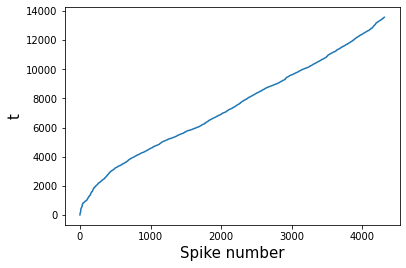

In [218]:
plt.plot([i for i in range(len(Inhibitory_ts_data[0][1]))], Inhibitory_ts_data[0][1])
plt.xlabel('Spike number', fontsize = 15)
plt.ylabel('t', fontsize = 15)

## 2 Примеры обработанных данных

### Частотный график, a = 0.8

In [220]:
Freq_plot_data = Inhibitory_ts_data[0][0][0:50]

In [226]:
Inhibitory_freq8 = [0]
h = 0.1
a = 0.8
b = 0.001
current_spike = 0
n_steps = int((Freq_plot_data[-1] - Freq_plot_data[0]) / h)
t = np.linspace(Freq_plot_data[0], Freq_plot_data[-1], n_steps)

for i in range(n_steps) :
  if abs(t[i] - Freq_plot_data[current_spike]) < h :
    S = 1
    while(current_spike < len(Freq_plot_data) and
          abs(t[i] - Freq_plot_data[current_spike]) < h) :
      current_spike += 1
  else :
    S = 0
  Inhibitory_freq8.append(Inhibitory_freq8[-1] + h * (-a * Inhibitory_freq8[i] + b * S))
      

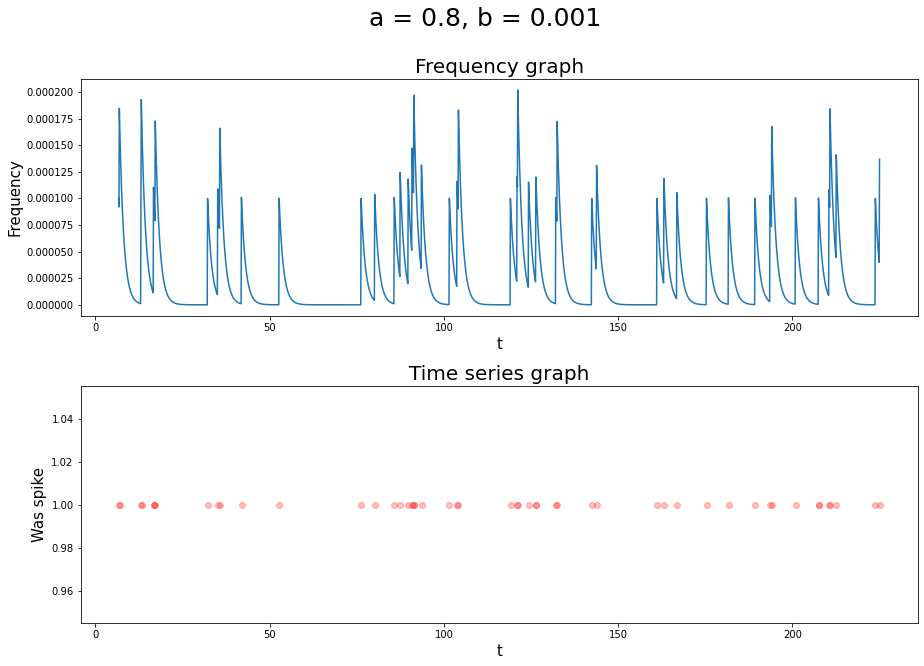

In [223]:
fig = plt.figure(figsize=(15, 10))
plt.suptitle("a = 0.8, b = 0.001", fontsize = 25)
plt.subplots_adjust(hspace=0.3)

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)


ax1.plot(t, Inhibitory_freq[1:])
ax1.set_title('Frequency graph', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('t', fontsize = 15)


ax2.plot(Freq_plot_data, [1] * len(Freq_plot_data), 'ro', alpha = 0.25)
ax2.set_title('Time series graph', fontsize = 20)
ax2.set_ylabel('Was spike', fontsize = 15)
ax2.set_xlabel('t', fontsize = 15)

plt.show()

### Частотный график, a = 0.1

In [224]:
Inhibitory_freq = [0]
h = 0.1
a = 0.1
b = 0.001
current_spike = 0
n_steps = int((Freq_plot_data[-1] - Freq_plot_data[0]) / h)
t = np.linspace(Freq_plot_data[0], Freq_plot_data[-1], n_steps)

for i in range(n_steps) :
  if abs(t[i] - Freq_plot_data[current_spike]) < h :
    S = 1
    while(current_spike < len(Freq_plot_data) and
          abs(t[i] - Freq_plot_data[current_spike]) < h) :
      current_spike += 1
  else :
    S = 0
  Inhibitory_freq.append(Inhibitory_freq[-1] + h * (-a * Inhibitory_freq[i] + b * S))
      

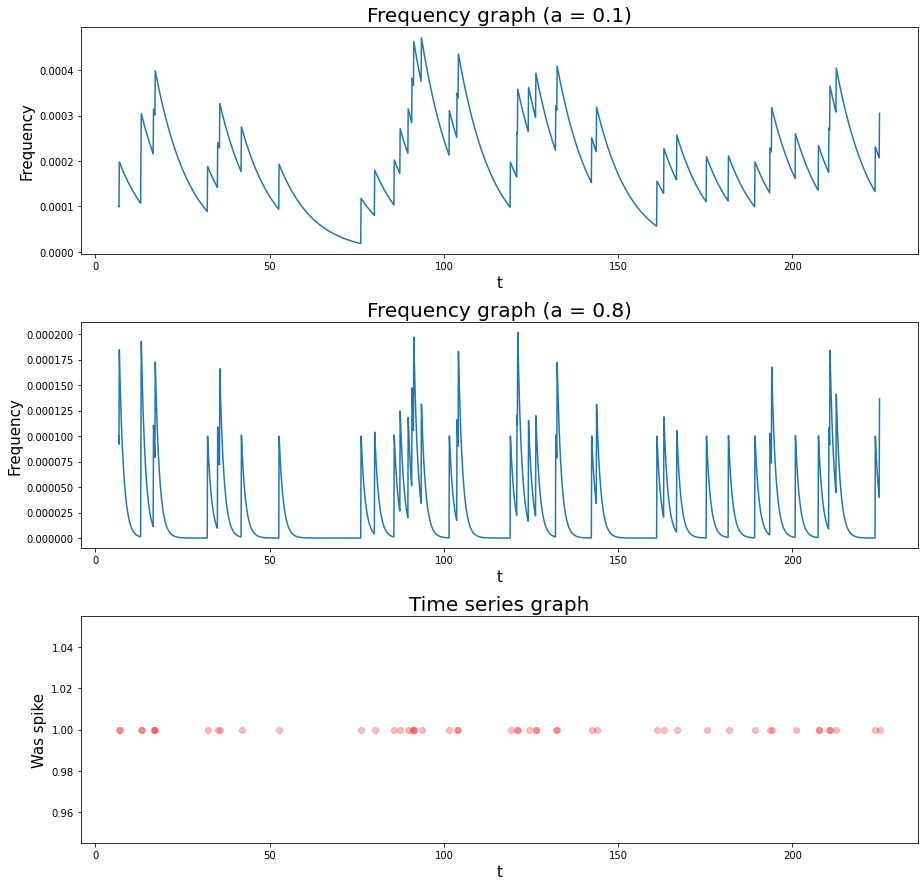

In [230]:
fig = plt.figure(figsize=(15, 15))
#plt.suptitle("a = 0.8, b = 0.001", fontsize = 25)
plt.subplots_adjust(hspace=0.3)

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)


ax1.plot(t, Inhibitory_freq[1:])
ax1.set_title('Frequency graph (a = 0.1)', fontsize = 20)
ax1.set_ylabel('Frequency', fontsize = 15)
ax1.set_xlabel('t', fontsize = 15)

ax2.plot(t, Inhibitory_freq8[1:])
ax2.set_title('Frequency graph (a = 0.8)', fontsize = 20)
ax2.set_ylabel('Frequency', fontsize = 15)
ax2.set_xlabel('t', fontsize = 15)


ax3.plot(Freq_plot_data, [1] * len(Freq_plot_data), 'ro', alpha = 0.25)
ax3.set_title('Time series graph', fontsize = 20)
ax3.set_ylabel('Was spike', fontsize = 15)
ax3.set_xlabel('t', fontsize = 15)

plt.show()

## 5 Сравниваем данные на Random Forest

### Разобьем данные на выборки

In [239]:
test_part = 0.25
Inhibitory_test_type_size = (Inhibitory_neuron_type_size * test_part).astype(int)
Excitatory_test_type_size = (Excitatory_neuron_type_size * test_part).astype(int)

Inhibitory_test_indexes = []
Excitatory_test_indexes = []

for i in range(n_animals) :
  Inhibitory_test_indexes.append(random.sample([i for i in range(Inhibitory_neuron_type_size[i])], Inhibitory_test_type_size[i]))

for i in range(n_animals) :
  Excitatory_test_indexes.append(random.sample([i for i in range(Excitatory_neuron_type_size[i])], Excitatory_test_type_size[i]))

#### Подготовим все данные

Частотные, a = 0.1, минимальный набор признаков

In [240]:
Inhibitory_feature_freq_minimal_01_test = pd.DataFrame()
Inhibitory_feature_freq_minimal_01_train = pd.DataFrame()

for i in range(n_animals) :
  for k in range(len(Inhibitory_feature_freq_minimal_01[i])) :
    if k in Inhibitory_test_indexes[i] :
      Inhibitory_feature_freq_minimal_01_test = pd.concat([Inhibitory_feature_freq_minimal_01_test,
                                                        pd.DataFrame([Inhibitory_feature_freq_minimal_01[i].iloc[k]])])
    else :
      Inhibitory_feature_freq_minimal_01_train = pd.concat([Inhibitory_feature_freq_minimal_01_train,
                                                         pd.DataFrame([Inhibitory_feature_freq_minimal_01[i].iloc[k]])])
      
Excitatory_feature_freq_minimal_01_test = pd.DataFrame()
Excitatory_feature_freq_minimal_01_train = pd.DataFrame()

for i in range(n_animals) :
  for k in range(len(Excitatory_feature_freq_minimal_01[i])) :
    if k in Excitatory_test_indexes[i] :
      Excitatory_feature_freq_minimal_01_test = pd.concat([Excitatory_feature_freq_minimal_01_test,
                                                        pd.DataFrame([Excitatory_feature_freq_minimal_01[i].iloc[k]])])
    else :
      Excitatory_feature_freq_minimal_01_train = pd.concat([Excitatory_feature_freq_minimal_01_train,
                                                         pd.DataFrame([Excitatory_feature_freq_minimal_01[i].iloc[k]])])

Частотные, a = 0.8, минимальный набор признаков

In [241]:
Inhibitory_feature_freq_minimal_test = pd.DataFrame()
Inhibitory_feature_freq_minimal_train = pd.DataFrame()

for i in range(n_animals) :
  for k in range(len(Inhibitory_feature_freq_minimal[i])) :
    if k in Inhibitory_test_indexes[i] :
      Inhibitory_feature_freq_minimal_test = pd.concat([Inhibitory_feature_freq_minimal_test,
                                                        pd.DataFrame([Inhibitory_feature_freq_minimal[i].iloc[k]])])
    else :
      Inhibitory_feature_freq_minimal_train = pd.concat([Inhibitory_feature_freq_minimal_train,
                                                         pd.DataFrame([Inhibitory_feature_freq_minimal[i].iloc[k]])])
      
Excitatory_feature_freq_minimal_test = pd.DataFrame()
Excitatory_feature_freq_minimal_train = pd.DataFrame()

for i in range(n_animals) :
  for k in range(len(Excitatory_feature_freq_minimal[i])) :
    if k in Excitatory_test_indexes[i] :
      Excitatory_feature_freq_minimal_test = pd.concat([Excitatory_feature_freq_minimal_test,
                                                        pd.DataFrame([Excitatory_feature_freq_minimal[i].iloc[k]])])
    else :
      Excitatory_feature_freq_minimal_train = pd.concat([Excitatory_feature_freq_minimal_train,
                                                         pd.DataFrame([Excitatory_feature_freq_minimal[i].iloc[k]])])

Частотные, a = 0.1, полный набор признаков

In [242]:
Inhibitory_feature_freq_01_test = pd.DataFrame()
Inhibitory_feature_freq_01_train = pd.DataFrame()

for i in range(n_animals) :
  for k in range(len(Inhibitory_feature_freq_01[i])) :
    if k in Inhibitory_test_indexes[i] :
      Inhibitory_feature_freq_01_test = pd.concat([Inhibitory_feature_freq_01_test,
                                                        pd.DataFrame([Inhibitory_feature_freq_01[i].iloc[k]])])
    else :
      Inhibitory_feature_freq_01_train = pd.concat([Inhibitory_feature_freq_01_train,
                                                         pd.DataFrame([Inhibitory_feature_freq_01[i].iloc[k]])])
      
Excitatory_feature_freq_01_test = pd.DataFrame()
Excitatory_feature_freq_01_train = pd.DataFrame()

for i in range(n_animals) :
  for k in range(len(Excitatory_feature_freq_01[i])) :
    if k in Excitatory_test_indexes[i] :
      Excitatory_feature_freq_01_test = pd.concat([Excitatory_feature_freq_01_test,
                                                        pd.DataFrame([Excitatory_feature_freq_01[i].iloc[k]])])
    else :
      Excitatory_feature_freq_01_train = pd.concat([Excitatory_feature_freq_01_train,
                                                         pd.DataFrame([Excitatory_feature_freq_01[i].iloc[k]])])

Частотные, a = 0.8, Полный набор признаков

In [243]:
Inhibitory_feature_freq_test = pd.DataFrame()
Inhibitory_feature_freq_train = pd.DataFrame()

for i in range(n_animals) :
  for k in range(len(Inhibitory_feature_freq[i])) :
    if k in Inhibitory_test_indexes[i] :
      Inhibitory_feature_freq_test = pd.concat([Inhibitory_feature_freq_test,
                                                pd.DataFrame([Inhibitory_feature_freq[i].iloc[k]])])
    else :
      Inhibitory_feature_freq_train = pd.concat([Inhibitory_feature_freq_train,
                                                 pd.DataFrame([Inhibitory_feature_freq[i].iloc[k]])])
      
Excitatory_feature_freq_test = pd.DataFrame()
Excitatory_feature_freq_train = pd.DataFrame()

for i in range(n_animals) :
  for k in range(len(Excitatory_feature_freq[i])) :
    if k in Excitatory_test_indexes[i] :
      Excitatory_feature_freq_test = pd.concat([Excitatory_feature_freq_test,
                                                pd.DataFrame([Excitatory_feature_freq[i].iloc[k]])])
    else :
      Excitatory_feature_freq_train = pd.concat([Excitatory_feature_freq_train,
                                                 pd.DataFrame([Excitatory_feature_freq[i].iloc[k]])])

ISI, минимальный набор признаков

In [244]:
Inhibitory_feature_ISI_minimal_test = pd.DataFrame()
Inhibitory_feature_ISI_minimal_train = pd.DataFrame()

for i in range(n_animals) :
  for k in range(len(Inhibitory_feature_freq_minimal[i])) :
    if k in Inhibitory_test_indexes[i] :
      Inhibitory_feature_ISI_minimal_test = pd.concat([Inhibitory_feature_ISI_minimal_test,
                                                        pd.DataFrame([Inhibitory_feature_ISI_minimal[i].iloc[k]])])
    else :
      Inhibitory_feature_ISI_minimal_train = pd.concat([Inhibitory_feature_ISI_minimal_train,
                                                         pd.DataFrame([Inhibitory_feature_ISI_minimal[i].iloc[k]])])
      
Excitatory_feature_ISI_minimal_test = pd.DataFrame()
Excitatory_feature_ISI_minimal_train = pd.DataFrame()

for i in range(n_animals) :
  for k in range(len(Excitatory_feature_ISI_minimal[i])) :
    if k in Excitatory_test_indexes[i] :
      Excitatory_feature_ISI_minimal_test = pd.concat([Excitatory_feature_ISI_minimal_test,
                                                        pd.DataFrame([Excitatory_feature_ISI_minimal[i].iloc[k]])])
    else :
      Excitatory_feature_ISI_minimal_train = pd.concat([Excitatory_feature_ISI_minimal_train,
                                                         pd.DataFrame([Excitatory_feature_ISI_minimal[i].iloc[k]])])

ISI, полный набор признаков

In [245]:
Inhibitory_feature_ISI_test = pd.DataFrame()
Inhibitory_feature_ISI_train = pd.DataFrame()

for i in range(n_animals) :
  for k in range(len(Inhibitory_feature_freq[i])) :
    if k in Inhibitory_test_indexes[i] :
      Inhibitory_feature_ISI_test = pd.concat([Inhibitory_feature_ISI_test,
                                               pd.DataFrame([Inhibitory_feature_ISI[i].iloc[k]])])
    else :
      Inhibitory_feature_ISI_train = pd.concat([Inhibitory_feature_ISI_train,
                                                pd.DataFrame([Inhibitory_feature_ISI[i].iloc[k]])])
      
Excitatory_feature_ISI_test = pd.DataFrame()
Excitatory_feature_ISI_train = pd.DataFrame()

for i in range(n_animals) :
  for k in range(len(Excitatory_feature_ISI[i])) :
    if k in Excitatory_test_indexes[i] :
      Excitatory_feature_ISI_test = pd.concat([Excitatory_feature_ISI_test,
                                               pd.DataFrame([Excitatory_feature_ISI[i].iloc[k]])])
    else :
      Excitatory_feature_ISI_train = pd.concat([Excitatory_feature_ISI_train,
                                                 pd.DataFrame([Excitatory_feature_ISI[i].iloc[k]])])

### Обучим случайный лес на всех данных

In [246]:
model_1 = Rand_Forest(n_estimators = 100)
reg_1 = model_1.fit(pd.concat([Inhibitory_feature_freq_minimal_01_train, Excitatory_feature_freq_minimal_01_train]),
                  [-1] * len(Inhibitory_feature_freq_minimal_01_train) + [1] * len(Excitatory_feature_freq_minimal_01_train))

model_2 = Rand_Forest(n_estimators = 100)
reg_2 = model_2.fit(pd.concat([Inhibitory_feature_freq_minimal_train, Excitatory_feature_freq_minimal_train]),
                  [-1] * len(Inhibitory_feature_freq_minimal_train) + [1] * len(Excitatory_feature_freq_minimal_train))

model_3 = Rand_Forest(n_estimators = 100)
reg_3 = model_3.fit(pd.concat([Inhibitory_feature_freq_01_train, Excitatory_feature_freq_01_train]),
                  [-1] * len(Inhibitory_feature_freq_01_train) + [1] * len(Excitatory_feature_freq_01_train))

model_4 = Rand_Forest(n_estimators = 100)
reg_4 = model_4.fit(pd.concat([Inhibitory_feature_freq_train, Excitatory_feature_freq_train]),
                  [-1] * len(Inhibitory_feature_freq_train) + [1] * len(Excitatory_feature_freq_train))

model_5 = Rand_Forest(n_estimators = 100)
reg_5 = model_5.fit(pd.concat([Inhibitory_feature_ISI_minimal_train, Excitatory_feature_ISI_minimal_train]),
                  [-1] * len(Inhibitory_feature_ISI_minimal_train) + [1] * len(Excitatory_feature_ISI_minimal_train))

model_6 = Rand_Forest(n_estimators = 100)
reg_6 = model_6.fit(pd.concat([Inhibitory_feature_ISI_train, Excitatory_feature_ISI_train]),
                  [-1] * len(Inhibitory_feature_ISI_train) + [1] * len(Excitatory_feature_ISI_train))

In [248]:
Data_results = pd.DataFrame(np.zeros([6, 2]), columns=["Data","F1 Score"])

In [249]:
y_pred = model_1.predict(pd.concat([Inhibitory_feature_freq_minimal_01_test, Excitatory_feature_freq_minimal_01_test]))
y_test = [-1] * len(Inhibitory_feature_freq_minimal_01_test) + [1] * len(Excitatory_feature_freq_minimal_01_test)
Data_results['Data'].iloc[0] = 'Freq_data, a = 0.1, minimal_feature'
Data_results['F1 Score'].iloc[0] = f1_score(y_test, y_pred)

y_pred = model_2.predict(pd.concat([Inhibitory_feature_freq_minimal_test, Excitatory_feature_freq_minimal_test]))
y_test = [-1] * len(Inhibitory_feature_freq_minimal_test) + [1] * len(Excitatory_feature_freq_minimal_test)
Data_results['Data'].iloc[1] = 'Freq_data, a = 0.8, minimal_feature'
Data_results['F1 Score'].iloc[1] = f1_score(y_test, y_pred)

y_pred = model_3.predict(pd.concat([Inhibitory_feature_freq_01_test, Excitatory_feature_freq_01_test]))
y_test = [-1] * len(Inhibitory_feature_freq_01_test) + [1] * len(Excitatory_feature_freq_01_test)
Data_results['Data'].iloc[2] = 'Freq_data, a = 0.1, all_feature'
Data_results['F1 Score'].iloc[2] = f1_score(y_test, y_pred)

y_pred = model_4.predict(pd.concat([Inhibitory_feature_freq_test, Excitatory_feature_freq_test]))
y_test = [-1] * len(Inhibitory_feature_freq_test) + [1] * len(Excitatory_feature_freq_test)
Data_results['Data'].iloc[3] = 'Freq_data, a = 0.8, all_feature'
Data_results['F1 Score'].iloc[3] = f1_score(y_test, y_pred)

y_pred = model_5.predict(pd.concat([Inhibitory_feature_ISI_minimal_test, Excitatory_feature_ISI_minimal_test]))
y_test = [-1] * len(Inhibitory_feature_ISI_minimal_test) + [1] * len(Excitatory_feature_ISI_minimal_test)
Data_results['Data'].iloc[4] = 'ISI data, minimal_feature'
Data_results['F1 Score'].iloc[4] = f1_score(y_test, y_pred)

y_pred = model_6.predict(pd.concat([Inhibitory_feature_ISI_test, Excitatory_feature_ISI_test]))
y_test = [-1] * len(Inhibitory_feature_ISI_test) + [1] * len(Excitatory_feature_ISI_test)
print(f'F1 score (ISI data, all_feature) = {f1_score(y_test, y_pred)}')
Data_results['Data'].iloc[5] = 'ISI data, all_feature'
Data_results['F1 Score'].iloc[5] = f1_score(y_test, y_pred)

F1 score (ISI data, all_feature) = 0.9696969696969697


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [250]:
Data_results

,Data,F1 Score
0,"Freq_data, a = 0.1, minimal_feature",0.964871
1,"Freq_data, a = 0.8, minimal_feature",0.967290
2,"Freq_data, a = 0.1, all_feature",0.974118
3,"Freq_data, a = 0.8, all_feature",0.978923
4,"ISI data, minimal_feature",0.965035
5,"ISI data, all_feature",0.969697


## 6 Сравнение методов

#### Частотные данные, a = 0.8, минимальный набор признаков

In [125]:
X_test = pd.concat([Inhibitory_feature_freq_minimal_test, Excitatory_feature_freq_minimal_test])
X_train = pd.concat([Inhibitory_feature_freq_minimal_train, Excitatory_feature_freq_minimal_train])

y_test = [-1] * len(Inhibitory_feature_freq_minimal_test) + [1] * len(Excitatory_feature_freq_minimal_test)
y_train = [-1] * len(Inhibitory_feature_freq_minimal_train) + [1] * len(Excitatory_feature_freq_minimal_train)

In [126]:
Freq_results = pd.DataFrame(np.zeros([5, 2]), columns=["Models","F1 Score"])
Freq_confusion = [0] * 5
Freq_roc = [0] * 5

##### KNN(k = 5, p = 1)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

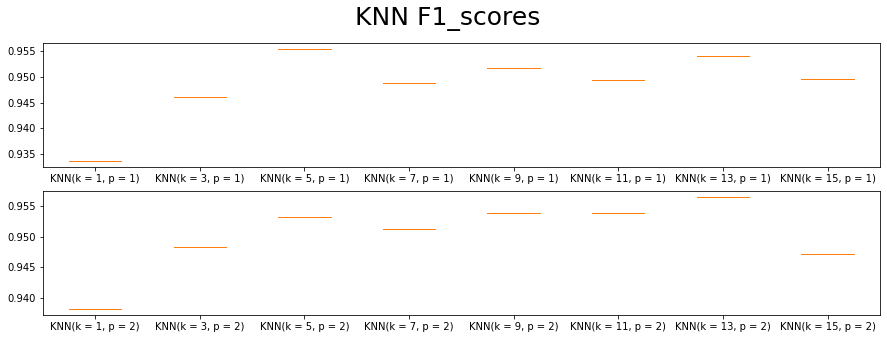

In [127]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("KNN F1_scores", fontsize = 25)
cur_max = 0
cur_index = 0

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 1)
  reg = model.fit(X_train, y_train)
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 1)')
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_roc[cur_index] = [fpr, tpr]
      Freq_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)



ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 2)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 2)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_roc[cur_index] = [fpr, tpr]
      Freq_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Random Forest(n = 34)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


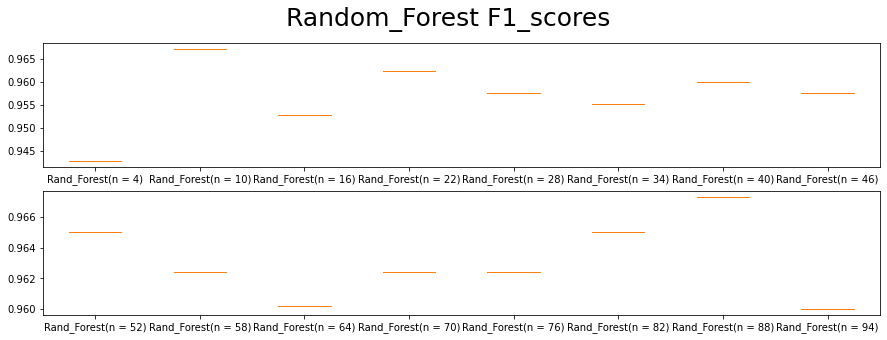

In [128]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("Random_Forest F1_scores", fontsize = 25)
cur_max = 0
cur_index = 1

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_roc[cur_index] = [fpr, tpr]
      Freq_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)


ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_roc[cur_index] = [fpr, tpr]
      Freq_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### LDA(solver = 'svd')

In [129]:
model = LDA()
reg = model.fit(X_train, y_train)

print(f'LDA F_score = {f1_score(y_test, model.predict(X_test))}')

cur_index = 2
Freq_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
Freq_roc[cur_index] = [fpr, tpr]
Freq_results["Models"].iloc[cur_index] = "Linear_Discriminant_Analysis"
Freq_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

LDA F_score = 0.955503512880562


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##### GBC(n = 22)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


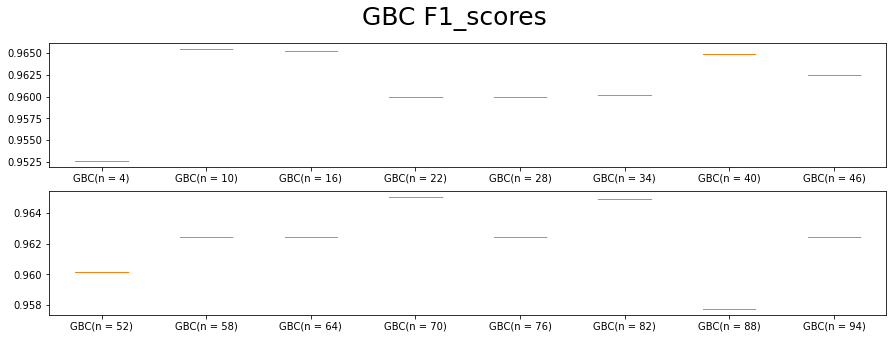

In [130]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("GBC F1_scores", fontsize = 25)
cur_max = 0
cur_index = 3

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = GBC(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_roc[cur_index] = [fpr, tpr]
      Freq_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)


ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_roc[cur_index] = [fpr, tpr]
      Freq_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Naive Bayes

In [131]:
model = GaussianNB()
reg = model.fit(X_train, y_train)

print(f'Naive Bayes F_score = {f1_score(y_test, model.predict(X_test))}')

cur_index = 4
Freq_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
Freq_roc[cur_index] = [fpr, tpr]
Freq_results["Models"].iloc[cur_index] = "Naive_Bayes"
Freq_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

Naive Bayes F_score = 0.9539170506912443


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [132]:
Freq_results

,Models,F1 Score
0,"KNN(k = 13, p = 2)",0.956522
1,Rand_Forest(n = 10),0.967290
2,Linear_Discriminant_Analysis,0.955504
3,GBC(n = 10),0.965517
4,Naive_Bayes,0.953917


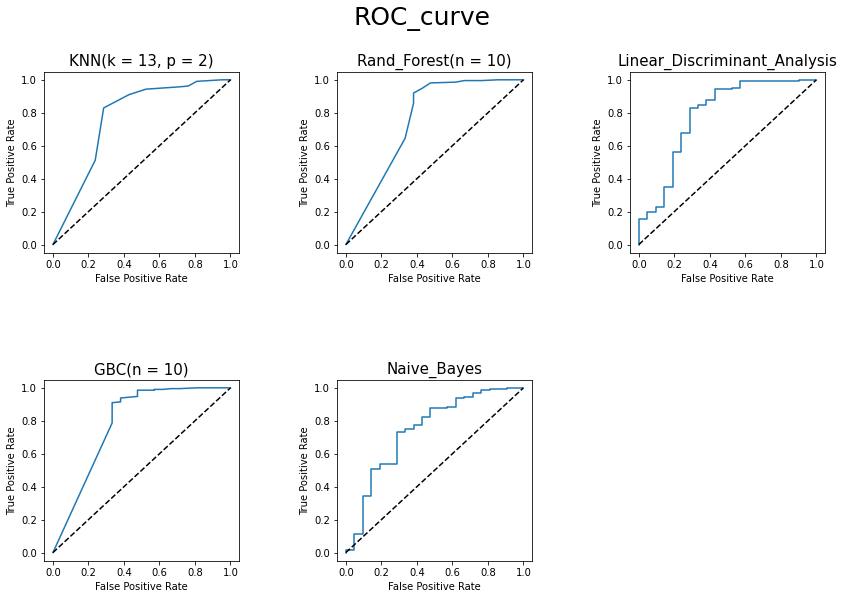

In [133]:
fig = plt.figure(figsize=(14,9))
plt.suptitle("ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(len(Freq_confusion)) :
    ax = fig.add_subplot(2, 3, i + 1)
    ax.plot(Freq_roc[i][0],Freq_roc[i][1])
    ax.set_title(Freq_results['Models'].iloc[i], fontsize = 15)
    ax.set_xlabel('False Positive Rate', fontsize = 10)
    ax.set_ylabel('True Positive Rate', fontsize = 10)
    ax.plot([0, 1], [0, 1], 'k--')

plt.show()

#### ISI данные, минимальный набор признаков

In [278]:
X_test = pd.concat([Inhibitory_feature_ISI_minimal_test, Excitatory_feature_ISI_minimal_test])
X_train = pd.concat([Inhibitory_feature_ISI_minimal_train, Excitatory_feature_ISI_minimal_train])

y_test = [-1] * len(Inhibitory_feature_ISI_minimal_test) + [1] * len(Excitatory_feature_ISI_minimal_test)
y_train = [-1] * len(Inhibitory_feature_ISI_minimal_train) + [1] * len(Excitatory_feature_ISI_minimal_train)

In [279]:
ISI_results = pd.DataFrame(np.zeros([5, 2]), columns=["Models","F1 Score"])
ISI_confusion = [0] * 5
ISI_roc = [0] * 5

##### KNN(k = 5, p = 1)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

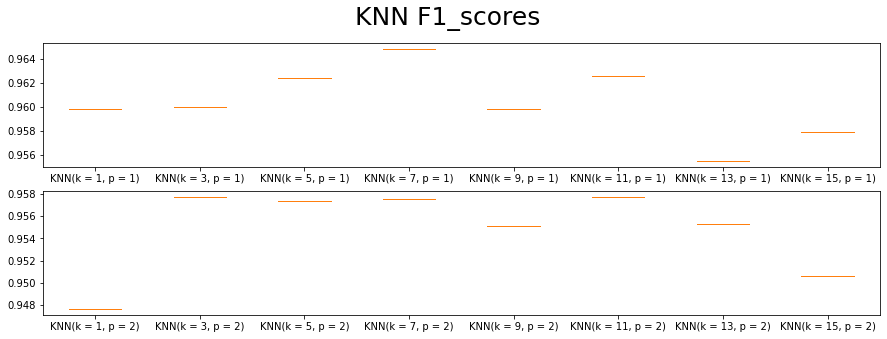

In [280]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("KNN F1_scores", fontsize = 25)
cur_max = 0
cur_index = 0

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 1)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 1)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_roc[cur_index] = [fpr, tpr]
      ISI_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 2)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 2)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_roc[cur_index] = [fpr, tpr]
      ISI_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Random Forest(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

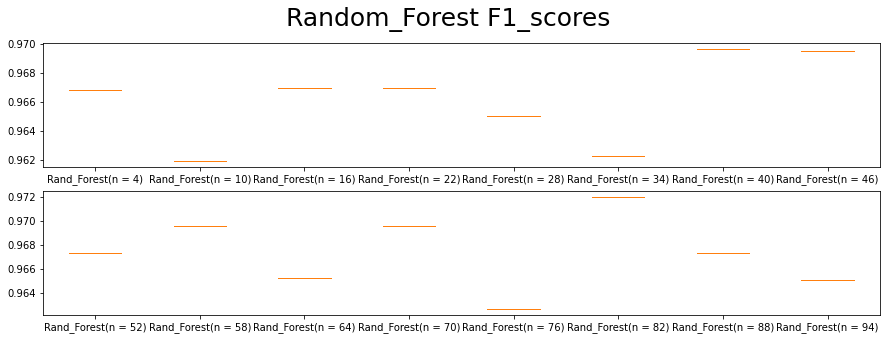

In [281]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("Random_Forest F1_scores", fontsize = 25)
cur_max = 0
cur_index = 1

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_roc[cur_index] = [fpr, tpr]
      ISI_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_roc[cur_index] = [fpr, tpr]
      ISI_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### LDA(solver = 'svd')

In [282]:
model = LDA()
reg = model.fit(X_train, y_train)

print(f'LDA F_score = {f1_score(y_test, model.predict(X_test))}')

cur_index = 2
ISI_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
ISI_roc[cur_index] = [fpr, tpr]
ISI_results["Models"].iloc[cur_index] = "Linear_Discriminant_Analysis"
ISI_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

LDA F_score = 0.9610983981693364


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##### GBC(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

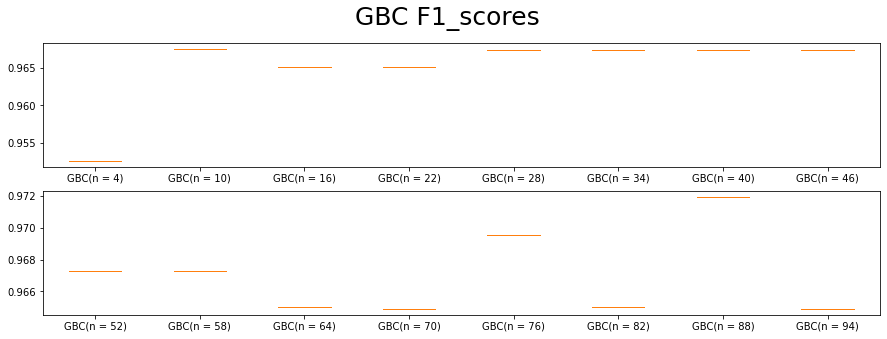

In [283]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("GBC F1_scores", fontsize = 25)
cur_max = 0
cur_index = 3

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = GBC(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_roc[cur_index] = [fpr, tpr]
      ISI_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_roc[cur_index] = [fpr, tpr]
      ISI_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Naive Bayes

In [284]:
model = GaussianNB()
reg = model.fit(X_train, y_train)

print(f'Naive Bayes F_score = {f1_score(y_test, model.predict(X_test))}')

cur_index = 4
ISI_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
ISI_roc[cur_index] = [fpr, tpr]
ISI_results["Models"].iloc[cur_index] = "Naive_Bayes"
ISI_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

Naive Bayes F_score = 0.9541284403669724


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [285]:
ISI_results

,Models,F1 Score
0,"KNN(k = 7, p = 1)",0.964871
1,Rand_Forest(n = 82),0.971963
2,Linear_Discriminant_Analysis,0.961098
3,GBC(n = 88),0.971963
4,Naive_Bayes,0.954128


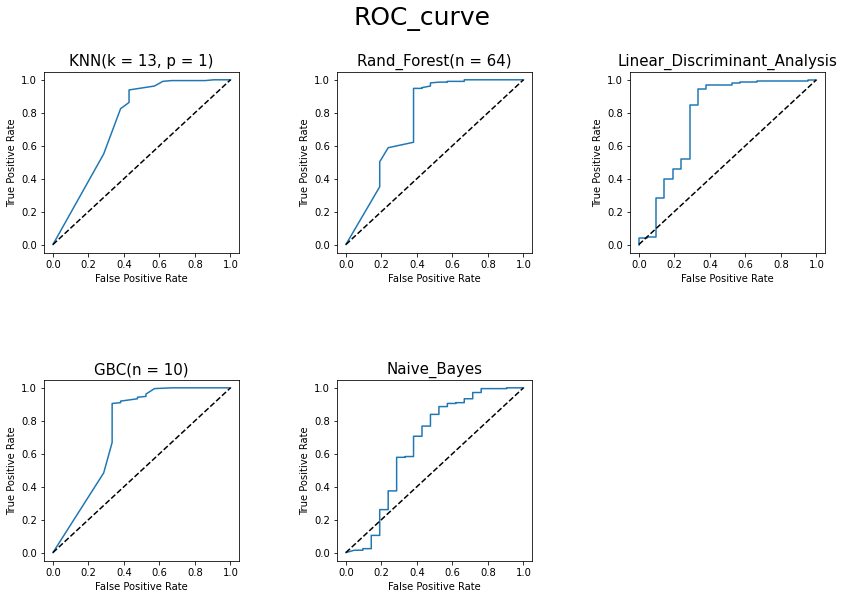

In [142]:
fig = plt.figure(figsize=(14,9))
plt.suptitle("ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(len(ISI_confusion)) :
    ax = fig.add_subplot(2, 3, i + 1)
    ax.plot(ISI_roc[i][0],ISI_roc[i][1])
    ax.set_title(ISI_results['Models'].iloc[i], fontsize = 15)
    ax.set_xlabel('False Positive Rate', fontsize = 10)
    ax.set_ylabel('True Positive Rate', fontsize = 10)
    ax.plot([0, 1], [0, 1], 'k--')

plt.show()

## 3 Балансировка

### RandomUnderSampler

#### Частотные данные

In [260]:
Inhibitory_feature_freq_minimal_undersample = []
Excitatory_feature_freq_minimal_undersample = []
Undersample_animal_size = []
model = RandomUnderSampler()
for animal in range(n_animals) :
    if (Inhibitory_neuron_type_size[animal] == 0 or Excitatory_neuron_type_size[animal] == 0) :
        print("ZERO")
        Inhibitory_feature_freq_minimal_undersample.append([0])
        Excitatory_feature_freq_minimal_undersample.append([0])
        Undersample_animal_size.append(0)
        continue
    print(Inhibitory_neuron_type_size[animal], Excitatory_neuron_type_size[animal])
    x_new, y_new = model.fit_resample(pd.concat([Inhibitory_feature_freq_minimal[animal],
                                                 Excitatory_feature_freq_minimal[animal]]),
                                      [-1] * len(Inhibitory_feature_freq_minimal[animal]) + [1] * len(Excitatory_feature_freq_minimal[animal]))
    min_class = min(Inhibitory_neuron_type_size[animal], Excitatory_neuron_type_size[animal])
    Undersample_animal_size.append(min_class)
    Inhibitory_feature_freq_minimal_undersample.append(x_new[0 : min_class])
    Excitatory_feature_freq_minimal_undersample.append(x_new[min_class : ])
    print(len(x_new), len(y_new), y_new)
Undersample_animal_size = pd.Series(Undersample_animal_size)

11 51
22 22 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
5 24
10 10 [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
6 27
12 12 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
7 43
14 14 [-1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1]
1 34
2 2 [-1, 1]
6 34
12 12 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
13 37
26 26 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
10 51
20 20 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
5 17
10 10 [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
6 60
12 12 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
4 28
8 8 [-1, -1, -1, -1, 1, 1, 1, 1]
1 20
2 2 [-1, 1]
3 33
6 6 [-1, -1, -1, 1, 1, 1]
6 46
12 12 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
5 55
10 10 [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
1 23
2 2 [-1, 1]
4 32
8 8 [-1, -1, -1, -1, 1, 1, 1, 1]
ZERO
ZERO
6 40
12 12 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
1 25
2 2 [-1, 1]
4 89
8 8 [-1, -1, -1, -1, 1, 1, 1, 1]
2 25
4 4 [-1, -1, 1, 1]
9 42

In [261]:
test_part = 0.25
Inhibitory_test_type_size = (Undersample_animal_size * test_part).astype(int)
Excitatory_test_type_size = (Undersample_animal_size * test_part).astype(int)

Inhibitory_test_indexes = []
Excitatory_test_indexes = []

for i in range(n_animals) :
    Inhibitory_test_indexes.append(random.sample([i for i in range(Undersample_animal_size[i])], Inhibitory_test_type_size[i]))

for i in range(n_animals) :
    Excitatory_test_indexes.append(random.sample([i for i in range(Undersample_animal_size[i])], Excitatory_test_type_size[i]))

In [262]:
Inhibitory_feature_freq_minimal_undersample_test = pd.DataFrame()
Inhibitory_feature_freq_minimal_undersample_train = pd.DataFrame()

for i in range(n_animals) :
    if (Undersample_animal_size[i] == 0) :
        continue
    for k in range(len(Inhibitory_feature_freq_minimal_undersample[i])) :
        if k in Inhibitory_test_indexes[i] :
            Inhibitory_feature_freq_minimal_undersample_test = pd.concat([Inhibitory_feature_freq_minimal_undersample_test,
                                                              pd.DataFrame([Inhibitory_feature_freq_minimal_undersample[i].iloc[k]])])
        else :
            Inhibitory_feature_freq_minimal_undersample_train = pd.concat([Inhibitory_feature_freq_minimal_undersample_train,
                                                               pd.DataFrame([Inhibitory_feature_freq_minimal_undersample[i].iloc[k]])])

Excitatory_feature_freq_minimal_undersample_test = pd.DataFrame()
Excitatory_feature_freq_minimal_undersample_train = pd.DataFrame()

for i in range(n_animals) :
    if (Undersample_animal_size[i] == 0) :
        continue
    for k in range(len(Excitatory_feature_freq_minimal_undersample[i])) :
        if k in Excitatory_test_indexes[i] :
            Excitatory_feature_freq_minimal_undersample_test = pd.concat([Excitatory_feature_freq_minimal_undersample_test,
                                                              pd.DataFrame([Excitatory_feature_freq_minimal_undersample[i].iloc[k]])])
        else :
            Excitatory_feature_freq_minimal_undersample_train = pd.concat([Excitatory_feature_freq_minimal_undersample_train,
                                                               pd.DataFrame([Excitatory_feature_freq_minimal_undersample[i].iloc[k]])])

In [263]:
X_test = pd.concat([Inhibitory_feature_freq_minimal_undersample_test, Excitatory_feature_freq_minimal_undersample_test])
X_train = pd.concat([Inhibitory_feature_freq_minimal_undersample_train, Excitatory_feature_freq_minimal_undersample_train])

y_test = [-1] * len(Inhibitory_feature_freq_minimal_undersample_test) + [1] * len(Excitatory_feature_freq_minimal_undersample_test)
y_train = [-1] * len(Inhibitory_feature_freq_minimal_undersample_train) + [1] * len(Excitatory_feature_freq_minimal_undersample_train)

In [264]:
Freq_undersample_results = pd.DataFrame(np.zeros([5, 2]), columns=["Models","F1 Score"])
Freq_undersample_confusion = [0] * 5
Freq_undersample_roc = [0] * 5

##### KNN(k = 5, p = 1)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


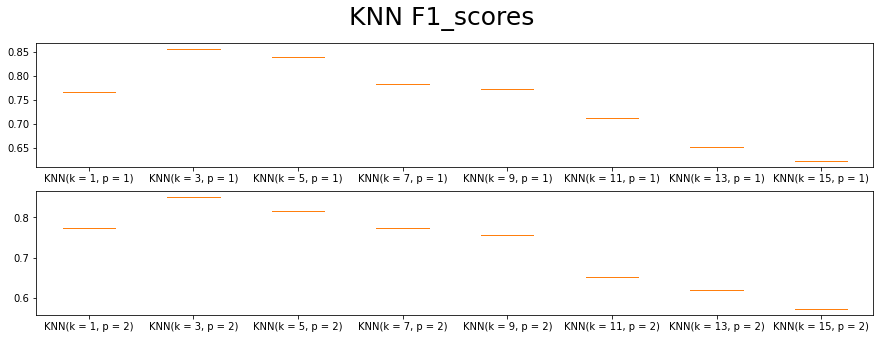

In [265]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("KNN F1_scores", fontsize = 25)
cur_max = 0
cur_index = 0

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 1)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 1)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_undersample_roc[cur_index] = [fpr, tpr]
      Freq_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]

ax.boxplot(fscores_array, labels = names_array)


ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 2)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 2)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_undersample_roc[cur_index] = [fpr, tpr]
      Freq_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Random Forest(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

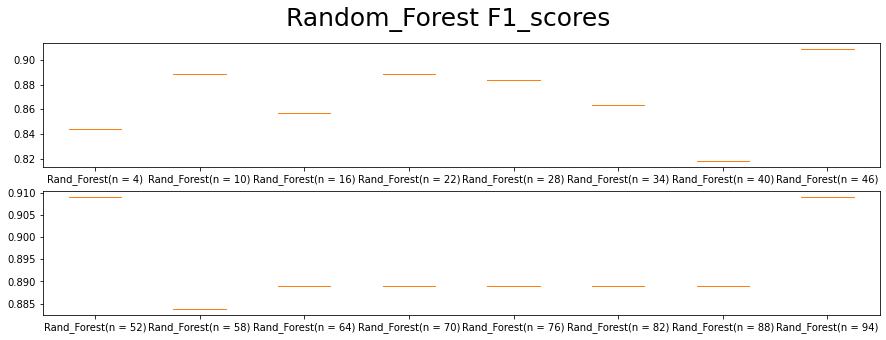

In [266]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("Random_Forest F1_scores", fontsize = 25)
cur_max = 0
cur_index = 1

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_undersample_roc[cur_index] = [fpr, tpr]
      Freq_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)


ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_undersample_roc[cur_index] = [fpr, tpr]
      Freq_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### LDA(solver = 'svd')

In [267]:
model = LDA()
reg = model.fit(X_train, y_train)

print(f'LDA F_score = {f1_score(y_test, model.predict(X_test))}')


cur_index = 2
Freq_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
Freq_undersample_roc[cur_index] = [fpr, tpr]
Freq_undersample_results["Models"].iloc[cur_index] = "Linear_Discriminant_Analysis"
Freq_undersample_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

LDA F_score = 0.888888888888889


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##### GBC(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

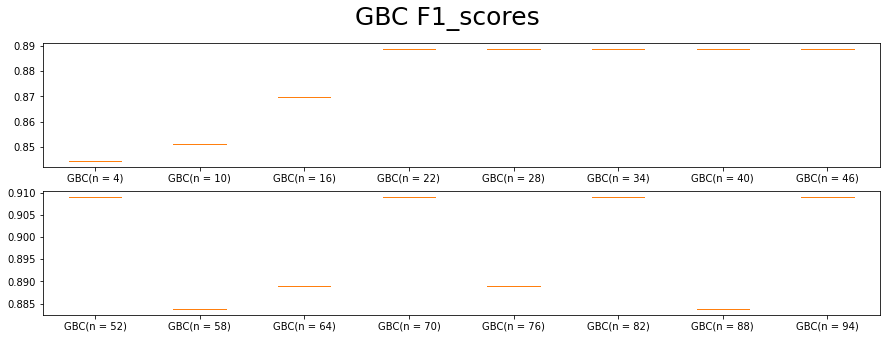

In [268]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("GBC F1_scores", fontsize = 25)
cur_max = 0
cur_index = 3

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = GBC(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_undersample_roc[cur_index] = [fpr, tpr]
      Freq_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_undersample_roc[cur_index] = [fpr, tpr]
      Freq_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Naive Bayes

In [269]:
model = GaussianNB()
reg = model.fit(X_train, y_train)

print(f'Naive Bayes F_score = {f1_score(y_test, model.predict(X_test))}')




cur_index = 4
Freq_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
Freq_undersample_roc[cur_index] = [fpr, tpr]
Freq_undersample_results["Models"].iloc[cur_index] = "Naive_Bayes"
Freq_undersample_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

Naive Bayes F_score = 0.7924528301886793


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [270]:
Freq_undersample_results

,Models,F1 Score
0,"KNN(k = 3, p = 1)",0.857143
1,Rand_Forest(n = 46),0.909091
2,Linear_Discriminant_Analysis,0.888889
3,GBC(n = 52),0.909091
4,Naive_Bayes,0.792453


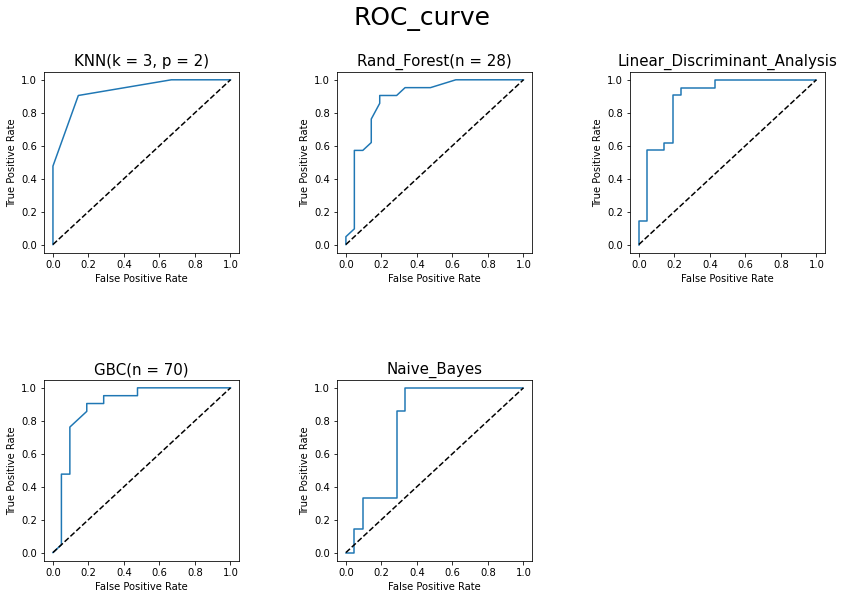

In [154]:
fig = plt.figure(figsize=(14,9))
plt.suptitle("ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(len(Freq_undersample_confusion)) :
    ax = fig.add_subplot(2, 3, i + 1)
    ax.plot(Freq_undersample_roc[i][0],Freq_undersample_roc[i][1])
    ax.set_title(Freq_undersample_results['Models'].iloc[i], fontsize = 15)
    ax.set_xlabel('False Positive Rate', fontsize = 10)
    ax.set_ylabel('True Positive Rate', fontsize = 10)
    ax.plot([0, 1], [0, 1], 'k--')

plt.show()

#### ISI

In [155]:
Inhibitory_feature_ISI_minimal_undersample = []
Excitatory_feature_ISI_minimal_undersample = []
Undersample_animal_size = []
model = RandomUnderSampler()
for animal in range(n_animals) :
    if (Inhibitory_neuron_type_size[animal] == 0 or Excitatory_neuron_type_size[animal] == 0) :
        print("ZERO")
        Inhibitory_feature_ISI_minimal_undersample.append([0])
        Excitatory_feature_ISI_minimal_undersample.append([0])
        Undersample_animal_size.append(0)
        continue
    print(Inhibitory_neuron_type_size[animal], Excitatory_neuron_type_size[animal])
    x_new, y_new = model.fit_resample(pd.concat([Inhibitory_feature_ISI_minimal[animal],
                                                 Excitatory_feature_ISI_minimal[animal]]),
                                      [-1] * len(Inhibitory_feature_ISI_minimal[animal]) + [1] * len(Excitatory_feature_ISI_minimal[animal]))
    min_class = min(Inhibitory_neuron_type_size[animal], Excitatory_neuron_type_size[animal])
    Undersample_animal_size.append(min_class)
    Inhibitory_feature_ISI_minimal_undersample.append(x_new[0 : min_class])
    Excitatory_feature_ISI_minimal_undersample.append(x_new[min_class : ])
    print(len(x_new), len(y_new), y_new)
Undersample_animal_size = pd.Series(Undersample_animal_size)

11 51
22 22 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
5 24
10 10 [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
6 27
12 12 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
7 43
14 14 [-1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1]
1 34
2 2 [-1, 1]
6 34
12 12 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
13 37
26 26 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
10 51
20 20 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
5 17
10 10 [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
6 60
12 12 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
4 28
8 8 [-1, -1, -1, -1, 1, 1, 1, 1]
1 20
2 2 [-1, 1]
3 33
6 6 [-1, -1, -1, 1, 1, 1]
6 46
12 12 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
5 55
10 10 [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
1 23
2 2 [-1, 1]
4 32
8 8 [-1, -1, -1, -1, 1, 1, 1, 1]
ZERO
ZERO
6 40
12 12 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
1 25
2 2 [-1, 1]
4 89
8 8 [-1, -1, -1, -1, 1, 1, 1, 1]
2 25
4 4 [-1, -1, 1, 1]
9 42

In [156]:
test_part = 0.25
Inhibitory_test_type_size = (Undersample_animal_size * test_part).astype(int)
Excitatory_test_type_size = (Undersample_animal_size * test_part).astype(int)

Inhibitory_test_indexes = []
Excitatory_test_indexes = []

for i in range(n_animals) :
    Inhibitory_test_indexes.append(random.sample([i for i in range(Undersample_animal_size[i])], Inhibitory_test_type_size[i]))

for i in range(n_animals) :
    Excitatory_test_indexes.append(random.sample([i for i in range(Undersample_animal_size[i])], Excitatory_test_type_size[i]))

In [157]:
Inhibitory_feature_ISI_minimal_undersample_test = pd.DataFrame()
Inhibitory_feature_ISI_minimal_undersample_train = pd.DataFrame()

for i in range(n_animals) :
    if (Undersample_animal_size[i] == 0) :
        continue
    for k in range(len(Inhibitory_feature_ISI_minimal_undersample[i])) :
        if k in Inhibitory_test_indexes[i] :
            Inhibitory_feature_ISI_minimal_undersample_test = pd.concat([Inhibitory_feature_ISI_minimal_undersample_test,
                                                              pd.DataFrame([Inhibitory_feature_ISI_minimal_undersample[i].iloc[k]])])
        else :
            Inhibitory_feature_ISI_minimal_undersample_train = pd.concat([Inhibitory_feature_ISI_minimal_undersample_train,
                                                               pd.DataFrame([Inhibitory_feature_ISI_minimal_undersample[i].iloc[k]])])

Excitatory_feature_ISI_minimal_undersample_test = pd.DataFrame()
Excitatory_feature_ISI_minimal_undersample_train = pd.DataFrame()

for i in range(n_animals) :
    if (Undersample_animal_size[i] == 0) :
        continue
    for k in range(len(Excitatory_feature_ISI_minimal_undersample[i])) :
        if k in Excitatory_test_indexes[i] :
            Excitatory_feature_ISI_minimal_undersample_test = pd.concat([Excitatory_feature_ISI_minimal_undersample_test,
                                                              pd.DataFrame([Excitatory_feature_ISI_minimal_undersample[i].iloc[k]])])
        else :
            Excitatory_feature_ISI_minimal_undersample_train = pd.concat([Excitatory_feature_ISI_minimal_undersample_train,
                                                               pd.DataFrame([Excitatory_feature_ISI_minimal_undersample[i].iloc[k]])])

In [158]:
X_test = pd.concat([Inhibitory_feature_ISI_minimal_undersample_test, Excitatory_feature_ISI_minimal_undersample_test])
X_train = pd.concat([Inhibitory_feature_ISI_minimal_undersample_train, Excitatory_feature_ISI_minimal_undersample_train])

y_test = [-1] * len(Inhibitory_feature_ISI_minimal_undersample_test) + [1] * len(Excitatory_feature_ISI_minimal_undersample_test)
y_train = [-1] * len(Inhibitory_feature_ISI_minimal_undersample_train) + [1] * len(Excitatory_feature_ISI_minimal_undersample_train)

In [159]:
ISI_undersample_results = pd.DataFrame(np.zeros([5, 2]), columns=["Models","F1 Score"])
ISI_undersample_confusion = [0] * 5
ISI_undersample_roc = [0] * 5

##### KNN(k = 5, p = 1)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

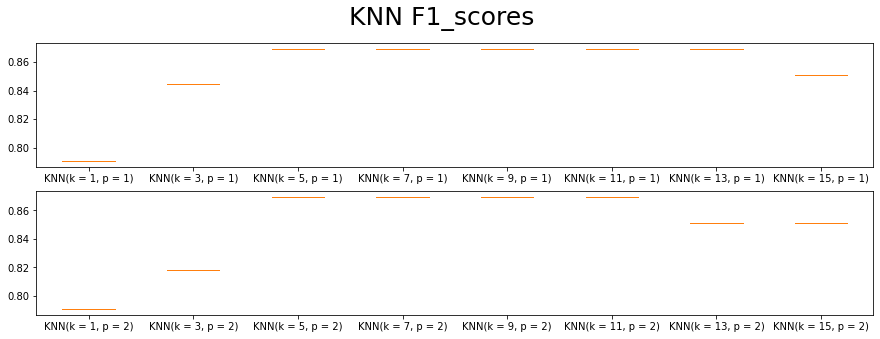

In [160]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("KNN F1_scores", fontsize = 25)
cur_max = 0
cur_index = 0

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 1)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 1)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_undersample_roc[cur_index] = [fpr, tpr]
      ISI_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)


ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 2)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 2)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_undersample_roc[cur_index] = [fpr, tpr]
      ISI_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Random Forest(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

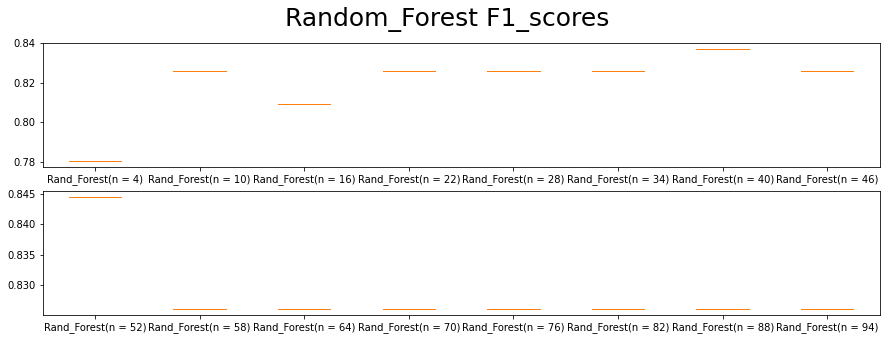

In [161]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("Random_Forest F1_scores", fontsize = 25)
cur_max = 0
cur_index = 1

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_undersample_roc[cur_index] = [fpr, tpr]
      ISI_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)


ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_undersample_roc[cur_index] = [fpr, tpr]
      ISI_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### LDA(solver = 'svd')

In [162]:
model = LDA()
reg = model.fit(X_train, y_train)

print(f'LDA F_score = {f1_score(y_test, model.predict(X_test))}')

cur_index = 2
ISI_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
ISI_undersample_roc[cur_index] = [fpr, tpr]
ISI_undersample_results["Models"].iloc[cur_index] = "Linear_Discriminant_Analysis"
ISI_undersample_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

LDA F_score = 0.8260869565217391


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##### GBC(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


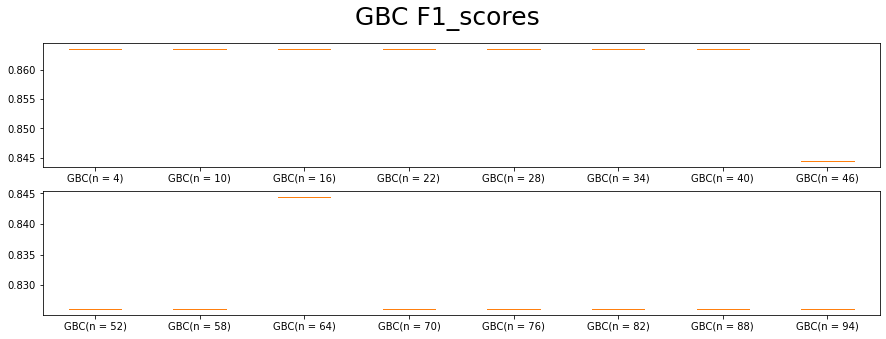

In [163]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("GBC F1_scores", fontsize = 25)
cur_max = 0
cur_index = 3

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = GBC(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_undersample_roc[cur_index] = [fpr, tpr]
      ISI_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_undersample_roc[cur_index] = [fpr, tpr]
      ISI_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Naive Bayes

In [164]:
model = GaussianNB()
reg = model.fit(X_train, y_train)

print(f'Naive Bayes F_score = {f1_score(y_test, model.predict(X_test))}')


cur_index = 4
ISI_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
ISI_undersample_roc[cur_index] = [fpr, tpr]
ISI_undersample_results["Models"].iloc[cur_index] = "Naive_Bayes"
ISI_undersample_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

Naive Bayes F_score = 0.7272727272727274


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [165]:
ISI_undersample_results

,Models,F1 Score
0,"KNN(k = 5, p = 1)",0.869565
1,Rand_Forest(n = 52),0.844444
2,Linear_Discriminant_Analysis,0.826087
3,GBC(n = 4),0.863636
4,Naive_Bayes,0.727273


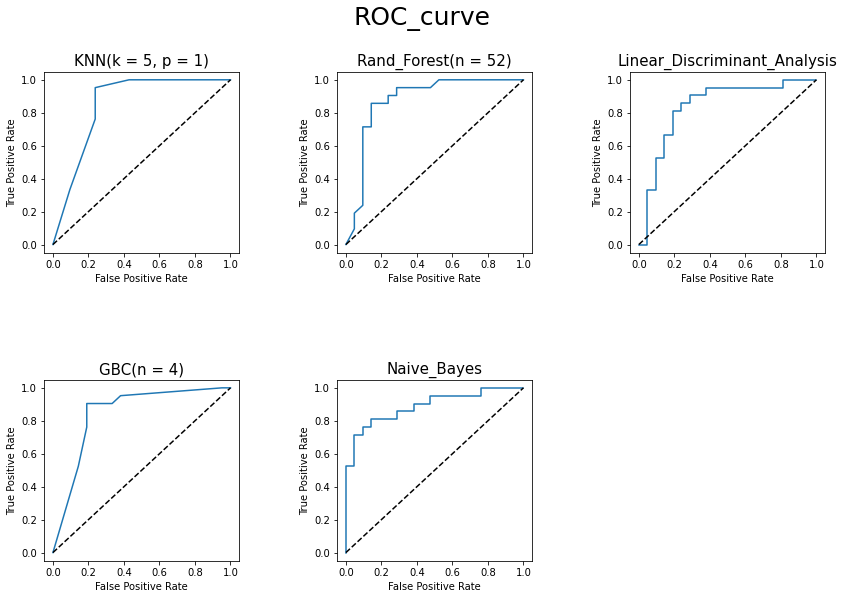

In [166]:
fig = plt.figure(figsize=(14,9))
plt.suptitle("ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(len(ISI_undersample_confusion)) :
    ax = fig.add_subplot(2, 3, i + 1)
    ax.plot(ISI_undersample_roc[i][0],ISI_undersample_roc[i][1])
    ax.set_title(ISI_undersample_results['Models'].iloc[i], fontsize = 15)
    ax.set_xlabel('False Positive Rate', fontsize = 10)
    ax.set_ylabel('True Positive Rate', fontsize = 10)
    ax.plot([0, 1], [0, 1], 'k--')

plt.show()

### Smote

#### Частотные данные

In [167]:
Inhibitory_feature_freq_minimal_smote = []
Excitatory_feature_freq_minimal_smote = []
smote_animal_size = []
for animal in range(n_animals) :
    if (Inhibitory_neuron_type_size[animal] in [0, 1] or Excitatory_neuron_type_size[animal] in [0, 1]) :
        print("ZERO")
        Inhibitory_feature_freq_minimal_smote.append([0])
        Excitatory_feature_freq_minimal_smote.append([0])
        smote_animal_size.append(0)
        continue
    print(Inhibitory_neuron_type_size[animal], Excitatory_neuron_type_size[animal])
    min_class = min(Inhibitory_neuron_type_size[animal], Excitatory_neuron_type_size[animal])
    x_new, y_new = SMOTE(k_neighbors=min(min_class - 1, 5)).fit_resample(pd.concat([Inhibitory_feature_freq_minimal[animal],
                                                 Excitatory_feature_freq_minimal[animal]]),
                                      [-1] * len(Inhibitory_feature_freq_minimal[animal]) + [1] * len(Excitatory_feature_freq_minimal[animal]))

    smote_animal_size.append(min_class)
    Inhibitory_feature_freq_minimal_smote.append(x_new[pd.Series(y_new) == -1])
    Excitatory_feature_freq_minimal_smote.append(x_new[pd.Series(y_new) == 1])
    print(len(x_new), len(y_new), y_new)
smote_animal_size = pd.Series(smote_animal_size)

11 51
102 102 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
5 24
48 48 [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
6 27
54 54 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
7 43
86 86 [-1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

In [168]:
test_part = 0.25
Inhibitory_test_type_size = (smote_animal_size * test_part).astype(int)
Excitatory_test_type_size = (smote_animal_size * test_part).astype(int)

Inhibitory_test_indexes = []
Excitatory_test_indexes = []

for i in range(n_animals) :
    Inhibitory_test_indexes.append(random.sample([i for i in range(smote_animal_size[i])], Inhibitory_test_type_size[i]))

for i in range(n_animals) :
    Excitatory_test_indexes.append(random.sample([i for i in range(smote_animal_size[i])], Excitatory_test_type_size[i]))

In [169]:
Inhibitory_feature_freq_minimal_smote_test = pd.DataFrame()
Inhibitory_feature_freq_minimal_smote_train = pd.DataFrame()

for i in range(n_animals) :
    if (smote_animal_size[i] == 0) :
        continue
    for k in range(len(Inhibitory_feature_freq_minimal_smote[i])) :
        if k in Inhibitory_test_indexes[i] :
            Inhibitory_feature_freq_minimal_smote_test = pd.concat([Inhibitory_feature_freq_minimal_smote_test,
                                                              pd.DataFrame([Inhibitory_feature_freq_minimal_smote[i].iloc[k]])])
        else :
            Inhibitory_feature_freq_minimal_smote_train = pd.concat([Inhibitory_feature_freq_minimal_smote_train,
                                                               pd.DataFrame([Inhibitory_feature_freq_minimal_smote[i].iloc[k]])])

Excitatory_feature_freq_minimal_smote_test = pd.DataFrame()
Excitatory_feature_freq_minimal_smote_train = pd.DataFrame()

for i in range(n_animals) :
    if (smote_animal_size[i] == 0) :
        continue
    for k in range(len(Excitatory_feature_freq_minimal_smote[i])) :
        if k in Excitatory_test_indexes[i] :
            Excitatory_feature_freq_minimal_smote_test = pd.concat([Excitatory_feature_freq_minimal_smote_test,
                                                              pd.DataFrame([Excitatory_feature_freq_minimal_smote[i].iloc[k]])])
        else :
            Excitatory_feature_freq_minimal_smote_train = pd.concat([Excitatory_feature_freq_minimal_smote_train,
                                                               pd.DataFrame([Excitatory_feature_freq_minimal_smote[i].iloc[k]])])

In [170]:
X_test = pd.concat([Inhibitory_feature_freq_minimal_smote_test, Excitatory_feature_freq_minimal_smote_test])
X_train = pd.concat([Inhibitory_feature_freq_minimal_smote_train, Excitatory_feature_freq_minimal_smote_train])

y_test = [-1] * len(Inhibitory_feature_freq_minimal_smote_test) + [1] * len(Excitatory_feature_freq_minimal_smote_test)
y_train = [-1] * len(Inhibitory_feature_freq_minimal_smote_train) + [1] * len(Excitatory_feature_freq_minimal_smote_train)

In [171]:
Freq_smote_results = pd.DataFrame(np.zeros([5, 2]), columns=["Models","F1 Score"])
Freq_smote_confusion = [0] * 5
Freq_smote_roc = [0] * 5

##### KNN(k = 5, p = 1)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


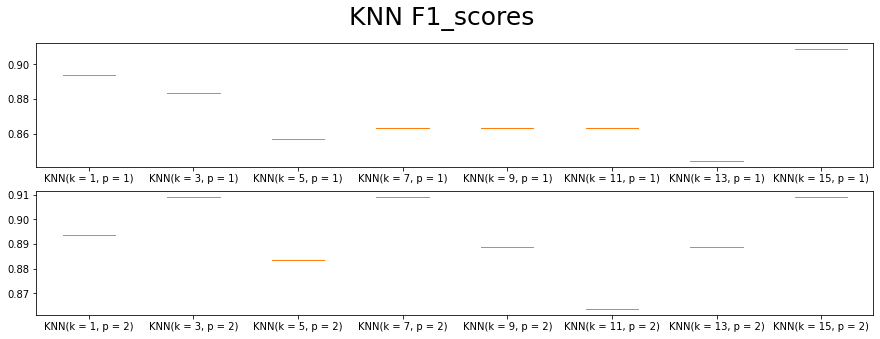

In [172]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("KNN F1_scores", fontsize = 25)
cur_max = 0
cur_index = 0

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 1)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 1)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_smote_roc[cur_index] = [fpr, tpr]
      Freq_smote_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)


ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 2)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 2)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_smote_roc[cur_index] = [fpr, tpr]
      Freq_smote_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Random Forest(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


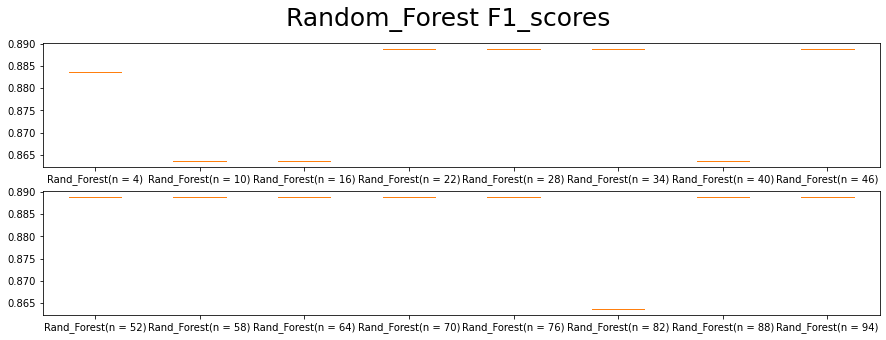

In [173]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("Random_Forest F1_scores", fontsize = 25)
cur_max = 0
cur_index = 1

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_smote_roc[cur_index] = [fpr, tpr]
      Freq_smote_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)


ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_smote_roc[cur_index] = [fpr, tpr]
      Freq_smote_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### LDA(solver = 'svd')

In [174]:
model = LDA()
reg = model.fit(X_train, y_train)

print(f'LDA F_score = {f1_score(y_test, model.predict(X_test))}')


cur_index = 2
Freq_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
Freq_smote_roc[cur_index] = [fpr, tpr]
Freq_smote_results["Models"].iloc[cur_index] = "Linear_Discriminant_Analysis"
Freq_smote_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

LDA F_score = 0.8510638297872339


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##### GBC(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


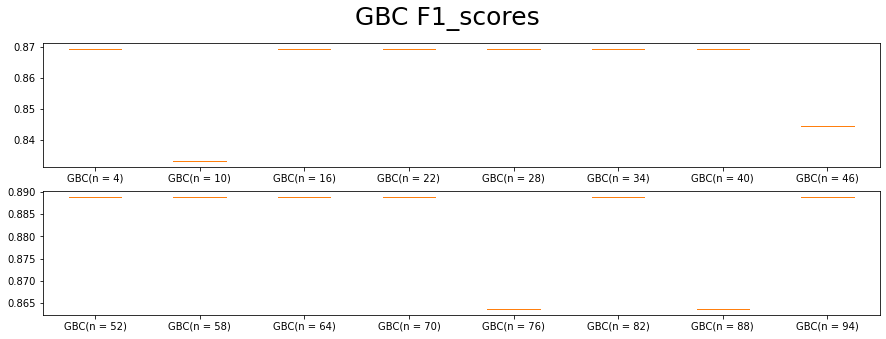

In [175]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("GBC F1_scores", fontsize = 25)
cur_max = 0
cur_index = 3

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = GBC(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_smote_roc[cur_index] = [fpr, tpr]
      Freq_smote_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)


ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_smote_roc[cur_index] = [fpr, tpr]
      Freq_smote_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Naive Bayes

In [176]:
model = GaussianNB()
reg = model.fit(X_train, y_train)

print(f'Naive Bayes F_score = {f1_score(y_test, model.predict(X_test))}')

cur_index = 4
Freq_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
Freq_smote_roc[cur_index] = [fpr, tpr]
Freq_smote_results["Models"].iloc[cur_index] = "Naive_Bayes"
Freq_smote_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

Naive Bayes F_score = 0.7924528301886793


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [177]:
Freq_smote_results

,Models,F1 Score
0,"KNN(k = 15, p = 1)",0.909091
1,Rand_Forest(n = 22),0.888889
2,Linear_Discriminant_Analysis,0.851064
3,GBC(n = 52),0.888889
4,Naive_Bayes,0.792453


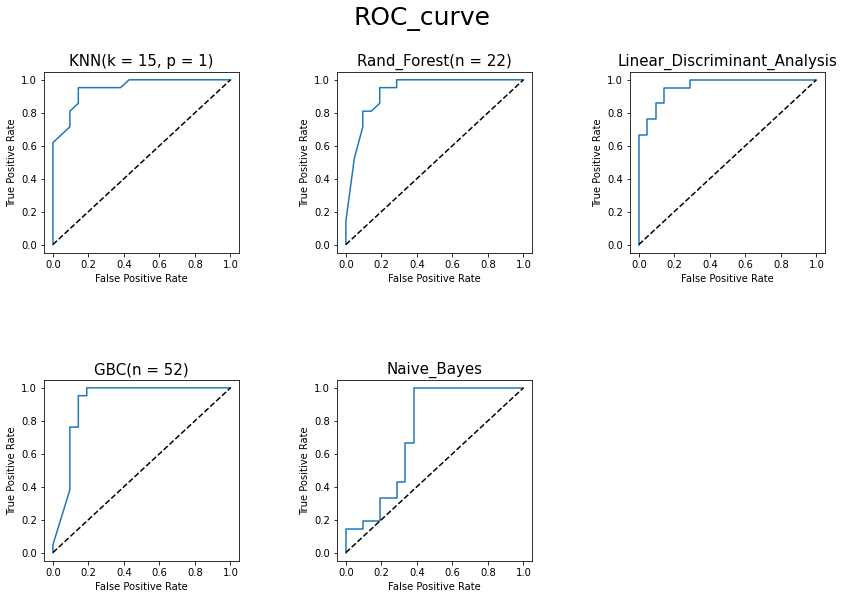

In [178]:
fig = plt.figure(figsize=(14,9))
plt.suptitle("ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(len(Freq_smote_confusion)) :
    ax = fig.add_subplot(2, 3, i + 1)
    ax.plot(Freq_smote_roc[i][0],Freq_smote_roc[i][1])
    ax.set_title(Freq_smote_results['Models'].iloc[i], fontsize = 15)
    ax.set_xlabel('False Positive Rate', fontsize = 10)
    ax.set_ylabel('True Positive Rate', fontsize = 10)
    ax.plot([0, 1], [0, 1], 'k--')

plt.show()

#### ISI

In [179]:
Inhibitory_feature_ISI_minimal_smote = []
Excitatory_feature_ISI_minimal_smote = []
smote_animal_size = []
for animal in range(n_animals) :
    if (Inhibitory_neuron_type_size[animal] in [0, 1] or Excitatory_neuron_type_size[animal] in [0, 1]) :
        print("ZERO")
        Inhibitory_feature_ISI_minimal_smote.append([0])
        Excitatory_feature_ISI_minimal_smote.append([0])
        smote_animal_size.append(0)
        continue
    print(Inhibitory_neuron_type_size[animal], Excitatory_neuron_type_size[animal])
    min_class = min(Inhibitory_neuron_type_size[animal], Excitatory_neuron_type_size[animal])
    x_new, y_new = SMOTE(k_neighbors=min(min_class - 1, 5)).fit_resample(pd.concat([Inhibitory_feature_ISI_minimal[animal],
                                                 Excitatory_feature_ISI_minimal[animal]]),
                                      [-1] * len(Inhibitory_feature_ISI_minimal[animal]) + [1] * len(Excitatory_feature_ISI_minimal[animal]))

    smote_animal_size.append(min_class)
    Inhibitory_feature_ISI_minimal_smote.append(x_new[pd.Series(y_new) == -1])
    Excitatory_feature_ISI_minimal_smote.append(x_new[pd.Series(y_new) == 1])
    print(len(x_new), len(y_new), y_new)
smote_animal_size = pd.Series(smote_animal_size)

11 51
102 102 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
5 24
48 48 [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
6 27
54 54 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
7 43
86 86 [-1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

In [180]:
test_part = 0.25
Inhibitory_test_type_size = (smote_animal_size * test_part).astype(int)
Excitatory_test_type_size = (smote_animal_size * test_part).astype(int)

Inhibitory_test_indexes = []
Excitatory_test_indexes = []

for i in range(n_animals) :
    Inhibitory_test_indexes.append(random.sample([i for i in range(smote_animal_size[i])], Inhibitory_test_type_size[i]))

for i in range(n_animals) :
    Excitatory_test_indexes.append(random.sample([i for i in range(smote_animal_size[i])], Excitatory_test_type_size[i]))

In [181]:
Inhibitory_feature_ISI_minimal_smote_test = pd.DataFrame()
Inhibitory_feature_ISI_minimal_smote_train = pd.DataFrame()

for i in range(n_animals) :
    if (smote_animal_size[i] == 0) :
        continue
    for k in range(len(Inhibitory_feature_ISI_minimal_smote[i])) :
        if k in Inhibitory_test_indexes[i] :
            Inhibitory_feature_ISI_minimal_smote_test = pd.concat([Inhibitory_feature_ISI_minimal_smote_test,
                                                              pd.DataFrame([Inhibitory_feature_ISI_minimal_smote[i].iloc[k]])])
        else :
            Inhibitory_feature_ISI_minimal_smote_train = pd.concat([Inhibitory_feature_ISI_minimal_smote_train,
                                                               pd.DataFrame([Inhibitory_feature_ISI_minimal_smote[i].iloc[k]])])

Excitatory_feature_ISI_minimal_smote_test = pd.DataFrame()
Excitatory_feature_ISI_minimal_smote_train = pd.DataFrame()

for i in range(n_animals) :
    if (smote_animal_size[i] == 0) :
        continue
    for k in range(len(Excitatory_feature_ISI_minimal_smote[i])) :
        if k in Excitatory_test_indexes[i] :
            Excitatory_feature_ISI_minimal_smote_test = pd.concat([Excitatory_feature_ISI_minimal_smote_test,
                                                              pd.DataFrame([Excitatory_feature_ISI_minimal_smote[i].iloc[k]])])
        else :
            Excitatory_feature_ISI_minimal_smote_train = pd.concat([Excitatory_feature_ISI_minimal_smote_train,
                                                               pd.DataFrame([Excitatory_feature_ISI_minimal_smote[i].iloc[k]])])

In [182]:
X_test = pd.concat([Inhibitory_feature_ISI_minimal_smote_test, Excitatory_feature_ISI_minimal_smote_test])
X_train = pd.concat([Inhibitory_feature_ISI_minimal_smote_train, Excitatory_feature_ISI_minimal_smote_train])

y_test = [-1] * len(Inhibitory_feature_ISI_minimal_smote_test) + [1] * len(Excitatory_feature_ISI_minimal_smote_test)
y_train = [-1] * len(Inhibitory_feature_ISI_minimal_smote_train) + [1] * len(Excitatory_feature_ISI_minimal_smote_train)

In [183]:
ISI_smote_results = pd.DataFrame(np.zeros([5, 2]), columns=["Models","F1 Score"])
ISI_smote_confusion = [0] * 5
ISI_smote_roc = [0] * 5

##### KNN(k = 5, p = 1)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


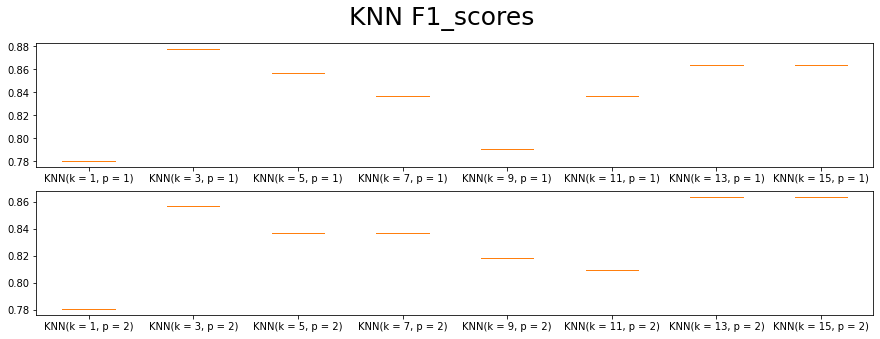

In [184]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("KNN F1_scores", fontsize = 25)
cur_max = 0
cur_index = 0

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 1)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 1)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_smote_roc[cur_index] = [fpr, tpr]
      ISI_smote_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)


ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 2)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 2)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_smote_roc[cur_index] = [fpr, tpr]
      ISI_smote_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Random Forest(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

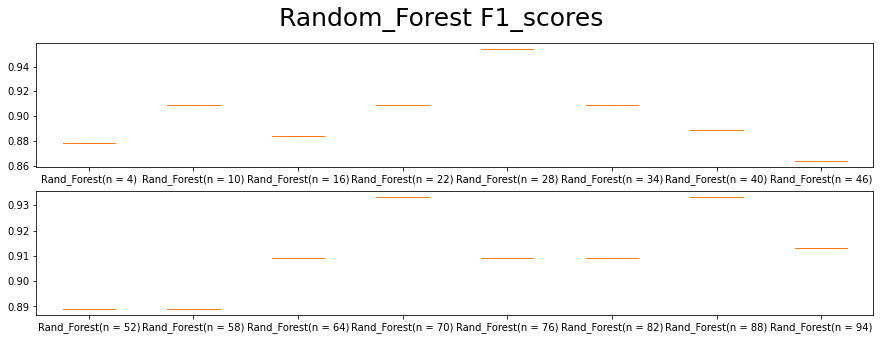

In [185]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("Random_Forest F1_scores", fontsize = 25)
cur_max = 0
cur_index = 1

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_smote_roc[cur_index] = [fpr, tpr]
      ISI_smote_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)


ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_smote_roc[cur_index] = [fpr, tpr]
      ISI_smote_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### LDA(solver = 'svd')

In [186]:
model = LDA()
reg = model.fit(X_train, y_train)

print(f'LDA F_score = {f1_score(y_test, model.predict(X_test))}')


cur_index = 2
ISI_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
ISI_smote_roc[cur_index] = [fpr, tpr]
ISI_smote_results["Models"].iloc[cur_index] = "Linear_Discriminant_Analysis"
ISI_smote_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

LDA F_score = 0.7999999999999999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##### GBC(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

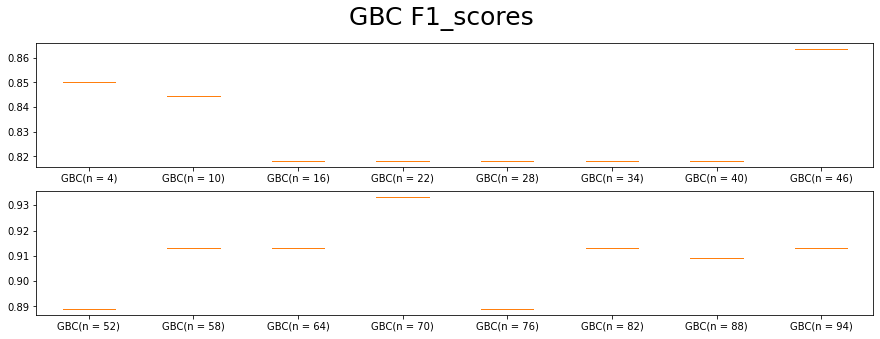

In [187]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("GBC F1_scores", fontsize = 25)
cur_max = 0
cur_index = 3

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = GBC(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_smote_roc[cur_index] = [fpr, tpr]
      ISI_smote_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)


ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_smote_roc[cur_index] = [fpr, tpr]
      ISI_smote_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Naive Bayes

In [188]:
model = GaussianNB()
reg = model.fit(X_train, y_train)

print(f'Naive Bayes F_score = {f1_score(y_test, model.predict(X_test))}')


cur_index = 4
ISI_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
ISI_smote_roc[cur_index] = [fpr, tpr]
ISI_smote_results["Models"].iloc[cur_index] = "Naive_Bayes"
ISI_smote_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

Naive Bayes F_score = 0.7241379310344828


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [189]:
ISI_smote_results

,Models,F1 Score
0,"KNN(k = 3, p = 1)",0.878049
1,Rand_Forest(n = 28),0.954545
2,Linear_Discriminant_Analysis,0.800000
3,GBC(n = 70),0.933333
4,Naive_Bayes,0.724138


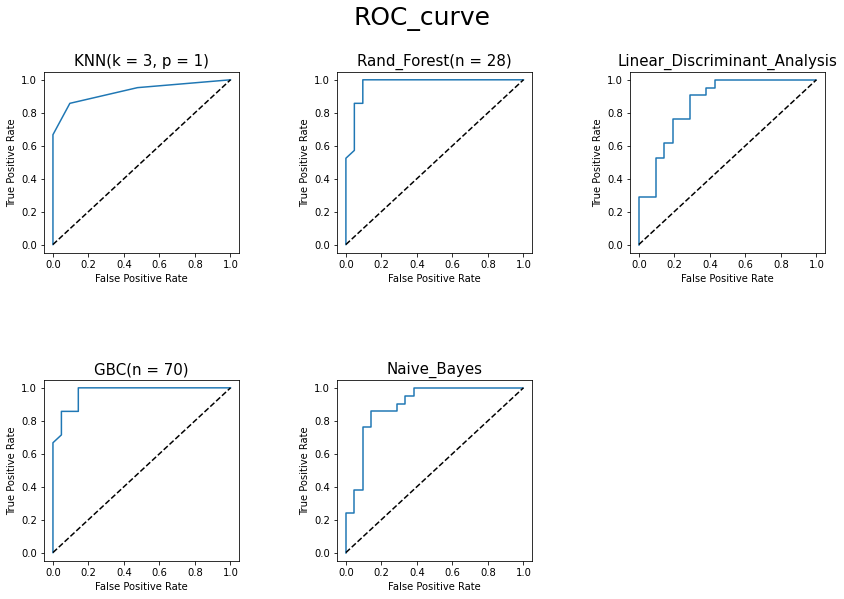

In [190]:
fig = plt.figure(figsize=(14,9))
plt.suptitle("ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(len(ISI_smote_confusion)) :
    ax = fig.add_subplot(2, 3, i + 1)
    ax.plot(ISI_smote_roc[i][0],ISI_smote_roc[i][1])
    ax.set_title(ISI_smote_results['Models'].iloc[i], fontsize = 15)
    ax.set_xlabel('False Positive Rate', fontsize = 10)
    ax.set_ylabel('True Positive Rate', fontsize = 10)
    ax.plot([0, 1], [0, 1], 'k--')

plt.show()

# Добавляем шум

In [191]:
noise_part = 0.2
Inhibitory_ts_data_noise = []
for animal in range(n_animals) :
    Inhibitory_ts_data_noise.append([])
    for i in range(Inhibitory_neuron_type_size[animal]) :
        Inhibitory_ts_data_noise[animal].append(pd.Series(Inhibitory_ts_data[animal][i]))
        noise = Inhibitory_ts_data_noise[animal][i].sample(int(len(Inhibitory_ts_data[animal][i]) * noise_part))
        noise = noise + np.random.poisson(lam = 7, size = len(noise))
        Inhibitory_ts_data_noise[animal][i] = pd.concat([Inhibitory_ts_data_noise[animal][i], noise])
        Inhibitory_ts_data_noise[animal][i] = Inhibitory_ts_data_noise[animal][i].sort_values()

In [46]:
noise_part = 0.2
Excitatory_ts_data_noise = []
for animal in range(n_animals) :
    Excitatory_ts_data_noise.append([])
    for i in range(Excitatory_neuron_type_size[animal]) :
        Excitatory_ts_data_noise[animal].append(pd.Series(Excitatory_ts_data[animal][i]))
        noise = Excitatory_ts_data_noise[animal][i].sample(int(len(Excitatory_ts_data[animal][i]) * noise_part))
        noise = noise + np.random.poisson(lam = 7, size = len(noise))
        Excitatory_ts_data_noise[animal][i] = pd.concat([Excitatory_ts_data_noise[animal][i], noise])
        Excitatory_ts_data_noise[animal][i] = Excitatory_ts_data_noise[animal][i].sort_values()

## Превращаем в частоты с a = 0.8 и извлекаем минимальный набор признаков

In [44]:
Inhibitory_feature_freq_noise_minimal = []
for index in range(len(Inhibitory_ts_data_noise)):
    Inhibitory_feature_freq_noise_minimal.append(pd.DataFrame())
    for cur_index in range(len(Inhibitory_ts_data_noise[index])):
        print(index, cur_index)
        Inhibitory_freq = [0]
        h = 0.1
        a = 0.8
        b = 0.001
        current_spike = 0
        n_steps = int((Inhibitory_ts_data_noise[index][cur_index].iloc[-1] - Inhibitory_ts_data_noise[index][cur_index].iloc[0]) / h)
        t = np.linspace(Inhibitory_ts_data_noise[index][cur_index].iloc[0], Inhibitory_ts_data_noise[index][cur_index].iloc[-1], n_steps)

        for i in range(n_steps):
            if abs(t[i] - Inhibitory_ts_data_noise[index][cur_index].iloc[current_spike]) < h:
                S = 1
                while (current_spike < len(Inhibitory_ts_data_noise[index][cur_index]) and
                       abs(t[i] - Inhibitory_ts_data_noise[index][cur_index].iloc[current_spike]) < h):
                    current_spike += 1
            else:
                S = 0
            Inhibitory_freq.append(Inhibitory_freq[-1] + h * (-a * Inhibitory_freq[i] + b * S))

        Inhibitory_format_freq_noise = pd.DataFrame()
        Inhibitory_format_freq_noise[0] = pd.Series(Inhibitory_freq[1:])
        Inhibitory_format_freq_noise[1] = pd.Series([cur_index] * len(Inhibitory_freq[1:]))

        Inhibitory_feature_freq_noise_minimal[index] = pd.concat([Inhibitory_feature_freq_noise_minimal[index],
                                                            extract_features(Inhibitory_format_freq_noise, column_id=1,
                                                                             default_fc_parameters=MinimalFCParameters(),
                                                                             n_jobs=10)])

Excitatory_feature_freq_noise_minimal = []
for index in range(len(Excitatory_ts_data_noise)):
    Excitatory_feature_freq_noise_minimal.append(pd.DataFrame())
    for cur_index in range(len(Excitatory_ts_data_noise[index])):
        print(index, cur_index)
        Excitatory_freq = [0]
        h = 0.1
        a = 0.8
        b = 0.001
        current_spike = 0
        n_steps = int((Excitatory_ts_data_noise[index][cur_index].iloc[-1] - Excitatory_ts_data_noise[index][cur_index].iloc[0]) / h)
        t = np.linspace(Excitatory_ts_data_noise[index][cur_index].iloc[0], Excitatory_ts_data_noise[index][cur_index].iloc[-1], n_steps)

        for i in range(n_steps):
            if abs(t[i] - Excitatory_ts_data_noise[index][cur_index].iloc[current_spike]) < h:
                S = 1
                while (current_spike < len(Excitatory_ts_data_noise[index][cur_index]) and
                       abs(t[i] - Excitatory_ts_data_noise[index][cur_index].iloc[current_spike]) < h):
                    current_spike += 1
            else:
                S = 0
            Excitatory_freq.append(Excitatory_freq[-1] + h * (-a * Excitatory_freq[i] + b * S))

        Excitatory_format_freq_noise = pd.DataFrame()
        Excitatory_format_freq_noise[0] = pd.Series(Excitatory_freq[1:])
        Excitatory_format_freq_noise[1] = pd.Series([cur_index] * len(Excitatory_freq[1:]))

        Excitatory_feature_freq_noise_minimal[index] = pd.concat([Excitatory_feature_freq_noise_minimal[index],
                                                            extract_features(Excitatory_format_freq_noise, column_id=1,
                                                                             default_fc_parameters=MinimalFCParameters(),
                                                                             n_jobs=10)])

NameError: name 'Inhibitory_ts_data_noise' is not defined

In [ ]:
Inhibitory_feature_freq_noise_minimal_all = pd.DataFrame()
for i in range(len(Inhibitory_feature_freq_noise_minimal)) :
  Inhibitory_feature_freq_noise_minimal_all = pd.concat([Inhibitory_feature_freq_noise_minimal_all, Inhibitory_feature_freq_noise_minimal[i]])

In [ ]:
Excitatory_feature_freq_noise_minimal_all = pd.DataFrame()
for i in range(len(Excitatory_feature_freq_noise_minimal)) :
  Excitatory_feature_freq_noise_minimal_all = pd.concat([Excitatory_feature_freq_noise_minimal_all, Excitatory_feature_freq_noise_minimal[i]])

In [ ]:
Inhibitory_feature_freq_noise_minimal_all.to_csv('Inhibitory_feature_freq_noise_minimal_all.csv', index = False)
Excitatory_feature_freq_noise_minimal_all.to_csv('Excitatory_feature_freq_noise_minimal_all.csv', index = False)

### Скачаем данные

In [47]:
Inhibitory_feature_freq_noise_minimal_all = pd.read_csv('https://raw.githubusercontent.com/KAD1029/Neural_Activity/master/Feature_data/Inhibitory_feature_freq_noise_minimal_all.csv')
Excitatory_feature_freq_noise_minimal_all = pd.read_csv('https://raw.githubusercontent.com/KAD1029/Neural_Activity/master/Feature_data/Excitatory_feature_freq_noise_minimal_all.csv')

In [48]:
tsfresh.utilities.dataframe_functions.impute(Inhibitory_feature_freq_noise_minimal_all)
tsfresh.utilities.dataframe_functions.impute(Excitatory_feature_freq_noise_minimal_all)

,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__root_mean_square,0__maximum,0__minimum
0,7.516349,0.000037,0.000055,135646.0,0.000058,3.397770e-09,0.000080,0.000526,2.937669e-15
1,6.714460,0.000016,0.000050,135451.0,0.000071,4.975525e-09,0.000086,0.000661,5.355918e-79
2,10.368426,0.000007,0.000076,135662.0,0.000130,1.678836e-08,0.000150,0.001121,2.434632e-62
3,11.107598,0.000058,0.000082,135632.0,0.000085,7.250601e-09,0.000118,0.000682,4.756714e-23
4,14.029305,0.000083,0.000103,135569.0,0.000093,8.563363e-09,0.000139,0.000742,1.249437e-14
...,...,...,...,...,...,...,...,...,...
875,7.075737,0.000005,0.000037,190241.0,0.000072,5.233265e-09,0.000081,0.000945,2.467253e-46
876,10.128711,0.000027,0.000053,190562.0,0.000067,4.446698e-09,0.000085,0.000730,3.336518e-34
877,14.707497,0.000040,0.000077,190580.0,0.000102,1.047557e-08,0.000128,0.000944,1.142809e-44
878,11.276745,0.000038,0.000059,190555.0,0.000065,4.287175e-09,0.000088,0.000606,2.401175e-21


In [50]:
Inhibitory_feature_freq_noise_minimal = []
cur_index = 0
for i in range(len(Inhibitory_neuron_type_size)) :
  Inhibitory_feature_freq_noise_minimal.append(Inhibitory_feature_freq_noise_minimal_all.iloc[cur_index : cur_index + Inhibitory_neuron_type_size[i]])
  cur_index += Inhibitory_neuron_type_size[i]

In [63]:
Excitatory_feature_freq_noise_minimal = []
cur_index = 0
for i in range(len(Excitatory_neuron_type_size)) :
  Excitatory_feature_freq_noise_minimal.append(Excitatory_feature_freq_noise_minimal_all.iloc[cur_index : cur_index + Excitatory_neuron_type_size[i]])
  cur_index += Excitatory_neuron_type_size[i]

## Превращаем в ISI и извлекаем минимальный набор признаков

In [52]:
Inhibitory_ISI_data_noise = []
for animal in range(n_animals) :
  Inhibitory_ISI_data_noise.append([])
  I_ts_size = len(Inhibitory_ts_data_noise[animal])
  for i in range(I_ts_size) :
      Inhibitory_ISI_data_noise[animal].append([])
      for spike in range(len(Inhibitory_ts_data_noise[animal][i]) - 1) :
          Inhibitory_ISI_data_noise[animal][i].append(Inhibitory_ts_data_noise[animal][i].iloc[spike + 1] - Inhibitory_ts_data_noise[animal][i].iloc[spike])

In [53]:
Excitatory_ISI_data_noise = []
for animal in range(n_animals) :
  Excitatory_ISI_data_noise.append([])
  I_ts_size = len(Excitatory_ts_data_noise[animal])
  for i in range(I_ts_size) :
      Excitatory_ISI_data_noise[animal].append([])
      for spike in range(len(Excitatory_ts_data_noise[animal][i]) - 1) :
          Excitatory_ISI_data_noise[animal][i].append(Excitatory_ts_data_noise[animal][i].iloc[spike + 1] - Excitatory_ts_data_noise[animal][i].iloc[spike])

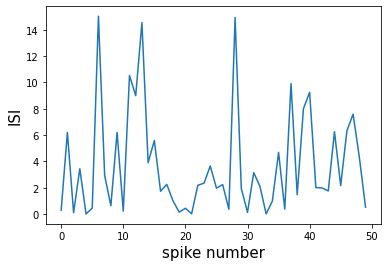

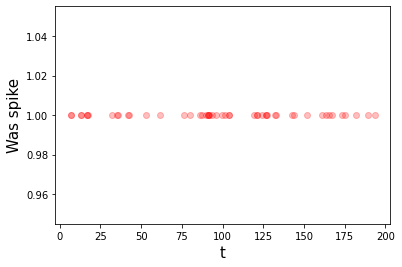

In [54]:
plt.plot([i for i in range(50)], Inhibitory_ISI_data_noise[0][0][0:50])
plt.ylabel('ISI', fontsize = 15)
plt.xlabel('spike number', fontsize = 15)
plt.show()

plt.plot(Inhibitory_ts_data_noise[0][0][0:50], [1] * len(Inhibitory_ts_data_noise[0][0][0:50]), 'ro', alpha = 0.25)
plt.ylabel('Was spike', fontsize = 15)
plt.xlabel('t', fontsize = 15)
plt.show()

### Извлекаем признаки

In [55]:
Inhibitory_format_data_noise_ISI = []
for animal in range(len(Inhibitory_ISI_data_noise)) :
  Inhibitory_format_data_noise_ISI.append([])
  tmp1 = []
  tmp2 = []
  ISI_size_I = len(Inhibitory_ISI_data_noise[animal])
  for i in range(ISI_size_I):
      tmp1 += Inhibitory_ISI_data_noise[animal][i]
      tmp2 += [i] * len(Inhibitory_ISI_data_noise[animal][i])

  Inhibitory_format_data_noise_ISI[animal] = pd.DataFrame()
  Inhibitory_format_data_noise_ISI[animal][0] = pd.Series(tmp1)
  Inhibitory_format_data_noise_ISI[animal][1] = pd.Series(tmp2)

<ipython-input-55-e51657ff9796>:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Inhibitory_format_data_noise_ISI[animal][0] = pd.Series(tmp1)
<ipython-input-55-e51657ff9796>:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Inhibitory_format_data_noise_ISI[animal][1] = pd.Series(tmp2)


In [56]:
Excitatory_format_data_noise_ISI = []
for animal in range(len(Excitatory_ISI_data_noise)) :
  Excitatory_format_data_noise_ISI.append([])
  tmp1 = []
  tmp2 = []
  ISI_size_E = len(Excitatory_ISI_data_noise[animal])
  for i in range(ISI_size_E):
      tmp1 += Excitatory_ISI_data_noise[animal][i]
      tmp2 += [i] * len(Excitatory_ISI_data_noise[animal][i])

  Excitatory_format_data_noise_ISI[animal] = pd.DataFrame()
  Excitatory_format_data_noise_ISI[animal][0] = pd.Series(tmp1)
  Excitatory_format_data_noise_ISI[animal][1] = pd.Series(tmp2)

#### Извлекаем минимальный набор признаков

In [ ]:
Inhibitory_feature_ISI_noise_minimal = []
Excitatory_feature_ISI_noise_minimal = []
for animal in range(n_animals) :
  print(f'animal №{animal + 1}/{n_animals}')

  if (Inhibitory_neuron_type_size[animal] == 0) :
    print("No inhibitory nuerons")
    Inhibitory_feature_ISI_noise_minimal.append([0])
  else :
    Inhibitory_feature_ISI_noise_minimal.append(extract_features(Inhibitory_format_data_noise_ISI[animal], column_id=1, default_fc_parameters=MinimalFCParameters(), n_jobs = 10))
    tsfresh.utilities.dataframe_functions.impute(Inhibitory_feature_ISI_noise_minimal[animal])

  if (Excitatory_neuron_type_size[animal] == 0) :
    print("No excitatory nuerons")
    Excitatory_feature_ISI_noise_minimal.append([0])
  else :
    Excitatory_feature_ISI_noise_minimal.append(extract_features(Excitatory_format_data_noise_ISI[animal], column_id=1, default_fc_parameters=MinimalFCParameters(), n_jobs = 10))
    tsfresh.utilities.dataframe_functions.impute(Excitatory_feature_ISI_noise_minimal[animal])

## Сравнение методов с шумом

In [58]:
test_part = 0.25
Inhibitory_test_type_size = (Inhibitory_neuron_type_size * test_part).astype(int)
Excitatory_test_type_size = (Excitatory_neuron_type_size * test_part).astype(int)

Inhibitory_test_indexes = []
Excitatory_test_indexes = []

for i in range(n_animals):
    Inhibitory_test_indexes.append(
        random.sample([i for i in range(Inhibitory_neuron_type_size[i])], Inhibitory_test_type_size[i]))

for i in range(n_animals):
    Excitatory_test_indexes.append(
        random.sample([i for i in range(Excitatory_neuron_type_size[i])], Excitatory_test_type_size[i]))
Inhibitory_feature_freq_noise_minimal_test = pd.DataFrame()
Inhibitory_feature_freq_noise_minimal_train = pd.DataFrame()

In [64]:
for i in range(n_animals):
    for k in range(len(Inhibitory_feature_freq_noise_minimal[i])):
        if k in Inhibitory_test_indexes[i]:
            Inhibitory_feature_freq_noise_minimal_test = pd.concat([Inhibitory_feature_freq_noise_minimal_test,
                                                              pd.DataFrame(
                                                                  [Inhibitory_feature_freq_noise_minimal[i].iloc[k]])])
        else:
            Inhibitory_feature_freq_noise_minimal_train = pd.concat([Inhibitory_feature_freq_noise_minimal_train,
                                                               pd.DataFrame(
                                                                   [Inhibitory_feature_freq_noise_minimal[i].iloc[k]])])

Excitatory_feature_freq_noise_minimal_test = pd.DataFrame()
Excitatory_feature_freq_noise_minimal_train = pd.DataFrame()

for i in range(n_animals):
    for k in range(len(Excitatory_feature_freq_noise_minimal[i])):
        if k in Excitatory_test_indexes[i]:
            Excitatory_feature_freq_noise_minimal_test = pd.concat([Excitatory_feature_freq_noise_minimal_test,
                                                              pd.DataFrame(
                                                                  [Excitatory_feature_freq_noise_minimal[i].iloc[k]])])
        else:
            Excitatory_feature_freq_noise_minimal_train = pd.concat([Excitatory_feature_freq_noise_minimal_train,
                                                               pd.DataFrame(
                                                                   [Excitatory_feature_freq_noise_minimal[i].iloc[k]])])

In [65]:
Inhibitory_feature_ISI_noise_minimal_test = pd.DataFrame()
Inhibitory_feature_ISI_noise_minimal_train = pd.DataFrame()

for i in range(n_animals):
    for k in range(len(Inhibitory_feature_freq_minimal[i])):
        if k in Inhibitory_test_indexes[i]:
            Inhibitory_feature_ISI_noise_minimal_test = pd.concat([Inhibitory_feature_ISI_noise_minimal_test,
                                                             pd.DataFrame([Inhibitory_feature_ISI_noise_minimal[i].iloc[k]])])
        else:
            Inhibitory_feature_ISI_noise_minimal_train = pd.concat([Inhibitory_feature_ISI_noise_minimal_train,
                                                              pd.DataFrame(
                                                                  [Inhibitory_feature_ISI_noise_minimal[i].iloc[k]])])

Excitatory_feature_ISI_noise_minimal_test = pd.DataFrame()
Excitatory_feature_ISI_noise_minimal_train = pd.DataFrame()

for i in range(n_animals):
    for k in range(len(Excitatory_feature_ISI_noise_minimal[i])):
        if k in Excitatory_test_indexes[i]:
            Excitatory_feature_ISI_noise_minimal_test = pd.concat([Excitatory_feature_ISI_noise_minimal_test,
                                                             pd.DataFrame([Excitatory_feature_ISI_noise_minimal[i].iloc[k]])])
        else:
            Excitatory_feature_ISI_noise_minimal_train = pd.concat([Excitatory_feature_ISI_noise_minimal_train,
                                                              pd.DataFrame(
                                                                  [Excitatory_feature_ISI_noise_minimal[i].iloc[k]])])

#### Частотные данные, a = 0.8, минимальный набор признаков

In [66]:
X_test = pd.concat([Inhibitory_feature_freq_noise_minimal_test, Excitatory_feature_freq_noise_minimal_test])
X_train = pd.concat([Inhibitory_feature_freq_noise_minimal_train, Excitatory_feature_freq_noise_minimal_train])

y_test = [-1] * len(Inhibitory_feature_freq_noise_minimal_test) + [1] * len(Excitatory_feature_freq_noise_minimal_test)
y_train = [-1] * len(Inhibitory_feature_freq_noise_minimal_train) + [1] * len(Excitatory_feature_freq_noise_minimal_train)

In [67]:
Freq_noise_results = pd.DataFrame(np.zeros([5, 2]), columns=["Models","F1 Score"])
Freq_noise_confusion = [0] * 5
Freq_noise_roc = [0] * 5

##### KNN(k = 5, p = 1)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


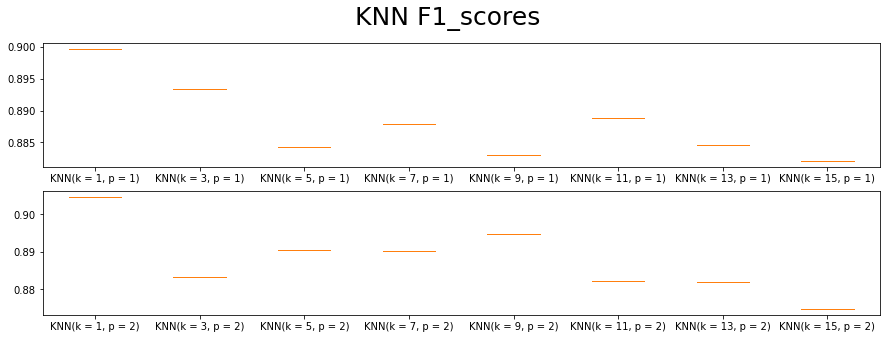

In [68]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("KNN F1_scores", fontsize = 25)
cur_max = 0
cur_index = 0

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 1)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 1)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_noise_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_noise_roc[cur_index] = [fpr, tpr]
      Freq_noise_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_noise_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 2)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 2)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_noise_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_noise_roc[cur_index] = [fpr, tpr]
      Freq_noise_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_noise_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Random Forest(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

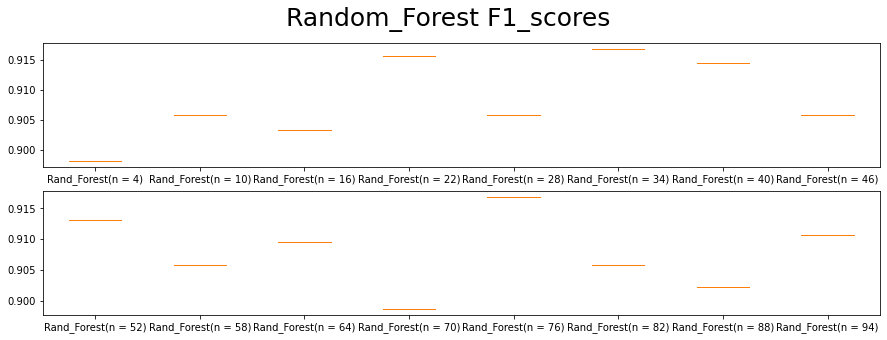

In [69]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("Random_Forest F1_scores", fontsize = 25)
cur_max = 0
cur_index = 1

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_noise_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_noise_roc[cur_index] = [fpr, tpr]
      Freq_noise_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_noise_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_noise_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_noise_roc[cur_index] = [fpr, tpr]
      Freq_noise_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_noise_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### LDA(solver = 'svd')

In [70]:
model = LDA()
reg = model.fit(X_train, y_train)

print(f'LDA F_score = {f1_score(y_test, model.predict(X_test))}')


cur_index = 2
Freq_noise_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
Freq_noise_roc[cur_index] = [fpr, tpr]
Freq_noise_results["Models"].iloc[cur_index] = "Linear_Discriminant_Analysis"
Freq_noise_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

LDA F_score = 0.9168539325842697


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##### GBC(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

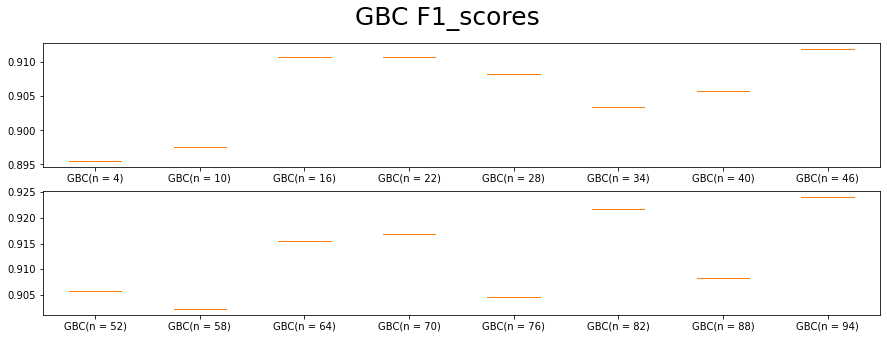

In [71]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("GBC F1_scores", fontsize = 25)
cur_max = 0
cur_index = 3

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = GBC(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_noise_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_noise_roc[cur_index] = [fpr, tpr]
      Freq_noise_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_noise_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_noise_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_noise_roc[cur_index] = [fpr, tpr]
      Freq_noise_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_noise_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Naive Bayes

In [72]:
model = GaussianNB()
reg = model.fit(X_train, y_train)

print(f'Naive Bayes F_score = {f1_score(y_test, model.predict(X_test))}')


cur_max = 0
cur_index = 4
Freq_noise_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
Freq_noise_roc[cur_index] = [fpr, tpr]
Freq_noise_results["Models"].iloc[cur_index] = "Naive_Bayes"
Freq_noise_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

Naive Bayes F_score = 0.8927789934354485


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [73]:
Freq_noise_results

,Models,F1 Score
0,"KNN(k = 1, p = 2)",0.904656
1,Rand_Forest(n = 34),0.916854
2,Linear_Discriminant_Analysis,0.916854
3,GBC(n = 94),0.924107
4,Naive_Bayes,0.892779


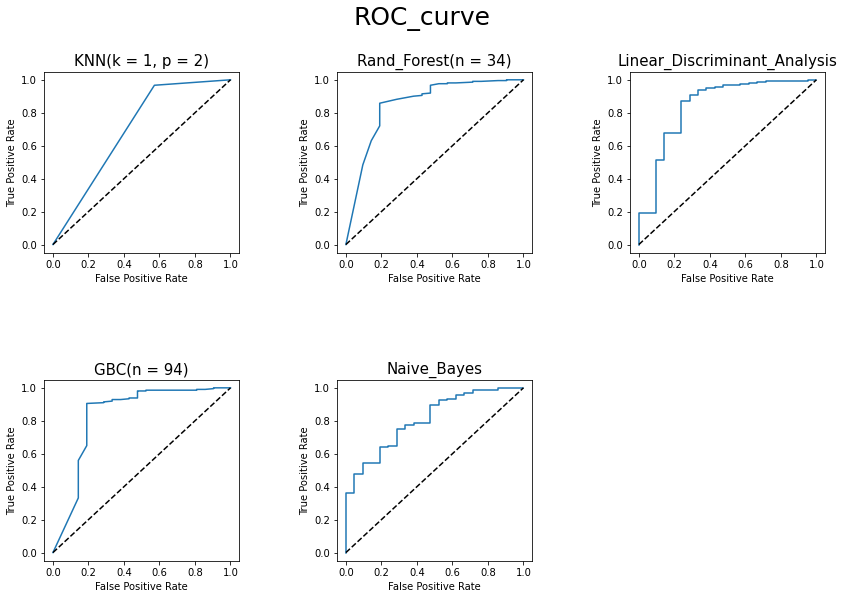

In [74]:
fig = plt.figure(figsize=(14,9))
plt.suptitle("ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(len(Freq_noise_confusion)) :
    ax = fig.add_subplot(2, 3, i + 1)
    ax.plot(Freq_noise_roc[i][0],Freq_noise_roc[i][1])
    ax.set_title(Freq_noise_results['Models'].iloc[i], fontsize = 15)
    ax.set_xlabel('False Positive Rate', fontsize = 10)
    ax.set_ylabel('True Positive Rate', fontsize = 10)
    ax.plot([0, 1], [0, 1], 'k--')

plt.show()

#### ISI данные, минимальный набор признаков

In [75]:
X_test = pd.concat([Inhibitory_feature_ISI_noise_minimal_test, Excitatory_feature_ISI_noise_minimal_test])
X_train = pd.concat([Inhibitory_feature_ISI_noise_minimal_train, Excitatory_feature_ISI_noise_minimal_train])

y_test = [-1] * len(Inhibitory_feature_ISI_noise_minimal_test) + [1] * len(Excitatory_feature_ISI_noise_minimal_test)
y_train = [-1] * len(Inhibitory_feature_ISI_noise_minimal_train) + [1] * len(Excitatory_feature_ISI_noise_minimal_train)

In [76]:
ISI_noise_results = pd.DataFrame(np.zeros([5, 2]), columns=["Models","F1 Score"])
ISI_noise_confusion = [0] * 5
ISI_noise_roc = [0] * 5

##### KNN(k = 5, p = 1)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

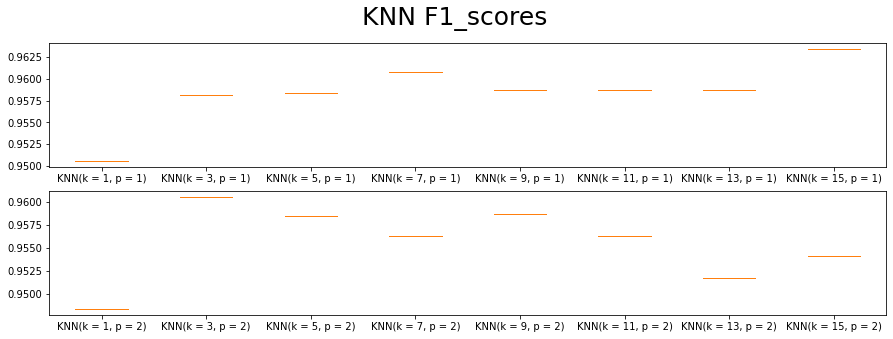

In [77]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("KNN F1_scores", fontsize = 25)
cur_max = 0
cur_index = 0

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 1)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 1)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_noise_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_noise_roc[cur_index] = [fpr, tpr]
      ISI_noise_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_noise_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 2)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 2)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_noise_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_noise_roc[cur_index] = [fpr, tpr]
      ISI_noise_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_noise_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Random Forest(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


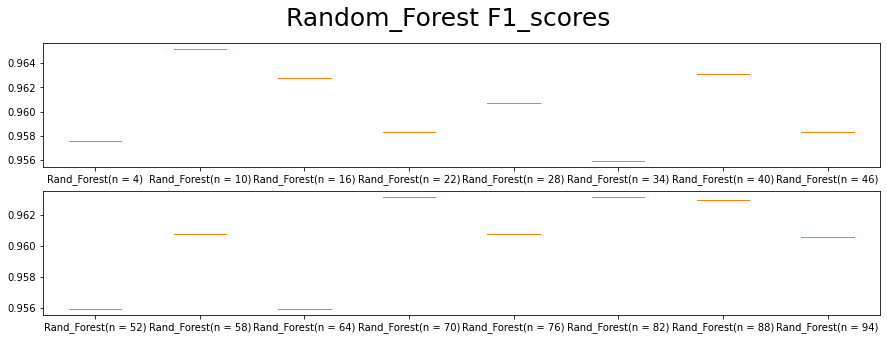

In [78]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("Random_Forest F1_scores", fontsize = 25)
cur_max = 0
cur_index = 1

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_noise_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_noise_roc[cur_index] = [fpr, tpr]
      ISI_noise_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_noise_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_noise_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_noise_roc[cur_index] = [fpr, tpr]
      ISI_noise_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_noise_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### LDA(solver = 'svd')

In [79]:
model = LDA()
reg = model.fit(X_train, y_train)

print(f'LDA F_score = {f1_score(y_test, model.predict(X_test))}')


cur_index = 2
ISI_noise_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
ISI_noise_roc[cur_index] = [fpr, tpr]
ISI_noise_results["Models"].iloc[cur_index] = "Linear_Discriminant_Analysis"
ISI_noise_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

LDA F_score = 0.9612756264236901


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##### GBC(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


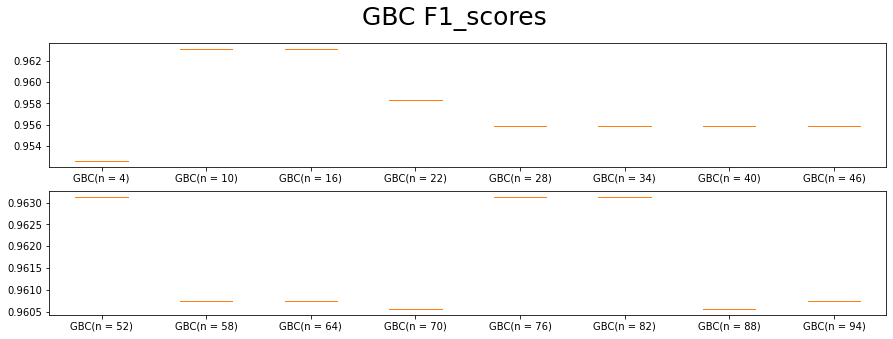

In [80]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("GBC F1_scores", fontsize = 25)
cur_max = 0
cur_index = 3

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = GBC(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_noise_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_noise_roc[cur_index] = [fpr, tpr]
      ISI_noise_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_noise_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_noise_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_noise_roc[cur_index] = [fpr, tpr]
      ISI_noise_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_noise_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Naive Bayes

In [81]:
model = GaussianNB()
reg = model.fit(X_train, y_train)

print(f'Naive Bayes F_score = {f1_score(y_test, model.predict(X_test))}')


cur_index = 4
ISI_noise_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
ISI_noise_roc[cur_index] = [fpr, tpr]
ISI_noise_results["Models"].iloc[cur_index] = "Naive_Bayes"
ISI_noise_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

Naive Bayes F_score = 0.9590909090909091


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [82]:
ISI_noise_results

,Models,F1 Score
0,"KNN(k = 15, p = 1)",0.963470
1,Rand_Forest(n = 10),0.965197
2,Linear_Discriminant_Analysis,0.961276
3,GBC(n = 10),0.963134
4,Naive_Bayes,0.959091


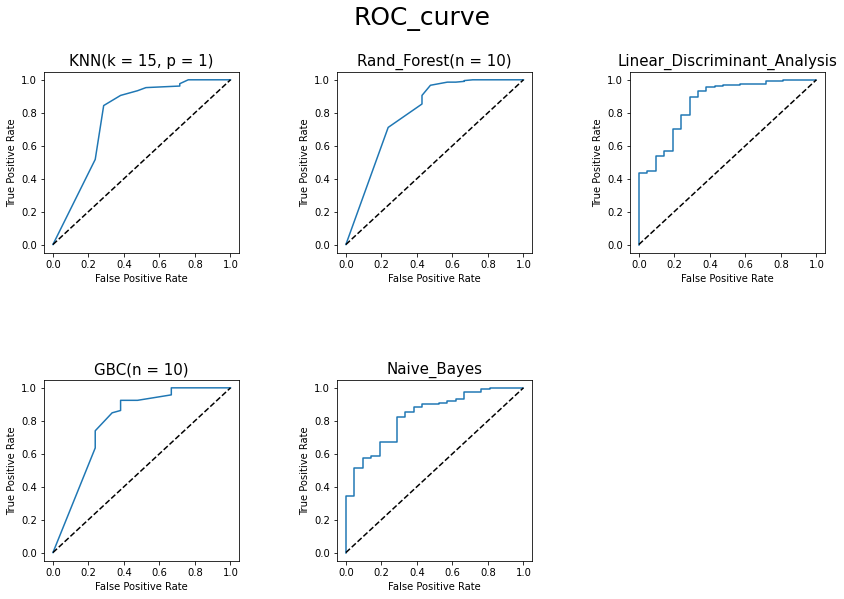

In [83]:
fig = plt.figure(figsize=(14,9))
plt.suptitle("ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(len(ISI_noise_confusion)) :
    ax = fig.add_subplot(2, 3, i + 1)
    ax.plot(ISI_noise_roc[i][0],ISI_noise_roc[i][1])
    ax.set_title(ISI_noise_results['Models'].iloc[i], fontsize = 15)
    ax.set_xlabel('False Positive Rate', fontsize = 10)
    ax.set_ylabel('True Positive Rate', fontsize = 10)
    ax.plot([0, 1], [0, 1], 'k--')

plt.show()

## 3 Балансировка

### RandomUnderSampler

#### Частотные данные

In [84]:
Inhibitory_feature_freq_noise_minimal_undersample = []
Excitatory_feature_freq_noise_minimal_undersample = []
Undersample_animal_size = []
model = RandomUnderSampler()
for animal in range(n_animals) :
    if (Inhibitory_neuron_type_size[animal] == 0 or Excitatory_neuron_type_size[animal] == 0) :
        print("ZERO")
        Inhibitory_feature_freq_noise_minimal_undersample.append([0])
        Excitatory_feature_freq_noise_minimal_undersample.append([0])
        Undersample_animal_size.append(0)
        continue
    print(Inhibitory_neuron_type_size[animal], Excitatory_neuron_type_size[animal])
    x_new, y_new = model.fit_resample(pd.concat([Inhibitory_feature_freq_noise_minimal[animal],
                                                 Excitatory_feature_freq_noise_minimal[animal]]),
                                      [-1] * len(Inhibitory_feature_freq_noise_minimal[animal]) + [1] * len(Excitatory_feature_freq_noise_minimal[animal]))
    min_class = min(Inhibitory_neuron_type_size[animal], Excitatory_neuron_type_size[animal])
    Undersample_animal_size.append(min_class)
    Inhibitory_feature_freq_noise_minimal_undersample.append(x_new[0 : min_class])
    Excitatory_feature_freq_noise_minimal_undersample.append(x_new[min_class : ])
    print(len(x_new), len(y_new), y_new)
Undersample_animal_size = pd.Series(Undersample_animal_size)

11 51
22 22 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
5 24
10 10 [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
6 27
12 12 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
7 43
14 14 [-1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1]
1 34
2 2 [-1, 1]
6 34
12 12 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
13 37
26 26 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
10 51
20 20 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
5 17
10 10 [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
6 60
12 12 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
4 28
8 8 [-1, -1, -1, -1, 1, 1, 1, 1]
1 20
2 2 [-1, 1]
3 33
6 6 [-1, -1, -1, 1, 1, 1]
6 46
12 12 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
5 55
10 10 [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
1 23
2 2 [-1, 1]
4 32
8 8 [-1, -1, -1, -1, 1, 1, 1, 1]
ZERO
ZERO
6 40
12 12 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
1 25
2 2 [-1, 1]
4 89
8 8 [-1, -1, -1, -1, 1, 1, 1, 1]
2 25
4 4 [-1, -1, 1, 1]
9 42

In [85]:
test_part = 0.25
Inhibitory_test_type_size = (Undersample_animal_size * test_part).astype(int)
Excitatory_test_type_size = (Undersample_animal_size * test_part).astype(int)

Inhibitory_test_indexes = []
Excitatory_test_indexes = []

for i in range(n_animals) :
    Inhibitory_test_indexes.append(random.sample([i for i in range(Undersample_animal_size[i])], Inhibitory_test_type_size[i]))

for i in range(n_animals) :
    Excitatory_test_indexes.append(random.sample([i for i in range(Undersample_animal_size[i])], Excitatory_test_type_size[i]))

In [86]:
Inhibitory_feature_freq_noise_minimal_undersample_test = pd.DataFrame()
Inhibitory_feature_freq_noise_minimal_undersample_train = pd.DataFrame()

for i in range(n_animals) :
    if (Undersample_animal_size[i] == 0) :
        continue
    for k in range(len(Inhibitory_feature_freq_noise_minimal_undersample[i])) :
        if k in Inhibitory_test_indexes[i] :
            Inhibitory_feature_freq_noise_minimal_undersample_test = pd.concat([Inhibitory_feature_freq_noise_minimal_undersample_test,
                                                              pd.DataFrame([Inhibitory_feature_freq_noise_minimal_undersample[i].iloc[k]])])
        else :
            Inhibitory_feature_freq_noise_minimal_undersample_train = pd.concat([Inhibitory_feature_freq_noise_minimal_undersample_train,
                                                               pd.DataFrame([Inhibitory_feature_freq_noise_minimal_undersample[i].iloc[k]])])

Excitatory_feature_freq_noise_minimal_undersample_test = pd.DataFrame()
Excitatory_feature_freq_noise_minimal_undersample_train = pd.DataFrame()

for i in range(n_animals) :
    if (Undersample_animal_size[i] == 0) :
        continue
    for k in range(len(Excitatory_feature_freq_noise_minimal_undersample[i])) :
        if k in Excitatory_test_indexes[i] :
            Excitatory_feature_freq_noise_minimal_undersample_test = pd.concat([Excitatory_feature_freq_noise_minimal_undersample_test,
                                                              pd.DataFrame([Excitatory_feature_freq_noise_minimal_undersample[i].iloc[k]])])
        else :
            Excitatory_feature_freq_noise_minimal_undersample_train = pd.concat([Excitatory_feature_freq_noise_minimal_undersample_train,
                                                               pd.DataFrame([Excitatory_feature_freq_noise_minimal_undersample[i].iloc[k]])])

In [87]:
X_test = pd.concat([Inhibitory_feature_freq_noise_minimal_undersample_test, Excitatory_feature_freq_noise_minimal_undersample_test])
X_train = pd.concat([Inhibitory_feature_freq_noise_minimal_undersample_train, Excitatory_feature_freq_noise_minimal_undersample_train])

y_test = [-1] * len(Inhibitory_feature_freq_noise_minimal_undersample_test) + [1] * len(Excitatory_feature_freq_noise_minimal_undersample_test)
y_train = [-1] * len(Inhibitory_feature_freq_noise_minimal_undersample_train) + [1] * len(Excitatory_feature_freq_noise_minimal_undersample_train)

In [88]:
Freq_noise_undersample_results = pd.DataFrame(np.zeros([5, 2]), columns=["Models","F1 Score"])
Freq_noise_undersample_confusion = [0] * 5
Freq_noise_undersample_roc = [0] * 5

##### KNN(k = 5, p = 1)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


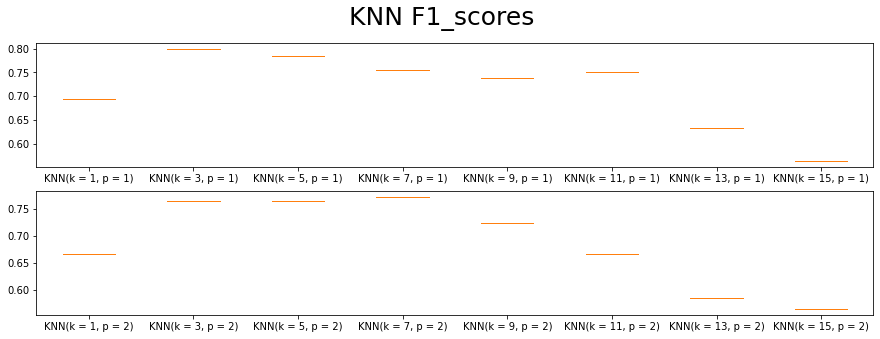

In [89]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("KNN F1_scores", fontsize = 25)
cur_max = 0
cur_index = 0

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 1)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 1)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_noise_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_noise_undersample_roc[cur_index] = [fpr, tpr]
      Freq_noise_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_noise_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]

ax.boxplot(fscores_array, labels = names_array)


ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 2)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 2)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_noise_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_noise_undersample_roc[cur_index] = [fpr, tpr]
      Freq_noise_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_noise_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Random Forest(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

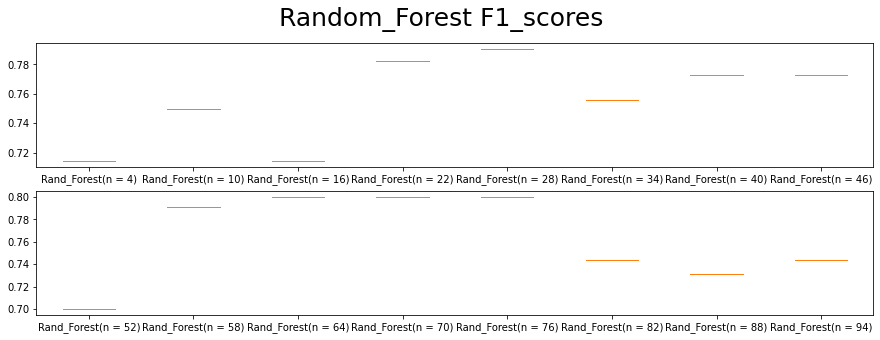

In [90]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("Random_Forest F1_scores", fontsize = 25)
cur_max = 0
cur_index = 1

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_noise_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_noise_undersample_roc[cur_index] = [fpr, tpr]
      Freq_noise_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_noise_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)


ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_noise_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_noise_undersample_roc[cur_index] = [fpr, tpr]
      Freq_noise_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_noise_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### LDA(solver = 'svd')

In [91]:
model = LDA()
reg = model.fit(X_train, y_train)

print(f'LDA F_score = {f1_score(y_test, model.predict(X_test))}')


cur_index = 2
Freq_noise_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
Freq_noise_undersample_roc[cur_index] = [fpr, tpr]
Freq_noise_undersample_results["Models"].iloc[cur_index] = "Linear_Discriminant_Analysis"
Freq_noise_undersample_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

LDA F_score = 0.7659574468085107


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##### GBC(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

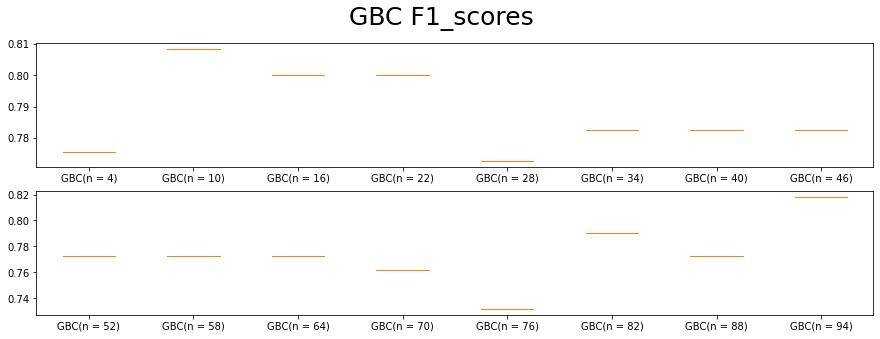

In [92]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("GBC F1_scores", fontsize = 25)
cur_max = 0
cur_index = 3

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = GBC(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_noise_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_noise_undersample_roc[cur_index] = [fpr, tpr]
      Freq_noise_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_noise_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)


ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_noise_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_noise_undersample_roc[cur_index] = [fpr, tpr]
      Freq_noise_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_noise_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Naive Bayes

In [93]:
model = GaussianNB()
reg = model.fit(X_train, y_train)

print(f'Naive Bayes F_score = {f1_score(y_test, model.predict(X_test))}')


cur_index = 4
Freq_noise_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
Freq_noise_undersample_roc[cur_index] = [fpr, tpr]
Freq_noise_undersample_results["Models"].iloc[cur_index] = "Naive_Bayes"
Freq_noise_undersample_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

Naive Bayes F_score = 0.7843137254901961


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [94]:
Freq_noise_undersample_results

,Models,F1 Score
0,"KNN(k = 3, p = 1)",0.800000
1,Rand_Forest(n = 64),0.800000
2,Linear_Discriminant_Analysis,0.765957
3,GBC(n = 94),0.818182
4,Naive_Bayes,0.784314


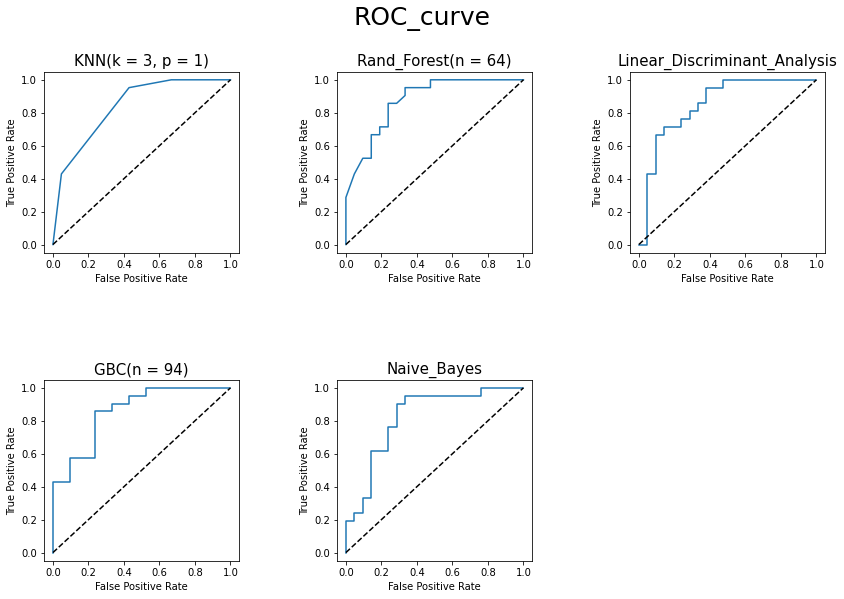

In [95]:
fig = plt.figure(figsize=(14,9))
plt.suptitle("ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(len(Freq_noise_undersample_confusion)) :
    ax = fig.add_subplot(2, 3, i + 1)
    ax.plot(Freq_noise_undersample_roc[i][0],Freq_noise_undersample_roc[i][1])
    ax.set_title(Freq_noise_undersample_results['Models'].iloc[i], fontsize = 15)
    ax.set_xlabel('False Positive Rate', fontsize = 10)
    ax.set_ylabel('True Positive Rate', fontsize = 10)
    ax.plot([0, 1], [0, 1], 'k--')

plt.show()

#### ISI

In [291]:
Inhibitory_feature_ISI_noise_minimal_undersample = []
Excitatory_feature_ISI_noise_minimal_undersample = []
Undersample_animal_size = []
model = RandomUnderSampler()
for animal in range(n_animals) :
    if (Inhibitory_neuron_type_size[animal] == 0 or Excitatory_neuron_type_size[animal] == 0) :
        print("ZERO")
        Inhibitory_feature_ISI_noise_minimal_undersample.append([0])
        Excitatory_feature_ISI_noise_minimal_undersample.append([0])
        Undersample_animal_size.append(0)
        continue
    print(Inhibitory_neuron_type_size[animal], Excitatory_neuron_type_size[animal])
    x_new, y_new = model.fit_resample(pd.concat([Inhibitory_feature_ISI_noise_minimal[animal],
                                                 Excitatory_feature_ISI_noise_minimal[animal]]),
                                      [-1] * len(Inhibitory_feature_ISI_noise_minimal[animal]) + [1] * len(Excitatory_feature_ISI_noise_minimal[animal]))
    min_class = min(Inhibitory_neuron_type_size[animal], Excitatory_neuron_type_size[animal])
    Undersample_animal_size.append(min_class)
    Inhibitory_feature_ISI_noise_minimal_undersample.append(x_new[0 : min_class])
    Excitatory_feature_ISI_noise_minimal_undersample.append(x_new[min_class : ])
    print(len(x_new), len(y_new), y_new)
Undersample_animal_size = pd.Series(Undersample_animal_size)

11 51
22 22 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
5 24
10 10 [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
6 27
12 12 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
7 43
14 14 [-1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1]
1 34
2 2 [-1, 1]
6 34
12 12 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
13 37
26 26 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
10 51
20 20 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
5 17
10 10 [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
6 60
12 12 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
4 28
8 8 [-1, -1, -1, -1, 1, 1, 1, 1]
1 20
2 2 [-1, 1]
3 33
6 6 [-1, -1, -1, 1, 1, 1]
6 46
12 12 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
5 55
10 10 [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
1 23
2 2 [-1, 1]
4 32
8 8 [-1, -1, -1, -1, 1, 1, 1, 1]
ZERO
ZERO
6 40
12 12 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
1 25
2 2 [-1, 1]
4 89
8 8 [-1, -1, -1, -1, 1, 1, 1, 1]
2 25
4 4 [-1, -1, 1, 1]
9 42

In [292]:
test_part = 0.25
Inhibitory_test_type_size = (Undersample_animal_size * test_part).astype(int)
Excitatory_test_type_size = (Undersample_animal_size * test_part).astype(int)

Inhibitory_test_indexes = []
Excitatory_test_indexes = []

for i in range(n_animals) :
    Inhibitory_test_indexes.append(random.sample([i for i in range(Undersample_animal_size[i])], Inhibitory_test_type_size[i]))

for i in range(n_animals) :
    Excitatory_test_indexes.append(random.sample([i for i in range(Undersample_animal_size[i])], Excitatory_test_type_size[i]))

In [293]:
Inhibitory_feature_ISI_noise_minimal_undersample_test = pd.DataFrame()
Inhibitory_feature_ISI_noise_minimal_undersample_train = pd.DataFrame()

for i in range(n_animals) :
    if (Undersample_animal_size[i] == 0) :
        continue
    for k in range(len(Inhibitory_feature_ISI_noise_minimal_undersample[i])) :
        if k in Inhibitory_test_indexes[i] :
            Inhibitory_feature_ISI_noise_minimal_undersample_test = pd.concat([Inhibitory_feature_ISI_minimal_undersample_test,
                                                              pd.DataFrame([Inhibitory_feature_ISI_noise_minimal_undersample[i].iloc[k]])])
        else :
            Inhibitory_feature_ISI_noise_minimal_undersample_train = pd.concat([Inhibitory_feature_ISI_noise_minimal_undersample_train,
                                                               pd.DataFrame([Inhibitory_feature_ISI_noise_minimal_undersample[i].iloc[k]])])

Excitatory_feature_ISI_noise_minimal_undersample_test = pd.DataFrame()
Excitatory_feature_ISI_noise_minimal_undersample_train = pd.DataFrame()

for i in range(n_animals) :
    if (Undersample_animal_size[i] == 0) :
        continue
    for k in range(len(Excitatory_feature_ISI_noise_minimal_undersample[i])) :
        if k in Excitatory_test_indexes[i] :
            Excitatory_feature_ISI_noise_minimal_undersample_test = pd.concat([Excitatory_feature_ISI_noise_minimal_undersample_test,
                                                              pd.DataFrame([Excitatory_feature_ISI_noise_minimal_undersample[i].iloc[k]])])
        else :
            Excitatory_feature_ISI_noise_minimal_undersample_train = pd.concat([Excitatory_feature_ISI_noise_minimal_undersample_train,
                                                               pd.DataFrame([Excitatory_feature_ISI_noise_minimal_undersample[i].iloc[k]])])

In [294]:
X_test = pd.concat([Inhibitory_feature_ISI_noise_minimal_undersample_test, Excitatory_feature_ISI_noise_minimal_undersample_test])
X_train = pd.concat([Inhibitory_feature_ISI_noise_minimal_undersample_train, Excitatory_feature_ISI_noise_minimal_undersample_train])

y_test = [-1] * len(Inhibitory_feature_ISI_noise_minimal_undersample_test) + [1] * len(Excitatory_feature_ISI_noise_minimal_undersample_test)
y_train = [-1] * len(Inhibitory_feature_ISI_noise_minimal_undersample_train) + [1] * len(Excitatory_feature_ISI_noise_minimal_undersample_train)

In [295]:
ISI_noise_undersample_results = pd.DataFrame(np.zeros([5, 2]), columns=["Models","F1 Score"])
ISI_noise_undersample_confusion = [0] * 5
ISI_noise_undersample_roc = [0] * 5

##### KNN(k = 5, p = 1)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

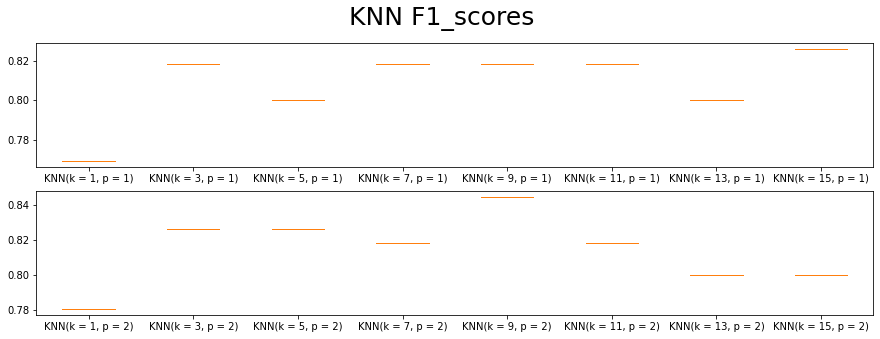

In [296]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("KNN F1_scores", fontsize = 25)
cur_max = 0
cur_index = 0

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 1)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 1)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_noise_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_noise_undersample_roc[cur_index] = [fpr, tpr]
      ISI_noise_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_noise_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 2)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 2)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_noise_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_noise_undersample_roc[cur_index] = [fpr, tpr]
      ISI_noise_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_noise_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Random Forest(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

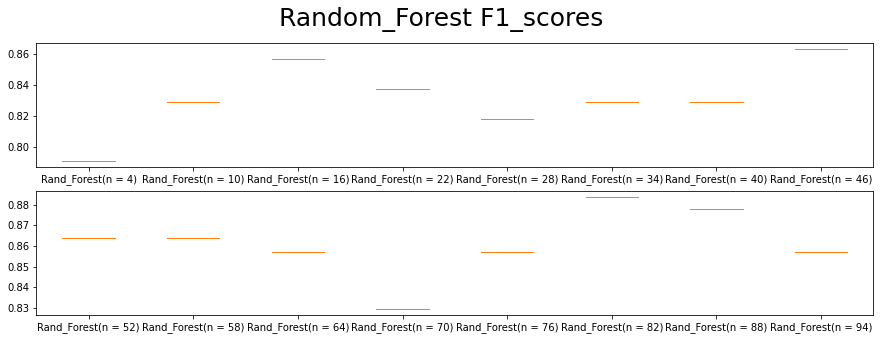

In [297]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("Random_Forest F1_scores", fontsize = 25)
cur_max = 0
cur_index = 1

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_noise_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_noise_undersample_roc[cur_index] = [fpr, tpr]
      ISI_noise_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_noise_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_noise_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_noise_undersample_roc[cur_index] = [fpr, tpr]
      ISI_noise_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_noise_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### LDA(solver = 'svd')

In [298]:
model = LDA()
reg = model.fit(X_train, y_train)

print(f'LDA F_score = {f1_score(y_test, model.predict(X_test))}')

cur_index = 2
ISI_noise_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
ISI_noise_undersample_roc[cur_index] = [fpr, tpr]
ISI_noise_undersample_results["Models"].iloc[cur_index] = "Linear_Discriminant_Analysis"
ISI_noise_undersample_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

LDA F_score = 0.8260869565217391


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##### GBC(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

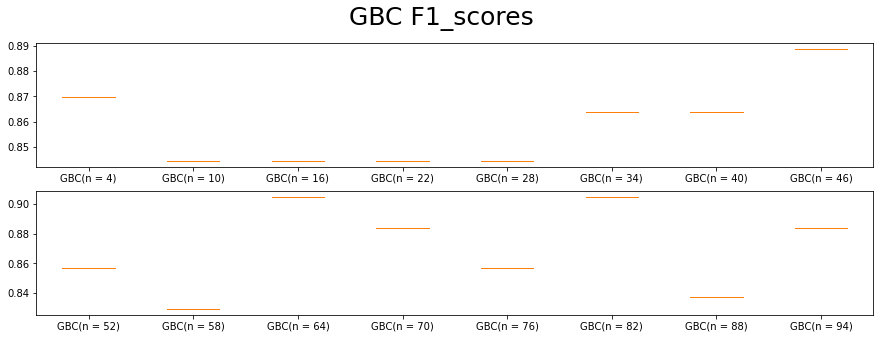

In [299]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("GBC F1_scores", fontsize = 25)
cur_max = 0
cur_index = 3

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = GBC(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_noise_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_noise_undersample_roc[cur_index] = [fpr, tpr]
      ISI_noise_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_noise_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_noise_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_noise_undersample_roc[cur_index] = [fpr, tpr]
      ISI_noise_undersample_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_noise_undersample_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Naive Bayes

In [300]:
model = GaussianNB()
reg = model.fit(X_train, y_train)

print(f'Naive Bayes F_score = {f1_score(y_test, model.predict(X_test))}')


cur_index = 4
ISI_noise_undersample_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
ISI_noise_undersample_roc[cur_index] = [fpr, tpr]
ISI_noise_undersample_results["Models"].iloc[cur_index] = "Naive_Bayes"
ISI_noise_undersample_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

Naive Bayes F_score = 0.7636363636363637


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [301]:
ISI_noise_undersample_results

,Models,F1 Score
0,"KNN(k = 9, p = 2)",0.844444
1,Rand_Forest(n = 82),0.883721
2,Linear_Discriminant_Analysis,0.826087
3,GBC(n = 64),0.904762
4,Naive_Bayes,0.763636


In [ ]:
fig = plt.figure(figsize=(14,9))
plt.suptitle("ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(len(ISI_noise_undersample_confusion)) :
    ax = fig.add_subplot(2, 3, i + 1)
    ax.plot(ISI_noise_undersample_roc[i][0],ISI_noise_undersample_roc[i][1])
    ax.set_title(ISI_noise_undersample_results['Models'].iloc[i], fontsize = 15)
    ax.set_xlabel('False Positive Rate', fontsize = 10)
    ax.set_ylabel('True Positive Rate', fontsize = 10)
    ax.plot([0, 1], [0, 1], 'k--')

plt.show()

### Smote

#### Частотные данные

In [99]:
Inhibitory_feature_freq_noise_minimal_smote = []
Excitatory_feature_freq_noise_minimal_smote = []
smote_animal_size = []
for animal in range(n_animals) :
    if (Inhibitory_neuron_type_size[animal] in [0, 1] or Excitatory_neuron_type_size[animal] in [0, 1]) :
        print("ZERO")
        Inhibitory_feature_freq_noise_minimal_smote.append([0])
        Excitatory_feature_freq_noise_minimal_smote.append([0])
        smote_animal_size.append(0)
        continue
    print(Inhibitory_neuron_type_size[animal], Excitatory_neuron_type_size[animal])
    min_class = min(Inhibitory_neuron_type_size[animal], Excitatory_neuron_type_size[animal])
    x_new, y_new = SMOTE(k_neighbors=min(min_class - 1, 5)).fit_resample(pd.concat([Inhibitory_feature_freq_noise_minimal[animal],
                                                 Excitatory_feature_freq_noise_minimal[animal]]),
                                      [-1] * len(Inhibitory_feature_freq_noise_minimal[animal]) + [1] * len(Excitatory_feature_freq_noise_minimal[animal]))

    smote_animal_size.append(min_class)
    Inhibitory_feature_freq_noise_minimal_smote.append(x_new[pd.Series(y_new) == -1])
    Excitatory_feature_freq_noise_minimal_smote.append(x_new[pd.Series(y_new) == 1])
    print(len(x_new), len(y_new), y_new)
smote_animal_size = pd.Series(smote_animal_size)

11 51
102 102 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
5 24
48 48 [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
6 27
54 54 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
7 43
86 86 [-1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

In [100]:
test_part = 0.25
Inhibitory_test_type_size = (smote_animal_size * test_part).astype(int)
Excitatory_test_type_size = (smote_animal_size * test_part).astype(int)

Inhibitory_test_indexes = []
Excitatory_test_indexes = []

for i in range(n_animals) :
    Inhibitory_test_indexes.append(random.sample([i for i in range(smote_animal_size[i])], Inhibitory_test_type_size[i]))

for i in range(n_animals) :
    Excitatory_test_indexes.append(random.sample([i for i in range(smote_animal_size[i])], Excitatory_test_type_size[i]))

In [101]:
Inhibitory_feature_freq_noise_minimal_smote_test = pd.DataFrame()
Inhibitory_feature_freq_noise_minimal_smote_train = pd.DataFrame()

for i in range(n_animals) :
    if (smote_animal_size[i] == 0) :
        continue
    for k in range(len(Inhibitory_feature_freq_noise_minimal_smote[i])) :
        if k in Inhibitory_test_indexes[i] :
            Inhibitory_feature_freq_noise_minimal_smote_test = pd.concat([Inhibitory_feature_freq_noise_minimal_smote_test,
                                                              pd.DataFrame([Inhibitory_feature_freq_noise_minimal_smote[i].iloc[k]])])
        else :
            Inhibitory_feature_freq_noise_minimal_smote_train = pd.concat([Inhibitory_feature_freq_noise_minimal_smote_train,
                                                               pd.DataFrame([Inhibitory_feature_freq_noise_minimal_smote[i].iloc[k]])])

Excitatory_feature_freq_noise_minimal_smote_test = pd.DataFrame()
Excitatory_feature_freq_noise_minimal_smote_train = pd.DataFrame()

for i in range(n_animals) :
    if (smote_animal_size[i] == 0) :
        continue
    for k in range(len(Excitatory_feature_freq_noise_minimal_smote[i])) :
        if k in Excitatory_test_indexes[i] :
            Excitatory_feature_freq_noise_minimal_smote_test = pd.concat([Excitatory_feature_freq_noise_minimal_smote_test,
                                                              pd.DataFrame([Excitatory_feature_freq_noise_minimal_smote[i].iloc[k]])])
        else :
            Excitatory_feature_freq_noise_minimal_smote_train = pd.concat([Excitatory_feature_freq_noise_minimal_smote_train,
                                                               pd.DataFrame([Excitatory_feature_freq_noise_minimal_smote[i].iloc[k]])])

In [102]:
X_test = pd.concat([Inhibitory_feature_freq_noise_minimal_smote_test, Excitatory_feature_freq_noise_minimal_smote_test])
X_train = pd.concat([Inhibitory_feature_freq_noise_minimal_smote_train, Excitatory_feature_freq_noise_minimal_smote_train])

y_test = [-1] * len(Inhibitory_feature_freq_noise_minimal_smote_test) + [1] * len(Excitatory_feature_freq_noise_minimal_smote_test)
y_train = [-1] * len(Inhibitory_feature_freq_noise_minimal_smote_train) + [1] * len(Excitatory_feature_freq_noise_minimal_smote_train)

In [103]:
Freq_noise_smote_results = pd.DataFrame(np.zeros([5, 2]), columns=["Models","F1 Score"])
Freq_noise_smote_confusion = [0] * 5
Freq_noise_smote_roc = [0] * 5

##### KNN(k = 5, p = 1)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


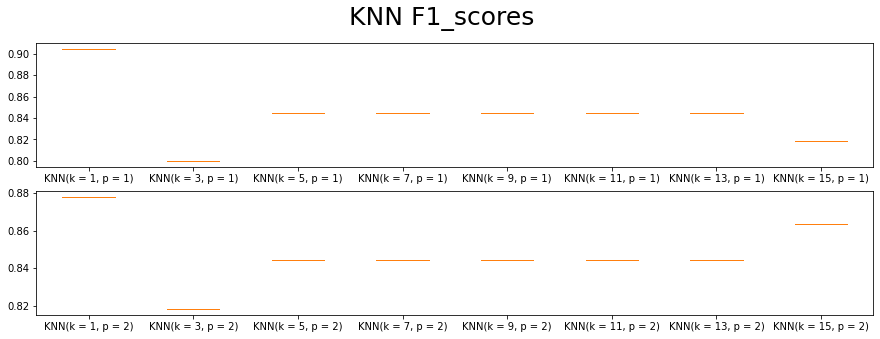

In [104]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("KNN F1_scores", fontsize = 25)
cur_max = 0
cur_index = 0

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 1)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 1)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_noise_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_noise_smote_roc[cur_index] = [fpr, tpr]
      Freq_noise_smote_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_noise_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)


ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 2)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 2)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_noise_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_noise_smote_roc[cur_index] = [fpr, tpr]
      Freq_noise_smote_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_noise_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Random Forest(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

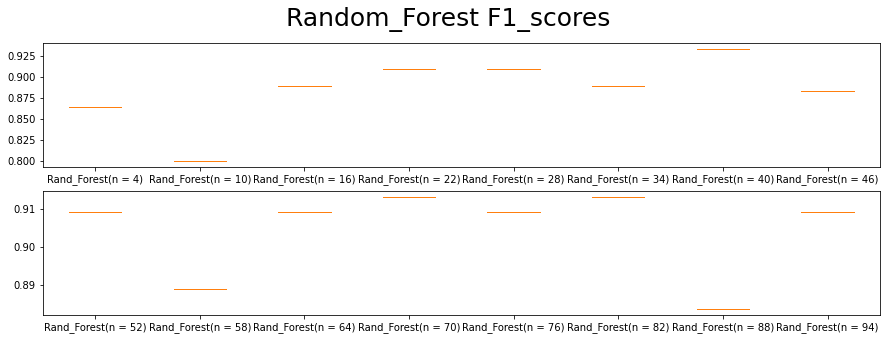

In [105]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("Random_Forest F1_scores", fontsize = 25)
cur_max = 0
cur_index = 1

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_noise_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_noise_smote_roc[cur_index] = [fpr, tpr]
      Freq_noise_smote_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_noise_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_noise_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_noise_smote_roc[cur_index] = [fpr, tpr]
      Freq_noise_smote_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_noise_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### LDA(solver = 'svd')

In [106]:
model = LDA()
reg = model.fit(X_train, y_train)

print(f'LDA F_score = {f1_score(y_test, model.predict(X_test))}')

cur_index = 2
Freq_noise_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
Freq_noise_smote_roc[cur_index] = [fpr, tpr]
Freq_noise_smote_results["Models"].iloc[cur_index] = "Linear_Discriminant_Analysis"
Freq_noise_smote_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

LDA F_score = 0.8163265306122449


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##### GBC(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

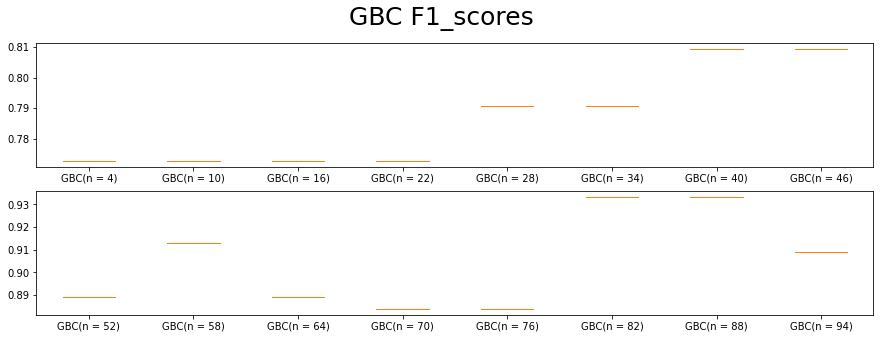

In [107]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("GBC F1_scores", fontsize = 25)
cur_max = 0
cur_index = 3

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = GBC(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_noise_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_noise_smote_roc[cur_index] = [fpr, tpr]
      Freq_noise_smote_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_noise_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      Freq_noise_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      Freq_noise_smote_roc[cur_index] = [fpr, tpr]
      Freq_noise_smote_results["Models"].iloc[cur_index] = names_array[-1]
      Freq_noise_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Naive Bayes

In [108]:
model = GaussianNB()
reg = model.fit(X_train, y_train)

print(f'Naive Bayes F_score = {f1_score(y_test, model.predict(X_test))}')

cur_index = 4
Freq_noise_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
Freq_noise_smote_roc[cur_index] = [fpr, tpr]
Freq_noise_smote_results["Models"].iloc[cur_index] = "Naive_Bayes"
Freq_noise_smote_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

Naive Bayes F_score = 0.8076923076923077


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [109]:
Freq_noise_smote_results

,Models,F1 Score
0,"KNN(k = 1, p = 1)",0.904762
1,Rand_Forest(n = 40),0.933333
2,Linear_Discriminant_Analysis,0.816327
3,GBC(n = 82),0.933333
4,Naive_Bayes,0.807692


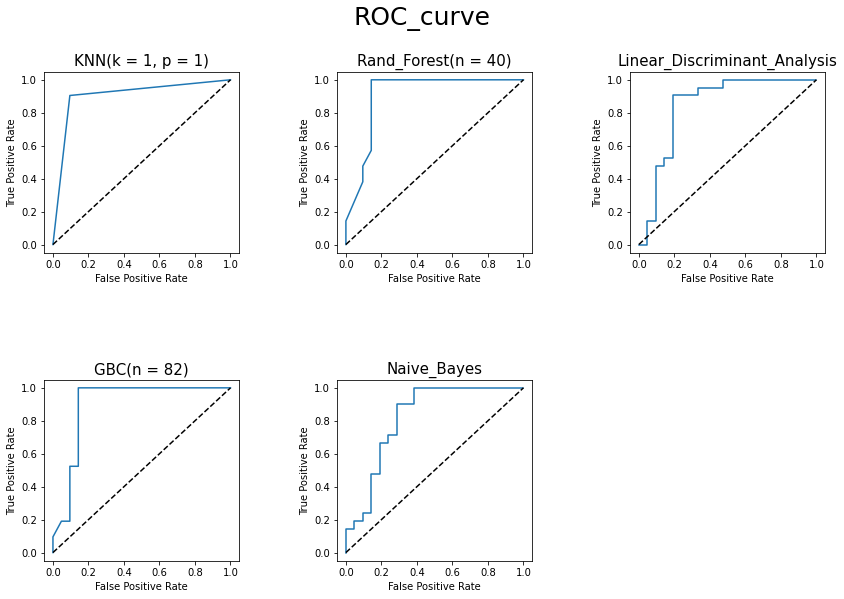

In [110]:
fig = plt.figure(figsize=(14,9))
plt.suptitle("ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(len(Freq_noise_smote_confusion)) :
    ax = fig.add_subplot(2, 3, i + 1)
    ax.plot(Freq_noise_smote_roc[i][0],Freq_noise_smote_roc[i][1])
    ax.set_title(Freq_noise_smote_results['Models'].iloc[i], fontsize = 15)
    ax.set_xlabel('False Positive Rate', fontsize = 10)
    ax.set_ylabel('True Positive Rate', fontsize = 10)
    ax.plot([0, 1], [0, 1], 'k--')

plt.show()

#### ISI

In [111]:
Inhibitory_feature_ISI_noise_minimal_smote = []
Excitatory_feature_ISI_noise_minimal_smote = []
smote_animal_size = []
for animal in range(n_animals) :
    if (Inhibitory_neuron_type_size[animal] in [0, 1] or Excitatory_neuron_type_size[animal] in [0, 1]) :
        print("ZERO")
        Inhibitory_feature_ISI_noise_minimal_smote.append([0])
        Excitatory_feature_ISI_noise_minimal_smote.append([0])
        smote_animal_size.append(0)
        continue
    print(Inhibitory_neuron_type_size[animal], Excitatory_neuron_type_size[animal])
    min_class = min(Inhibitory_neuron_type_size[animal], Excitatory_neuron_type_size[animal])
    x_new, y_new = SMOTE(k_neighbors=min(min_class - 1, 5)).fit_resample(pd.concat([Inhibitory_feature_ISI_noise_minimal[animal],
                                                 Excitatory_feature_ISI_noise_minimal[animal]]),
                                      [-1] * len(Inhibitory_feature_ISI_noise_minimal[animal]) + [1] * len(Excitatory_feature_ISI_noise_minimal[animal]))

    smote_animal_size.append(min_class)
    Inhibitory_feature_ISI_noise_minimal_smote.append(x_new[pd.Series(y_new) == -1])
    Excitatory_feature_ISI_noise_minimal_smote.append(x_new[pd.Series(y_new) == 1])
    print(len(x_new), len(y_new), y_new)
smote_animal_size = pd.Series(smote_animal_size)

11 51
102 102 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
5 24
48 48 [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
6 27
54 54 [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
7 43
86 86 [-1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

In [112]:
test_part = 0.25
Inhibitory_test_type_size = (smote_animal_size * test_part).astype(int)
Excitatory_test_type_size = (smote_animal_size * test_part).astype(int)

Inhibitory_test_indexes = []
Excitatory_test_indexes = []

for i in range(n_animals) :
    Inhibitory_test_indexes.append(random.sample([i for i in range(smote_animal_size[i])], Inhibitory_test_type_size[i]))

for i in range(n_animals) :
    Excitatory_test_indexes.append(random.sample([i for i in range(smote_animal_size[i])], Excitatory_test_type_size[i]))

In [113]:
Inhibitory_feature_ISI_noise_minimal_smote_test = pd.DataFrame()
Inhibitory_feature_ISI_noise_minimal_smote_train = pd.DataFrame()

for i in range(n_animals) :
    if (smote_animal_size[i] == 0) :
        continue
    for k in range(len(Inhibitory_feature_ISI_noise_minimal_smote[i])) :
        if k in Inhibitory_test_indexes[i] :
            Inhibitory_feature_ISI_noise_minimal_smote_test = pd.concat([Inhibitory_feature_ISI_noise_minimal_smote_test,
                                                              pd.DataFrame([Inhibitory_feature_ISI_noise_minimal_smote[i].iloc[k]])])
        else :
            Inhibitory_feature_ISI_noise_minimal_smote_train = pd.concat([Inhibitory_feature_ISI_noise_minimal_smote_train,
                                                               pd.DataFrame([Inhibitory_feature_ISI_noise_minimal_smote[i].iloc[k]])])

Excitatory_feature_ISI_noise_minimal_smote_test = pd.DataFrame()
Excitatory_feature_ISI_noise_minimal_smote_train = pd.DataFrame()

for i in range(n_animals) :
    if (smote_animal_size[i] == 0) :
        continue
    for k in range(len(Excitatory_feature_ISI_noise_minimal_smote[i])) :
        if k in Excitatory_test_indexes[i] :
            Excitatory_feature_ISI_noise_minimal_smote_test = pd.concat([Excitatory_feature_ISI_noise_minimal_smote_test,
                                                              pd.DataFrame([Excitatory_feature_ISI_noise_minimal_smote[i].iloc[k]])])
        else :
            Excitatory_feature_ISI_noise_minimal_smote_train = pd.concat([Excitatory_feature_ISI_noise_minimal_smote_train,
                                                               pd.DataFrame([Excitatory_feature_ISI_noise_minimal_smote[i].iloc[k]])])

In [114]:
X_test = pd.concat([Inhibitory_feature_ISI_noise_minimal_smote_test, Excitatory_feature_ISI_noise_minimal_smote_test])
X_train = pd.concat([Inhibitory_feature_ISI_noise_minimal_smote_train, Excitatory_feature_ISI_noise_minimal_smote_train])

y_test = [-1] * len(Inhibitory_feature_ISI_noise_minimal_smote_test) + [1] * len(Excitatory_feature_ISI_noise_minimal_smote_test)
y_train = [-1] * len(Inhibitory_feature_ISI_noise_minimal_smote_train) + [1] * len(Excitatory_feature_ISI_noise_minimal_smote_train)

In [115]:
ISI_noise_smote_results = pd.DataFrame(np.zeros([5, 2]), columns=["Models","F1 Score"])
ISI_noise_smote_confusion = [0] * 5
ISI_noise_smote_roc = [0] * 5

##### KNN(k = 5, p = 1)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

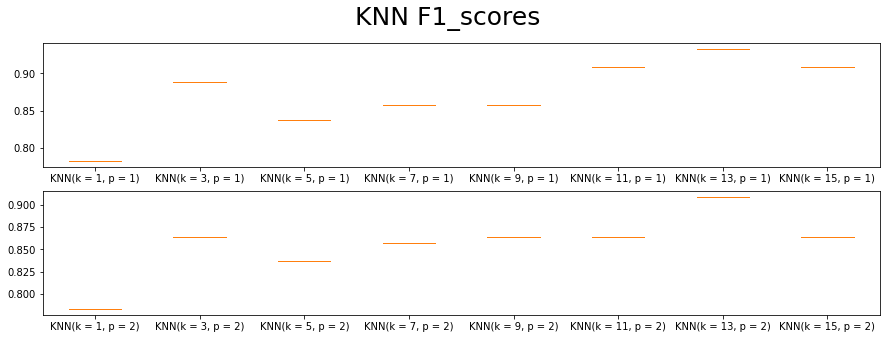

In [116]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("KNN F1_scores", fontsize = 25)
cur_max = 0
cur_index = 0

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 1)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 1)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_noise_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_noise_smote_roc[cur_index] = [fpr, tpr]
      ISI_noise_smote_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_noise_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)


ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8) :
  model = KNN(1 + 2 * i, p = 2)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'KNN(k = {1 + 2 * i}, p = 2)')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_noise_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_noise_smote_roc[cur_index] = [fpr, tpr]
      ISI_noise_smote_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_noise_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Random Forest(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

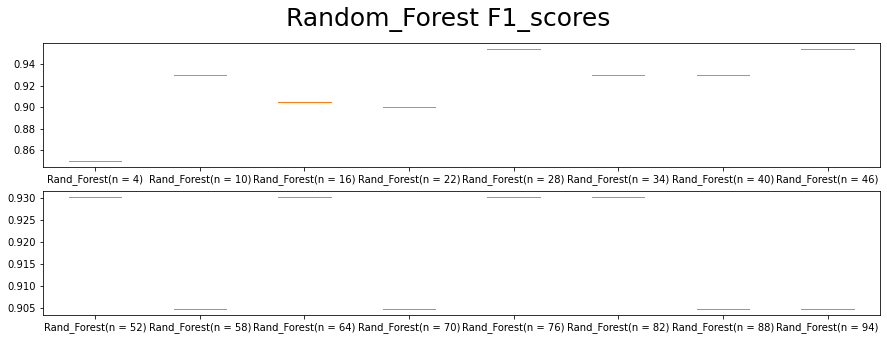

In [117]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("Random_Forest F1_scores", fontsize = 25)
cur_max = 0
cur_index = 1

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_noise_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_noise_smote_roc[cur_index] = [fpr, tpr]
      ISI_noise_smote_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_noise_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'Rand_Forest(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_noise_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_noise_smote_roc[cur_index] = [fpr, tpr]
      ISI_noise_smote_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_noise_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### LDA(solver = 'svd')

In [118]:
model = LDA()
reg = model.fit(X_train, y_train)

print(f'LDA F_score = {f1_score(y_test, model.predict(X_test))}')


cur_index = 2
ISI_noise_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
ISI_noise_smote_roc[cur_index] = [fpr, tpr]
ISI_noise_smote_results["Models"].iloc[cur_index] = "Linear_Discriminant_Analysis"
ISI_noise_smote_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

LDA F_score = 0.8571428571428571


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##### GBC(n = 10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

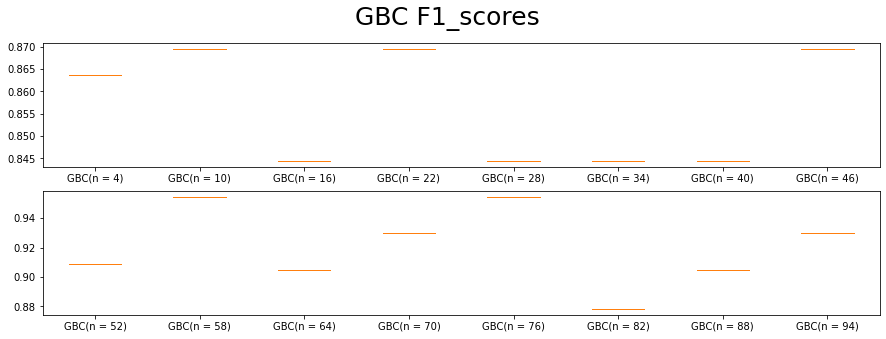

In [119]:
fig = plt.figure(figsize=(15,5))
plt.suptitle("GBC F1_scores", fontsize = 25)
cur_max = 0
cur_index = 3

ax = fig.add_subplot(2, 1, 1)
fscores_array = []
names_array = []
for i in range(8) :
  model = GBC(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_noise_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_noise_smote_roc[cur_index] = [fpr, tpr]
      ISI_noise_smote_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_noise_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)


ax = fig.add_subplot(2, 1, 2)
fscores_array = []
names_array = []
for i in range(8, 16) :
  model = Rand_Forest(n_estimators = 4 + 6 * i)
  reg = model.fit(X_train, y_train)
  fscores_array.append([f1_score(y_test, model.predict(X_test))])
  names_array.append(f'GBC(n = {4 + 6 * i})')
  if (fscores_array[-1][0] > cur_max) :
      cur_max = fscores_array[-1][0]
      ISI_noise_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
      fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
      ISI_noise_smote_roc[cur_index] = [fpr, tpr]
      ISI_noise_smote_results["Models"].iloc[cur_index] = names_array[-1]
      ISI_noise_smote_results["F1 Score"].iloc[cur_index] = fscores_array[-1][0]
ax.boxplot(fscores_array, labels = names_array)

plt.show()

##### Naive Bayes

In [120]:
model = GaussianNB()
reg = model.fit(X_train, y_train)

print(f'Naive Bayes F_score = {f1_score(y_test, model.predict(X_test))}')

cur_index = 4
ISI_noise_smote_confusion[cur_index] = confusion_matrix(y_test, model.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
ISI_noise_smote_roc[cur_index] = [fpr, tpr]
ISI_noise_smote_results["Models"].iloc[cur_index] = "Naive_Bayes"
ISI_noise_smote_results["F1 Score"].iloc[cur_index] = f1_score(y_test, model.predict(X_test))

Naive Bayes F_score = 0.7241379310344828


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [124]:
ISI_noise_smote_results

,Models,F1 Score
0,"KNN(k = 13, p = 1)",0.933333
1,Rand_Forest(n = 28),0.954545
2,Linear_Discriminant_Analysis,0.857143
3,GBC(n = 58),0.954545
4,Naive_Bayes,0.724138


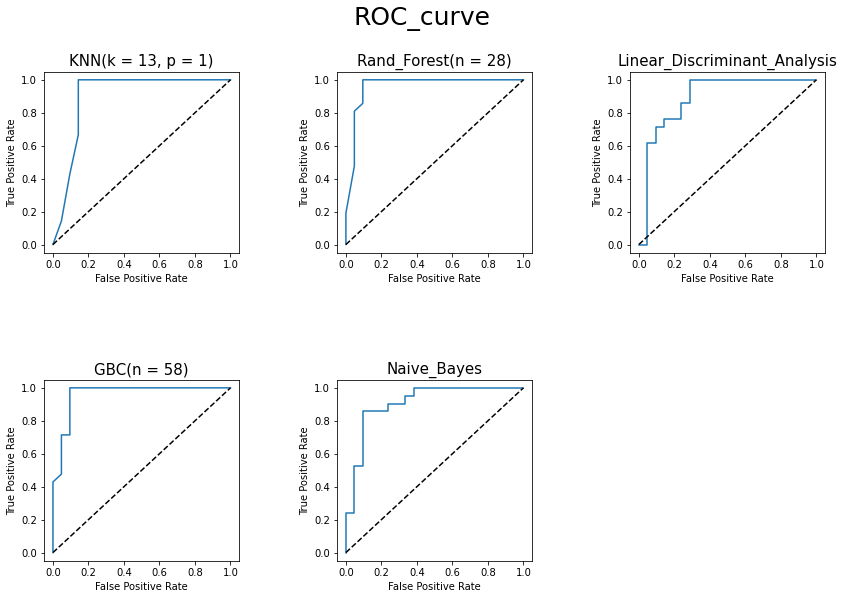

In [122]:
fig = plt.figure(figsize=(14,9))
plt.suptitle("ROC_curve", fontsize = 25)
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for i in range(len(ISI_noise_smote_confusion)) :
    ax = fig.add_subplot(2, 3, i + 1)
    ax.plot(ISI_noise_smote_roc[i][0],ISI_noise_smote_roc[i][1])
    ax.set_title(ISI_noise_smote_results['Models'].iloc[i], fontsize = 15)
    ax.set_xlabel('False Positive Rate', fontsize = 10)
    ax.set_ylabel('True Positive Rate', fontsize = 10)
    ax.plot([0, 1], [0, 1], 'k--')

plt.show()

# Нужна ли балансировка

## Freq

In [273]:
Freq_results

,Models,F1 Score
0,"KNN(k = 13, p = 2)",0.956522
1,Rand_Forest(n = 10),0.967290
2,Linear_Discriminant_Analysis,0.955504
3,GBC(n = 10),0.965517
4,Naive_Bayes,0.953917


In [274]:
Freq_undersample_results

,Models,F1 Score
0,"KNN(k = 3, p = 1)",0.857143
1,Rand_Forest(n = 46),0.909091
2,Linear_Discriminant_Analysis,0.888889
3,GBC(n = 52),0.909091
4,Naive_Bayes,0.792453


In [275]:
Freq_smote_results

,Models,F1 Score
0,"KNN(k = 15, p = 1)",0.909091
1,Rand_Forest(n = 22),0.888889
2,Linear_Discriminant_Analysis,0.851064
3,GBC(n = 52),0.888889
4,Naive_Bayes,0.792453


In [276]:
Freq_all_results = pd.DataFrame(columns = ['Models', 'F1 score', 'F1 score Undersample', 'F1 score SMOTE'])
Freq_all_results['Models'] = Freq_results['Models']
Freq_all_results['F1 score'] = Freq_results['F1 Score']
Freq_all_results['F1 score Undersample'] = Freq_undersample_results['F1 Score']
Freq_all_results['F1 score SMOTE'] = Freq_smote_results['F1 Score']
Freq_all_results

,Models,F1 score,F1 score Undersample,F1 score SMOTE
0,"KNN(k = 13, p = 2)",0.956522,0.857143,0.909091
1,Rand_Forest(n = 10),0.967290,0.909091,0.888889
2,Linear_Discriminant_Analysis,0.955504,0.888889,0.851064
3,GBC(n = 10),0.965517,0.909091,0.888889
4,Naive_Bayes,0.953917,0.792453,0.792453


In [286]:
ISI_all_results = pd.DataFrame(columns = ['Models', 'F1 score', 'F1 score Undersample', 'F1 score SMOTE'])
ISI_all_results['Models'] = ISI_results['Models']
ISI_all_results['F1 score'] = ISI_results['F1 Score']
ISI_all_results['F1 score Undersample'] = ISI_undersample_results['F1 Score']
ISI_all_results['F1 score SMOTE'] = ISI_smote_results['F1 Score']
ISI_all_results

,Models,F1 score,F1 score Undersample,F1 score SMOTE
0,"KNN(k = 7, p = 1)",0.964871,0.869565,0.878049
1,Rand_Forest(n = 82),0.971963,0.844444,0.954545
2,Linear_Discriminant_Analysis,0.961098,0.826087,0.800000
3,GBC(n = 88),0.971963,0.863636,0.933333
4,Naive_Bayes,0.954128,0.727273,0.724138


In [304]:
Freq_noise_all_results = pd.DataFrame(columns = ['Models', 'F1 score', 'F1 score Noise'])
Freq_noise_all_results['Models'] = Freq_results['Models']
Freq_noise_all_results['F1 score'] = Freq_results['F1 Score']
Freq_noise_all_results['F1 score Noise'] = Freq_noise_results['F1 Score']
Freq_noise_all_results

,Models,F1 score,F1 score Noise
0,"KNN(k = 13, p = 2)",0.956522,0.904656
1,Rand_Forest(n = 10),0.967290,0.916854
2,Linear_Discriminant_Analysis,0.955504,0.916854
3,GBC(n = 10),0.965517,0.924107
4,Naive_Bayes,0.953917,0.892779


In [305]:
ISI_noise_all_results = pd.DataFrame(columns = ['Models', 'F1 score', 'F1 score Noise'])
ISI_noise_all_results['Models'] = ISI_results['Models']
ISI_noise_all_results['F1 score'] = ISI_results['F1 Score']
ISI_noise_all_results['F1 score Noise'] = ISI_noise_results['F1 Score']
ISI_noise_all_results

,Models,F1 score,F1 score Noise
0,"KNN(k = 7, p = 1)",0.964871,0.963470
1,Rand_Forest(n = 82),0.971963,0.965197
2,Linear_Discriminant_Analysis,0.961098,0.961276
3,GBC(n = 88),0.971963,0.963134
4,Naive_Bayes,0.954128,0.959091


In [306]:
ISI_results

,Models,F1 Score
0,"KNN(k = 7, p = 1)",0.964871
1,Rand_Forest(n = 82),0.971963
2,Linear_Discriminant_Analysis,0.961098
3,GBC(n = 88),0.971963
4,Naive_Bayes,0.954128
